In [1]:
import time

import pandas as pd 
import numpy as np 
import seaborn as sns 
import matplotlib.pyplot as plt 


from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV, RepeatedKFold
from sklearn.metrics import roc_auc_score


import xgboost


from tqdm.notebook import tqdm_notebook
from tqdm.notebook import tqdm


import torch
import torch.nn as nn 
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader



In [2]:
import torchmetrics

In [3]:
import typing

In [4]:
# drive.mount('/content/drive')

In [ ]:
#!ls '/content/drive/MyDrive/alpha'

In [ ]:
#%cd '/content/drive/MyDrive/alpha'

In [ ]:
#!ls

In [5]:
gender_train = pd.read_csv('gender_train.csv')

In [6]:
gender_train

,customer_id,gender
0,10928546,1
1,69348468,1
2,61009479,0
3,74045822,0
4,27979606,1
...,...,...
8395,90417572,0
8396,66837341,0
8397,10758984,1
8398,11376556,0


In [7]:
train =  gender_train.set_index('customer_id')

In [8]:
mcc_codes = pd.read_csv('tr_mcc_codes.csv', delimiter=';')
tr_types = pd.read_csv('tr_types.csv', delimiter=';')
transactions = pd.read_csv('transactions.csv', delimiter=',')

In [9]:
mcc_codes.head()

,mcc_code,mcc_description
0,742,Ветеринарные услуги
1,1711,"Генеральные подрядчики по вентиляции, теплосна..."
2,1731,Подрядчики по электричеству
3,1799,"Подрядчики, специализированная торговля — нигд..."
4,2741,Разнообразные издательства/печатное дело


In [10]:
tr_types.head()

,tr_type,tr_description
0,3200,Плата за предоставление услуг посредством моби...
1,3210,Плата за предоставление отчета по счету карты ...
2,3800,Плата за обслуживание банковской карты (за пер...
3,4000,Плата за получение наличных в Сбербанке
4,4001,Плата за получение наличных в Сбербанке (в дру...


In [10]:
transactions.head()

,customer_id,tr_datetime,mcc_code,tr_type,amount,term_id
0,39026145,0 10:23:26,4814,1030,-2245.92,NaN
1,39026145,1 10:19:29,6011,7010,56147.89,NaN
2,39026145,1 10:20:56,4829,2330,-56147.89,NaN
3,39026145,1 10:39:54,5499,1010,-1392.47,NaN
4,39026145,2 15:33:42,5499,1010,-920.83,NaN


In [11]:
sum(transactions['term_id'].isna()) / transactions['term_id'].shape[0]

0.40371664681562297

# Разведочный анализ данных

Посмотрим пропуски в тестовых данных и в целом балансировку пола в тесте.

In [12]:
gender_train['gender'].isna().sum()

0

In [13]:
mcc_codes.isna().sum()

mcc_code           0
mcc_description    0
dtype: int64

In [14]:
tr_types.isna().sum()

tr_type           0
tr_description    0
dtype: int64

In [15]:
transactions.isna().sum()

customer_id          0
tr_datetime          0
mcc_code             0
tr_type              0
amount               0
term_id        2765195
dtype: int64

Все значения не содержат пропущенных значений, кроме значения term_id, который является привязкой к какой-то таблице данных, которой нет в наших данных, поэтому при проведении расчетов дропнем term_id.
Рассмотрим дисбаланс классов

In [16]:
gender_train['gender'].value_counts()

0    4687
1    3713
Name: gender, dtype: int64

В целом мы имеем практически идеальную задачу бинарной классификации, где нет дисбаланса классов. Попробуем посмотреть кореляцию признаков по парам с целевой метрикой (gender). Для этого сольем наши 3 датафрейма в один.

In [134]:
final_train_dataset = transactions.merge(mcc_codes, on='mcc_code', how='inner').merge(gender_train, on='customer_id', how='inner')\
                                  .merge(tr_types, on='tr_type', how='inner')

In [18]:
final_train_dataset.head()

,customer_id,tr_datetime,mcc_code,tr_type,amount,term_id,mcc_description,gender,tr_description
0,39026145,0 10:23:26,4814,1030,-2245.92,NaN,"Звонки с использованием телефонов, считывающих...",1,Оплата услуги. Банкоматы СБ РФ
1,39026145,6 07:08:31,4814,1030,-5614.79,NaN,"Звонки с использованием телефонов, считывающих...",1,Оплата услуги. Банкоматы СБ РФ
2,39026145,8 07:06:10,4814,1030,-1122.96,NaN,"Звонки с использованием телефонов, считывающих...",1,Оплата услуги. Банкоматы СБ РФ
3,39026145,11 08:49:03,4814,1030,-2245.92,NaN,"Звонки с использованием телефонов, считывающих...",1,Оплата услуги. Банкоматы СБ РФ
4,39026145,11 14:12:08,4814,1030,-2245.92,NaN,"Звонки с использованием телефонов, считывающих...",1,Оплата услуги. Банкоматы СБ РФ


In [135]:
final_train_dataset.drop('gender', axis=1).corrwith(final_train_dataset['gender'])

customer_id    0.024901
mcc_code       0.028355
tr_type       -0.000263
amount        -0.008664
dtype: float64

Заметим, что здесь мы никак не используем информацию из транзакций, то есть непосредственно описание mcc кода (непосредственно не используем, но все же косвенно мы учитываем одинаковость айдишников в словаре). Мы видим достаточно низкие корреляции с целевой меткой. Затем, что все же есть корреляция с mcc_code, вероятно, это и поможет нам делать предсказания. Вполне возможно, что за baseline можно взять наивную простейшую модель KNN-ближайших соседей на основании трат и прибыльных транзакций, однако у нас слишком мало признаков для принятия такого решения (крайне много объектов будут похоже друг на друга). Сначала займемся генерацией фичей. 

Итогово проверим, есть ли такие объекты в тестовых данных, которые для одного и того же customer_id показывают разное значение целевой метки.

In [20]:
agg_table_gender_by_customer_id = final_train_dataset[['gender', 'customer_id']].groupby('customer_id').agg(sum_gender=('gender', np.sum),
                                                                                                            count_gender=('gender', 'count'))

In [21]:
(agg_table_gender_by_customer_id['sum_gender'] / agg_table_gender_by_customer_id['count_gender']).value_counts()

0.0    4687
1.0    3713
dtype: int64

Таких значений нет. Если бы мы получили значения, отличные от 1.0 и 0.0, то это бы означало, что есть пользователь, который помечен двумя гендерами одновременно в разных транзакциях, что, конечно, говорило бы о противоречивости данных. Здесь этого не наблюдаем, видимо, была проделана хорошая работа над данными, чтобы они были конститентны.

In [22]:
 # sns.pairplot(final_train_dataset)  - не хватает оперативной памяти

# Feature engineering

Начнем с преобразования данных, лежащих в колонке tr_datetime, то есть дата транзакции. Судя по наименованию атрибута там должно храниться как время, так и конкретный день, когда транзакция была совершена. Посмотрим внимательнее:

In [136]:
final_train_dataset['tr_datetime'].values[:10]

array(['0 10:23:26', '6 07:08:31', '8 07:06:10', '11 08:49:03',
       '11 14:12:08', '11 14:15:30', '13 11:17:34', '18 07:39:05',
       '19 13:24:35', '19 13:25:31'], dtype=object)

Действительно есть целочисленное значение, стоящее перед непосредственно временем совершения тразакции. Заметим, что оно принимает значения больше 6, а это означает, что это день месяца, но никак не день недели. Так как мы не обладаем конкретным месяцем в дате, а лишь имеем день, то сделаем перевод в день недели, для этого преобразуем следующим образом:
* Разобьем строку на 2 (разделитель " ")
* От первого значения возьмем остаток от деления на 7

Такое преобразование даст нам день в абстрактной неделе (на самом деле, это неверно достаточно часто). 
В теории, чтобы улучшить наше представление о дне недели, можно проверить тренды покупок. Однако, предположение о том, что в выходные покупок больше является несколько наивным в силу того, что интернет-магазины предоставляют возможность покупок в любой день, вне зависимости от рабочего времени конкретного субъекта.

In [137]:
final_train_dataset['day_of_week'] = final_train_dataset['tr_datetime'].apply(lambda x: int(x.split()[0]) % 7)

Рассмотрим распределение транзакций относительно тех дней в неделю, которые мы построили.

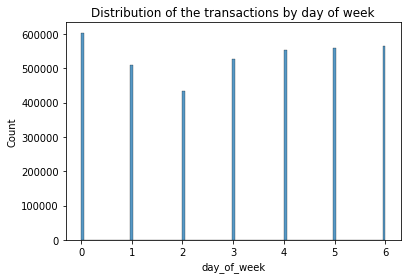

In [24]:
sns.histplot(data=final_train_dataset, x='day_of_week')
plt.title('Distribution of the transactions by day of week')
plt.show()

В целом, ощущение такое, что данные для датасета старательно отбирались, потому что нет сильно выделенных пиков по транзакциям (хотя идейно они должны быть). Поэтому не будем вводить признак выходное дня, так как с точки зрения наблюдаемых данных не особо имеет смысла.

Также выделим отдельный признак, который означает ночь или день суток в зависимости от времени. Воспользуемся эвристикой, что ночью (ночное время суток) будем считать время от 22:00 до 6:00 включительно. Разумеется, это достаточно простая эвристика разделения на день/ночь, которая может быть уточнена.

In [138]:
final_train_dataset['is_day'] = final_train_dataset['tr_datetime'].apply(lambda x: 1 if time.strptime(x.split()[1], '%H:%M:%S').tm_hour in range(6, 23) else 0)

In [26]:
final_train_dataset.is_day.value_counts()

1    3061578
0     688000
Name: is_day, dtype: int64

так же добавим в качестве фичей саму разбивку на время.

In [139]:
final_train_dataset['clear_time'] = final_train_dataset['tr_datetime'].apply(lambda x: x.split()[1])

In [140]:
final_train_dataset['clear_time'] = pd.to_datetime(final_train_dataset['clear_time'], format='%H:%M:%S')

In [141]:
final_train_dataset['hour'] = final_train_dataset['clear_time'].dt.hour
final_train_dataset['min'] = final_train_dataset['clear_time'].dt.minute
final_train_dataset['sec'] = final_train_dataset['clear_time'].dt.second

In [142]:
minutes = final_train_dataset['min']

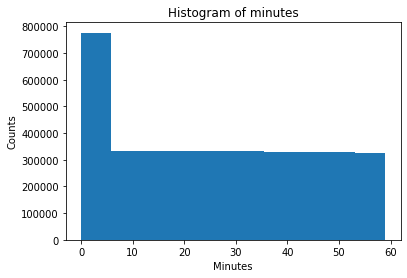

In [221]:
plt.hist(minutes)
plt.title('Histogram of minutes')
plt.xlabel('Minutes')
plt.ylabel('Counts')
plt.show()

Какие-то сверхидеальные данные...

Попробуем теперь поискать инсайты в словаре mcc.
Попробуем найти по простому текстовому поиску те категории, которые могли бы (в теории) иметь хорошую вероятность определить пол.

In [33]:
mcc_codes[mcc_codes['mcc_description'].str.contains(r'женск', case=False)]

,mcc_code,mcc_description
39,5137,"Мужская, женская и детская спец-одежда"
70,5621,Готовая женская одежда
77,5691,Магазины мужской и женской одежды


In [34]:
mcc_codes[mcc_codes['mcc_description'].str.contains(r'муж', case=False)]

,mcc_code,mcc_description
39,5137,"Мужская, женская и детская спец-одежда"
69,5611,"Мужская одежда и аксессуары, включая одежду дл..."
77,5691,Магазины мужской и женской одежды


Обратим внимание на то, что есть специфические для гендера транзации, попробуем проверить их возможность отличать гендеры.

In [35]:
final_train_dataset[final_train_dataset['mcc_code'] == 5621]['gender'].value_counts()

0    3750
1     755
Name: gender, dtype: int64

In [36]:
final_train_dataset[final_train_dataset['mcc_code'] == 5611]['gender'].value_counts()

1    511
0    410
Name: gender, dtype: int64

Видно, что в целом непоказательные различия для двух величин. Хотя для "Готовая женская одежда" доля составляет 78%. Можно посмотреть на сколько данные 78% доли вообще статистически значимы. Проверим стат.гипотезу:
H0: mu = 0.5,
H1: mu > 0.5

Проверять будем именно одностороннюю альтернативу по той причине, что мы хотим именно проверить тот факт, что это действительно маловероятно получить 78% при нашей нулевой гипотезе в 50%. 

In [37]:
from scipy.stats import binom

In [38]:
print(f'p value is {1 - binom.cdf(3750 - 1, 3750 + 755, 0.5)}')

p value is 1.1102230246251565e-16


Отвергаем нулевую гипотезу при уровне значимости 5%. Поэтому H0 отвергнута в пользу односторонней альтернативы, где mu > 0.5. То есть с формальной точки признак может разделять гендеры. Добавим его обучающий датасет

In [144]:
final_train_dataset['has_zero_gender_mcc'] = (final_train_dataset['mcc_code'] == 5621).astype(int)

In [40]:
final_train_dataset['has_zero_gender_mcc'].value_counts()

0    3745073
1       4505
Name: has_zero_gender_mcc, dtype: int64

Попробуем посмотреть еще какие-нибудь MCC, которые позволят нам разделять гендеры.

In [41]:
from collections import defaultdict

In [42]:
mcc_descript = []
for mcc in mcc_codes['mcc_description'].values:
    gender_values = final_train_dataset[final_train_dataset['mcc_description'] == mcc]['gender'].value_counts().to_dict()
    zero_gender_relation = gender_values.get(0, 0) / (gender_values.get(0, 0) + gender_values.get(1, 0))
    if (zero_gender_relation > 0.85) or (1 - zero_gender_relation > 0.85):
            mcc_descript.append({mcc: {
                0: gender_values.get(0, 0),
                1: gender_values.get(1, 0)
            }})     
    

In [43]:
mcc_descript

[{'Подрядчики по электричеству': {0: 7, 1: 45}},
 {'Агентства по аренде автомобилей': {0: 4, 1: 34}},
 {'Дорожный и мостовой сборы, пошлины': {0: 131, 1: 762}},
 {'Магазины second hand, магазины б/у товаров, комиссионки': {0: 271, 1: 34}},
 {'Прямой маркетинг — комбинированный каталог и торговцы в розницу': {0: 106,
   1: 7}},
 {'Прямой маркетинг — входящий телемаркетинг': {0: 4, 1: 236}},
 {'Ценные бумаги: брокеры/дилеры': {0: 80, 1: 707}},
 {'Прокат автомобилей': {0: 18, 1: 104}},
 {'Галереи/учреждения видеоигр': {0: 726, 1: 4769}},
 {'Транзакции по азартным играм': {0: 1754, 1: 11665}},
 {'Школы — бизнес и секретарей': {0: 4, 1: 25}},
 {'Судовые выплаты, включая алименты и детскую поддержку': {0: 39, 1: 0}}]

Есть интересная категория, связанная с азартными играми. Добавим так же ее как признак.

In [44]:
final_train_dataset[final_train_dataset['mcc_code'] == 7995][['gender']].value_counts()

gender
1         11665
0          1754
dtype: int64

In [145]:
final_train_dataset['gambling'] = (final_train_dataset['mcc_code'] == 7995).astype(int)

In [46]:
final_train_dataset.columns

Index(['customer_id', 'tr_datetime', 'mcc_code', 'tr_type', 'amount',
       'term_id', 'mcc_description', 'gender', 'tr_description', 'day_of_week',
       'is_day', 'clear_time', 'hour', 'min', 'sec', 'has_zero_gender_mcc',
       'gambling'],
      dtype='object')

Так как у нас по каждому человек может быть более 1 транзакции, то требуется создать признаки, которые будут относиться к конкретному физическому лицу (customer_id). Для признаков с типом float (а это amount) возьмем соответственно среднее, стандартное отклонение, минимум, максимум, моду, итоговую сумму.

Для наших бинарных фичей мы посчитаем количество объектов для каждого customer_id с различными значениями признака. Сразу нормализуем такие значения. Вероятно, добавлять количество секунд и минут в качестве отдельных признаков не совсем верно. Поэтому посчитаем количество секунд от начала дня и по ним так же возьмем все метрики, как для float фичей.

Итого, разобьем еще все транзакции на положительные (которые приносят деньги) и отрицательные, которые являются тратами. 

In [146]:
def create_features_dataset_by_customer_id(dataset: pd.DataFrame) -> pd.Series: 
    features = []
    features.append(pd.Series(dataset['day_of_week'].value_counts(normalize=True).add_prefix('day_of_week')))
    features.append(pd.Series(dataset['hour'].value_counts(normalize=True).add_prefix('hour_')))
    features.append(pd.Series(dataset['is_day'].value_counts(normalize=True).add_prefix('is_day_')))
    features.append(pd.Series(dataset['gambling'].value_counts(normalize=True).add_prefix('gambling_')))
    features.append(pd.Series(dataset['has_zero_gender_mcc'].value_counts(normalize=True).add_prefix('has_zero_gender_mcc_')))

    features.append(pd.Series(dataset[dataset['amount']>0]['amount'].agg(['min', 'max', 'mean', 'median', 'std', 'sum'])\
                                                        .add_prefix('positive_transactions_')))
    features.append(pd.Series(dataset[dataset['amount']<0]['amount'].agg(['min', 'max', 'mean', 'median', 'std', 'sum'])\
                                                        .add_prefix('negative_transactions_')))
    features.append(pd.Series(dataset['seconds_from_day_start'].agg(['min', 'max', 'mean', 'median', 'std', 'sum'])\
                              .add_prefix('seconds_')))
    features.append(pd.Series(dataset['tr_type'].value_counts(normalize=True).add_prefix('tr_type_')))

    features.append(pd.Series(dataset['mcc_code'].value_counts(normalize=True).add_prefix('mcc_code_')))
    
    return pd.concat(features)

In [147]:
final_train_dataset['seconds_from_day_start'] = final_train_dataset['min'] * 60 + final_train_dataset['sec']

In [148]:
tqdm_notebook.pandas()

c:\program files\python37\lib\site-packages\tqdm\std.py:670: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [149]:
data_train = final_train_dataset.groupby(final_train_dataset['customer_id'])\
                               .progress_apply(create_features_dataset_by_customer_id).unstack(-1)

In [51]:
data_train.head()

,day_of_week0,day_of_week1,day_of_week2,day_of_week3,day_of_week4,day_of_week5,day_of_week6,gambling_0,gambling_1,has_zero_gender_mcc_0,...,tr_type_7035,tr_type_7040,tr_type_7041,tr_type_7070,tr_type_7071,tr_type_7074,tr_type_7075,tr_type_8100,tr_type_8145,tr_type_8146
customer_id,,,,,,,,,,,,,,,,,,,,,
22899,0.132479,0.141026,0.089744,0.136752,0.179487,0.170940,0.149573,1.0,NaN,1.0,...,NaN,NaN,NaN,0.038462,0.012821,NaN,0.004274,NaN,NaN,NaN
28753,0.221088,0.051020,0.061224,0.214286,0.163265,0.149660,0.139456,1.0,NaN,1.0,...,NaN,0.003401,NaN,0.047619,NaN,NaN,NaN,NaN,NaN,NaN
42096,0.117521,0.158120,0.188034,0.175214,0.141026,0.125000,0.095085,1.0,NaN,1.0,...,NaN,NaN,NaN,0.005342,0.002137,NaN,NaN,NaN,NaN,NaN
49793,0.177388,0.099415,0.103314,0.157895,0.138402,0.189084,0.134503,1.0,NaN,1.0,...,NaN,NaN,NaN,0.025341,NaN,NaN,NaN,NaN,NaN,NaN
50940,0.161017,0.101695,0.093220,0.186441,0.144068,0.135593,0.177966,1.0,NaN,1.0,...,NaN,NaN,NaN,0.101695,NaN,NaN,NaN,NaN,NaN,NaN


Сфорируем тестовые данные. 

In [150]:
test_genders = pd.read_csv('gender_test_kaggle_sample_submission.csv')

In [151]:
test_genders.head()

,customer_id,probability
0,75562265,0.152664
1,84816985,0.302357
2,54129921,0.062036
3,23160845,0.459860
4,45646491,0.835253


In [152]:
test_dataset = transactions.merge(mcc_codes, on='mcc_code').merge(tr_types, on='tr_type')

In [153]:
test_dataset['gambling'] = (test_dataset['mcc_code'] == 7995).astype(int)
test_dataset['has_zero_gender_mcc'] = (test_dataset['mcc_code'] == 5621).astype(int)

# time
test_dataset['clear_time'] = pd.to_datetime(test_dataset['tr_datetime'].apply(lambda x: x.split()[1]), format='%H:%M:%S')
test_dataset['hour'] = test_dataset['clear_time'].dt.hour
test_dataset['min'] = test_dataset['clear_time'].dt.minute
test_dataset['sec'] = test_dataset['clear_time'].dt.second

test_dataset['is_day'] = test_dataset['tr_datetime'].apply(lambda x: 1 if time.strptime(x.split()[1], '%H:%M:%S').tm_hour in range(6, 23) else 0)

In [154]:
test_dataset['day_of_week'] = test_dataset['tr_datetime'].apply(lambda x: int(x.split()[0]) % 7)
test_dataset['seconds_from_day_start'] = test_dataset['min'] * 60 + test_dataset['sec']

In [155]:
test_dataset.columns

Index(['customer_id', 'tr_datetime', 'mcc_code', 'tr_type', 'amount',
       'term_id', 'mcc_description', 'tr_description', 'gambling',
       'has_zero_gender_mcc', 'clear_time', 'hour', 'min', 'sec', 'is_day',
       'day_of_week', 'seconds_from_day_start'],
      dtype='object')

In [156]:
X_test = test_dataset[test_dataset['customer_id'].isin(test_genders['customer_id'])].groupby('customer_id')\
                                                                                      .progress_apply(create_features_dataset_by_customer_id).unstack(-1)

In [157]:
set(data_train.columns) - set(X_test.columns)

{'tr_type_2000', 'tr_type_4035', 'tr_type_8145'}

In [158]:
set(X_test.columns) - set(data_train.columns)

{'tr_type_7044'}

Видим, что у нас отличаются колонки. Добавим в пустыми значениями этих колонок.

In [159]:
data_train['tr_type_7044'] = np.nan

In [160]:
X_test[['tr_type_2000', 'tr_type_4035', 'tr_type_8145']] = np.nan

In [61]:
#X_test = X_test.drop(['tr_type_4035', 'tr_type_8145'], axis = 1)
#data_train = data_train.drop('tr_type_7044', axis=1)

In [161]:
data_train.shape

(8400, 311)

In [162]:
X_test.shape

(3600, 311)

In [163]:
X = data_train.join(train, on='customer_id')

In [164]:
y = X['gender']

X = X.drop('gender', axis=1)

In [165]:
X.fillna(0, inplace=True)
X_test.fillna(0, inplace=True)

Создадим валидационный датасет, по которому будем считать метрику ROC-AUC.

In [166]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=47, stratify=y)

In [167]:
CONST_LIST_OF_COLUMNS_CUT = ['min', 'max', 'mean', 'median', 'std', 'sum']

In [168]:
LIST_OF_NUMERIC_COLUMNS = []
for col in ['positive_transactions_', 'negative_transactions_', 'seconds_']:
    LIST_OF_NUMERIC_COLUMNS.extend([col + str(x) for x in CONST_LIST_OF_COLUMNS_CUT])

In [71]:
scaler = StandardScaler()
X_train[LIST_OF_NUMERIC_COLUMNS] = scaler.fit_transform(X_train[LIST_OF_NUMERIC_COLUMNS])
X_val[LIST_OF_NUMERIC_COLUMNS]= scaler.transform(X_val[LIST_OF_NUMERIC_COLUMNS])  # no leaks!

c:\program files\python37\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\zimav\AppData\Roaming\Python\Python37\site-packages\pandas\core\frame.py:3076: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.iloc._setitem_with_indexer((slice(None), indexer), value)
C:\Users\zimav\AppData\Roaming\Python\Python37\site-packages\pandas\core\frame.py:3041: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/

# PyTorch Neuron Net

In [71]:
class ClassifierDataset(Dataset):
    
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
        
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.X_data)


class PredictDataset(Dataset):
  
    def __init__(self, X_data):
        self.X_data = X_data

    def __getitem__(self, index):
        return self.X_data[index]

    def __len__(self):
        return len(self.X_data)

train_dataset = ClassifierDataset(torch.FloatTensor(X_train.values).float(), torch.FloatTensor(y_train.values).long())
val_dataset = ClassifierDataset(torch.FloatTensor(X_val.values).float(), torch.FloatTensor(y_val.values).long())
test_dataset = PredictDataset(torch.FloatTensor(X_test.values).float())

In [169]:
X[LIST_OF_NUMERIC_COLUMNS] = scaler.transform(X[LIST_OF_NUMERIC_COLUMNS])

In [73]:
whole_train_dataset = ClassifierDataset(torch.FloatTensor(X.values).float(), torch.FloatTensor(y.values).long())

In [74]:
EPOCHS = 40
BATCH_SIZE = 3
LEARNING_RATE = 6e-5
NUM_FEATURES = len(X_test.columns)

In [75]:
train_loader = DataLoader(dataset=train_dataset,
                          batch_size=BATCH_SIZE)
val_loader = DataLoader(dataset=val_dataset, 
                        batch_size=1)


In [76]:
whole_train_loader = DataLoader(dataset=whole_train_dataset,
                               batch_size=BATCH_SIZE)

In [77]:
test_loader = DataLoader(dataset=test_dataset, batch_size=len(test_dataset))

In [78]:
class BinaryClassification(nn.Module):
    def __init__(self, num_feature):
        super(BinaryClassification, self).__init__()
        
        self.layer_1 = nn.Linear(num_feature, 1024)
        self.layer_2 = nn.Linear(1024, 2048)
        self.layer_3 = nn.Linear(2048, 512)
        self.layer_4 = nn.Linear(512, 128)
        self.layer_out = nn.Linear(128, 1) 
        
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        self.dropout = nn.Dropout(p=0.5)
        
        
        self.batchnorm1 = nn.BatchNorm1d(256)
        self.batchnorm2 = nn.BatchNorm1d(512)
        self.batchnorm3 = nn.BatchNorm1d(128)
        self.batchnorm4 = nn.BatchNorm1d(1024)
        self.batchnorm5 = nn.BatchNorm1d(2048)
        
    def forward(self, x):

        x = self.layer_1(x)
        x = self.relu(x)
        #x = self.batchnorm4(x)
        x = self.dropout(x)

        
        x = self.layer_2(x)
        x = self.relu(x)
        x = self.dropout(x)
        #x = self.batchnorm5(x)
        
        x = self.layer_3(x)
        x = self.relu(x)
        x = self.dropout(x)
        #x = self.batchnorm2(x)
        
        x = self.layer_4(x)
        x = self.sigmoid(x)
        x = self.dropout(x)
        #x = self.batchnorm3(x)
        
        x = self.layer_out(x)
        
        return x

In [79]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [80]:
NUM_FEATURES

311

In [81]:
model = BinaryClassification(num_feature = NUM_FEATURES)
model.to(device)


print(model)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE)

BinaryClassification(
  (layer_1): Linear(in_features=311, out_features=1024, bias=True)
  (layer_2): Linear(in_features=1024, out_features=2048, bias=True)
  (layer_3): Linear(in_features=2048, out_features=512, bias=True)
  (layer_4): Linear(in_features=512, out_features=128, bias=True)
  (layer_out): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
  (sigmoid): Sigmoid()
  (dropout): Dropout(p=0.5, inplace=False)
  (batchnorm1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm3): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm4): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm5): BatchNorm1d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)


In [82]:
roc_auc_stats = {
    'train': [],
    "val": []
}
loss_stats = {
    'train': [],
    "val": []
}

In [83]:
metric = torchmetrics.AUROC()

C:\Users\zimav\AppData\Roaming\Python\Python37\site-packages\torchmetrics\utilities\prints.py:36: UserWarning: Metric `AUROC` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)


In [84]:
def calc_roc_auc(y_pred, y_true):
    y_pred_tag = torch.round(torch.sigmoid(torch.FloatTensor(y_pred)))
    return roc_auc_score(y_true, y_pred_tag.cpu().numpy())

In [ ]:
print("Begin training.")
for e in tqdm(range(1, EPOCHS + 1)):
    
    # TRAINING
    train_epoch_loss = 0
    train_epoch_roc_auc = 0
    model.train()
    y_pred_train = []
    y_true_train = []
    for X_train_batch, y_train_batch in train_loader:
        X_train_batch, y_train_batch = X_train_batch.to(device), y_train_batch.to(device)
        optimizer.zero_grad()
        y_train_pred = model(X_train_batch)
        train_loss = criterion(y_train_pred.float(), y_train_batch.unsqueeze(1).float())
        
        train_loss.backward()
        optimizer.step()
        y_true_train.extend(y_train_batch.tolist())
        y_pred_train.extend(y_train_pred.tolist())
        train_epoch_loss += train_loss.item()

    train_epoch_roc_auc = calc_roc_auc(y_train_pred.cpu().detach().numpy(), y_train_batch.unsqueeze(1).cpu().detach().numpy())  # cause tensors have grads here
    
        
    # VALIDATION    
    with torch.no_grad():
        
        val_epoch_loss = 0
        val_epoch_roc_auc = 0
        
        model.eval()
        y_val_preds = []
        y_val_batches = []
        for X_val_batch, y_val_batch in val_loader:    
            X_val_batch, y_val_batch = X_val_batch.to(device), y_val_batch.to(device)
            
            y_val_pred = model(X_val_batch)
            val_loss = criterion(y_val_pred.float(), y_val_batch.unsqueeze(1).float())
            val_epoch_loss += val_loss.item()
            y_val_preds.append(y_val_pred.item())
            y_val_batches.append(y_val_batch.item()) 
        val_roc_auc = calc_roc_auc(torch.FloatTensor(y_val_preds), torch.IntTensor(y_val_batches))
        val_epoch_roc_auc += val_roc_auc    

        loss_stats['train'].append(train_epoch_loss/len(train_loader))
        loss_stats['val'].append(val_epoch_loss/len(val_loader))
        roc_auc_stats['train'].append(train_epoch_roc_auc)
        roc_auc_stats['val'].append(val_epoch_roc_auc)
                              
        print(f'Epoch {e+0:03}: | Train Loss: {train_epoch_loss/len(train_loader):.5f} | Val Loss: {val_epoch_loss/len(val_loader):.5f} | Train Roc Auc: {train_epoch_roc_auc:.3f}| Val Roc Auc: {val_epoch_roc_auc:.3f}')

In [85]:
final_train_dataset_torch = ClassifierDataset(torch.FloatTensor(X.values),torch.IntTensor(y.values))

In [86]:
final_train_loader = DataLoader(dataset=final_train_dataset_torch,
                          batch_size=BATCH_SIZE)

In [87]:
for e in tqdm(range(1, EPOCHS + 1)):
    for X_train_batch, y_train_batch in val_loader:
        X_train_batch, y_train_batch = X_train_batch.to(device), y_train_batch.to(device)
        optimizer.zero_grad()
        
        y_train_pred = model(X_train_batch)
        train_loss = criterion(y_train_pred.float(), y_train_batch.unsqueeze(1).float())
        
        train_loss.backward()
        optimizer.step()

In [ ]:
result = None
for predict_X in test_loader:
    with torch.no_grad():
        model.eval()
        result = model(predict_X.to(device))
        result = torch.sigmoid(result)

In [ ]:
numpy_result = result.cpu().numpy()

In [ ]:
numpy_result

In [ ]:
submission = pd.DataFrame(index=X_test.index)

In [ ]:
submission['probability'] = numpy_result

In [ ]:
submission['probability'].value_counts()

In [ ]:
submission.to_csv('submission_torch_v5.csv')

In [ ]:
submission.head()

# Градиентный бустинг

In [210]:
boosting_model = xgboost.XGBClassifier(learning_rate=0.09, n_estimators=1000, n_jobs=2,
                                      min_child_weight=4, max_depth=10, reg_alpha=1e-4)

In [211]:
param_grid = {
    'max_depth': [10],
    'min_child_weight': [5, 6],
    'reg_alpha': [1e-3]
}

In [212]:
greed_search_cv = GridSearchCV(boosting_model, param_grid , n_jobs=2, cv=5, scoring='roc_auc')

In [213]:
greed_search_cv.fit(X, y)

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=0.09, max_delta_step=None,
                                     max_depth=10, min_child_weight=4,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=1000, n_jobs=2,
                                     num_parallel_tree=None, random_state=None,
                                     reg_alpha=0.0001, reg_lambda=None,
                                     scale_pos_weight=None, subsample=None,
                                     tree_method=None, vali

In [214]:
greed_search_cv.best_score_

0.8730507775697097

In [215]:
greed_search_cv.best_params_

{'max_depth': 10, 'min_child_weight': 5, 'reg_alpha': 0.001}

In [216]:
result = greed_search_cv.predict_proba(X_test)

In [217]:
result_one_gender = [item[1] for item in result]

In [218]:
submission['probability'] = result_one_gender

In [219]:
submission.head()

,probability
customer_id,
6815,0.903788
27914,0.990183
31385,0.066687
38084,0.002292
78659,0.944384


In [220]:
submission.to_csv('result_xgboost_7.csv')

# Логистическая регрессия

In [ ]:
from sklearn.linear_model import LogisticRegressionCV

In [ ]:
simple_logistic = LogisticRegressionCV(penalty='elasticnet', scoring='roc_auc', verbose=True, solver='saga', max_iter=1000,
                                    n_jobs=2, l1_ratios=[0.01, 0.02], cv=5)

In [ ]:
simple_logistic.fit(X, y)

In [ ]:
simple_logistic.get_params

# Скомбинируем в ансамбль
XGBoost + LogisticRegression

In [ ]:
from sklearn.ensemble import StackingClassifier, RandomForestClassifier
from sklearn.linear_model import LassoCV, ElasticNetCV, LogisticRegressionCV, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import GradientBoostingClassifier

In [ ]:
estimators = [
    ('logit_1', LogisticRegression(penalty='elasticnet', solver='saga', n_jobs=2, 
                                  max_iter=1300, l1_ratio=0.2))
]

In [ ]:
final_estimator = xgboost.XGBClassifier(n_estimators=1000, sub_sample=0.8, learning_rate=0.04, n_jobs=2, max_depth=10)

In [ ]:
stack_model = StackingClassifier(estimators, final_estimator, n_jobs=2)

In [ ]:
stack_model.fit(X_train, y_train)

In [ ]:
stack_model.score(X_val, y_val)

In [ ]:
roc_auc_score(y_val, stack_model.predict(X_val))

# SVM

In [ ]:
from sklearn.svm import SVC

In [ ]:
svc = SVC()

In [ ]:
svc.fit(X_train, y_train)

In [ ]:
roc_auc_score(y_val, svc.predict(X_val))

# LIGHTGBM

In [72]:
import lightgbm as lgb

In [73]:
X_train_light = lgb.Dataset(X_train, label=y_train)

In [74]:
X_val_light = lgb.Dataset(X_val, label=y_val)

In [75]:
X_light = lgb.Dataset(X, label=y)

In [76]:
from optuna.integration.lightgbm import LightGBMTunerCV
import optuna

In [77]:
lgb_params = {
    'objective': 'binary',
    'metric': 'auc',
    'boosting': 'dart',
    'seed': 42
}

In [81]:
del data_train, X_val, X
del test_dataset

In [82]:
study_tuner = optuna.create_study(direction='maximize')

[I 2021-10-17 10:12:05,854] A new study created in memory with name: no-name-ce6c4690-5f62-4063-b137-4fd40f5b43c9


In [83]:
rkf = RepeatedKFold(n_splits=5, n_repeats=3, random_state=42)

In [101]:
optima_tuner = LightGBMTunerCV(lgb_params, X_light, folds=rkf, num_boost_round=700, study=study_tuner,
                              time_budget=12800, early_stopping_rounds=25)

In [88]:
optima_tuner.run()


feature_fraction, val_score: -inf:   0%|                                                         | 0/7 [00:00<?, ?it/s]

[1]	cv_agg's auc: 0.778382 + 0.0102557


C:\Users\zimav\AppData\Roaming\Python\Python37\site-packages\lightgbm\callback.py:188: UserWarning: Early stopping is not available in dart mode
  warnings.warn('Early stopping is not available in dart mode')


[2]	cv_agg's auc: 0.793933 + 0.0109709
[3]	cv_agg's auc: 0.802426 + 0.0113201
[4]	cv_agg's auc: 0.807469 + 0.00935465
[5]	cv_agg's auc: 0.812578 + 0.00938353
[6]	cv_agg's auc: 0.817126 + 0.00916296
[7]	cv_agg's auc: 0.818604 + 0.00896894
[8]	cv_agg's auc: 0.821937 + 0.00883764
[9]	cv_agg's auc: 0.825142 + 0.00822557
[10]	cv_agg's auc: 0.826573 + 0.00818933
[11]	cv_agg's auc: 0.828776 + 0.00774113
[12]	cv_agg's auc: 0.829563 + 0.00779698
[13]	cv_agg's auc: 0.830958 + 0.00827858
[14]	cv_agg's auc: 0.832877 + 0.00838425
[15]	cv_agg's auc: 0.835157 + 0.00830974
[16]	cv_agg's auc: 0.836873 + 0.00829603
[17]	cv_agg's auc: 0.836952 + 0.00835329
[18]	cv_agg's auc: 0.838964 + 0.0083225
[19]	cv_agg's auc: 0.839467 + 0.00831767
[20]	cv_agg's auc: 0.839569 + 0.00837615
[21]	cv_agg's auc: 0.840001 + 0.00818274
[22]	cv_agg's auc: 0.840418 + 0.00821412
[23]	cv_agg's auc: 0.841159 + 0.00828477
[24]	cv_agg's auc: 0.841578 + 0.00815748
[25]	cv_agg's auc: 0.842256 + 0.00819026
[26]	cv_agg's auc: 0.843379

[201]	cv_agg's auc: 0.871035 + 0.00705691
[202]	cv_agg's auc: 0.871008 + 0.00705799
[203]	cv_agg's auc: 0.870971 + 0.00705361
[204]	cv_agg's auc: 0.870942 + 0.00706005
[205]	cv_agg's auc: 0.871096 + 0.00707273
[206]	cv_agg's auc: 0.871052 + 0.00707364
[207]	cv_agg's auc: 0.871024 + 0.00706461
[208]	cv_agg's auc: 0.871005 + 0.00706221
[209]	cv_agg's auc: 0.870902 + 0.00719955
[210]	cv_agg's auc: 0.871053 + 0.00727108
[211]	cv_agg's auc: 0.870986 + 0.00730878
[212]	cv_agg's auc: 0.871211 + 0.00735905
[213]	cv_agg's auc: 0.871271 + 0.00733812
[214]	cv_agg's auc: 0.871315 + 0.00733233
[215]	cv_agg's auc: 0.871328 + 0.00725774
[216]	cv_agg's auc: 0.871439 + 0.00710729
[217]	cv_agg's auc: 0.871436 + 0.00711667
[218]	cv_agg's auc: 0.871422 + 0.00713674
[219]	cv_agg's auc: 0.871716 + 0.00719982
[220]	cv_agg's auc: 0.871674 + 0.00720377
[221]	cv_agg's auc: 0.871677 + 0.00718812
[222]	cv_agg's auc: 0.871767 + 0.00712344
[223]	cv_agg's auc: 0.871868 + 0.00724856
[224]	cv_agg's auc: 0.871983 + 0.0

[396]	cv_agg's auc: 0.875822 + 0.0076707
[397]	cv_agg's auc: 0.875837 + 0.0076724
[398]	cv_agg's auc: 0.875874 + 0.00768878
[399]	cv_agg's auc: 0.875858 + 0.00770688
[400]	cv_agg's auc: 0.875928 + 0.00766851
[401]	cv_agg's auc: 0.875924 + 0.00767372
[402]	cv_agg's auc: 0.875912 + 0.00779508
[403]	cv_agg's auc: 0.875859 + 0.00763347
[404]	cv_agg's auc: 0.875854 + 0.00763012
[405]	cv_agg's auc: 0.875903 + 0.00765119
[406]	cv_agg's auc: 0.875916 + 0.00765153
[407]	cv_agg's auc: 0.875941 + 0.00753569
[408]	cv_agg's auc: 0.876049 + 0.00754263
[409]	cv_agg's auc: 0.876093 + 0.00757923
[410]	cv_agg's auc: 0.876097 + 0.00758471
[411]	cv_agg's auc: 0.87609 + 0.00756921
[412]	cv_agg's auc: 0.876094 + 0.00756714
[413]	cv_agg's auc: 0.876087 + 0.00757378
[414]	cv_agg's auc: 0.876095 + 0.00756123
[415]	cv_agg's auc: 0.876091 + 0.00756184
[416]	cv_agg's auc: 0.87608 + 0.00761973
[417]	cv_agg's auc: 0.876036 + 0.00756906
[418]	cv_agg's auc: 0.876042 + 0.00759605
[419]	cv_agg's auc: 0.876077 + 0.00764

[593]	cv_agg's auc: 0.876328 + 0.00733314
[594]	cv_agg's auc: 0.876329 + 0.00733235
[595]	cv_agg's auc: 0.876291 + 0.00733882
[596]	cv_agg's auc: 0.876287 + 0.00733636
[597]	cv_agg's auc: 0.876305 + 0.00733384
[598]	cv_agg's auc: 0.876244 + 0.00736352
[599]	cv_agg's auc: 0.876335 + 0.00730507
[600]	cv_agg's auc: 0.876304 + 0.00726498
[601]	cv_agg's auc: 0.876257 + 0.00727909
[602]	cv_agg's auc: 0.876324 + 0.00726674
[603]	cv_agg's auc: 0.87633 + 0.00726827
[604]	cv_agg's auc: 0.876449 + 0.00731625
[605]	cv_agg's auc: 0.876517 + 0.0073721
[606]	cv_agg's auc: 0.876609 + 0.00737034
[607]	cv_agg's auc: 0.876593 + 0.00732912
[608]	cv_agg's auc: 0.87662 + 0.00726928
[609]	cv_agg's auc: 0.876626 + 0.00727829
[610]	cv_agg's auc: 0.876578 + 0.00729262
[611]	cv_agg's auc: 0.876585 + 0.00738622
[612]	cv_agg's auc: 0.876522 + 0.00744736
[613]	cv_agg's auc: 0.876509 + 0.00757101
[614]	cv_agg's auc: 0.87651 + 0.00756892
[615]	cv_agg's auc: 0.876639 + 0.007532
[616]	cv_agg's auc: 0.876637 + 0.0075386


feature_fraction, val_score: 0.876276:  14%|######2                                     | 1/7 [03:49<22:57, 229.57s/it][I 2021-10-17 10:20:12,885] Trial 1 finished with value: 0.8762761321183566 and parameters: {'feature_fraction': 1.0}. Best is trial 1 with value: 0.8762761321183566.

feature_fraction, val_score: 0.876276:  14%|######2                                     | 1/7 [03:49<22:57, 229.57s/it]

[700]	cv_agg's auc: 0.876276 + 0.00772848
[1]	cv_agg's auc: 0.763959 + 0.0113384
[2]	cv_agg's auc: 0.79937 + 0.0114882
[3]	cv_agg's auc: 0.807728 + 0.00982293
[4]	cv_agg's auc: 0.815434 + 0.0090028
[5]	cv_agg's auc: 0.819272 + 0.00767739
[6]	cv_agg's auc: 0.822036 + 0.00790531
[7]	cv_agg's auc: 0.824392 + 0.00836918
[8]	cv_agg's auc: 0.827495 + 0.00793007
[9]	cv_agg's auc: 0.830397 + 0.00668752
[10]	cv_agg's auc: 0.831925 + 0.00639253
[11]	cv_agg's auc: 0.834166 + 0.00658177
[12]	cv_agg's auc: 0.834601 + 0.00637542
[13]	cv_agg's auc: 0.836019 + 0.00677528
[14]	cv_agg's auc: 0.837886 + 0.00671276
[15]	cv_agg's auc: 0.839008 + 0.00692983
[16]	cv_agg's auc: 0.840565 + 0.00673301
[17]	cv_agg's auc: 0.840743 + 0.00688232
[18]	cv_agg's auc: 0.842165 + 0.00700524
[19]	cv_agg's auc: 0.842468 + 0.00694894
[20]	cv_agg's auc: 0.842717 + 0.00702414
[21]	cv_agg's auc: 0.843215 + 0.00705736
[22]	cv_agg's auc: 0.84352 + 0.00704989
[23]	cv_agg's auc: 0.844204 + 0.00738569
[24]	cv_agg's auc: 0.844459 +

[199]	cv_agg's auc: 0.872069 + 0.00743966
[200]	cv_agg's auc: 0.872022 + 0.0074486
[201]	cv_agg's auc: 0.872043 + 0.00743847
[202]	cv_agg's auc: 0.872015 + 0.00744656
[203]	cv_agg's auc: 0.871985 + 0.00743509
[204]	cv_agg's auc: 0.871961 + 0.00743094
[205]	cv_agg's auc: 0.871904 + 0.00762169
[206]	cv_agg's auc: 0.871875 + 0.00762776
[207]	cv_agg's auc: 0.871862 + 0.00760904
[208]	cv_agg's auc: 0.871823 + 0.00761243
[209]	cv_agg's auc: 0.871892 + 0.00743449
[210]	cv_agg's auc: 0.872006 + 0.00746088
[211]	cv_agg's auc: 0.872051 + 0.00745065
[212]	cv_agg's auc: 0.872252 + 0.00746249
[213]	cv_agg's auc: 0.872264 + 0.00754503
[214]	cv_agg's auc: 0.872257 + 0.00756302
[215]	cv_agg's auc: 0.872351 + 0.00768658
[216]	cv_agg's auc: 0.872508 + 0.00772321
[217]	cv_agg's auc: 0.872486 + 0.00772744
[218]	cv_agg's auc: 0.872476 + 0.00771213
[219]	cv_agg's auc: 0.872649 + 0.00767738
[220]	cv_agg's auc: 0.872631 + 0.00767464
[221]	cv_agg's auc: 0.872646 + 0.00766909
[222]	cv_agg's auc: 0.872747 + 0.00

[397]	cv_agg's auc: 0.87728 + 0.0069674
[398]	cv_agg's auc: 0.877157 + 0.00688795
[399]	cv_agg's auc: 0.877152 + 0.00688978
[400]	cv_agg's auc: 0.877183 + 0.00690554
[401]	cv_agg's auc: 0.877193 + 0.00690022
[402]	cv_agg's auc: 0.877137 + 0.00709242
[403]	cv_agg's auc: 0.877158 + 0.00710576
[404]	cv_agg's auc: 0.877173 + 0.00710699
[405]	cv_agg's auc: 0.877208 + 0.00706308
[406]	cv_agg's auc: 0.87721 + 0.00707749
[407]	cv_agg's auc: 0.877184 + 0.00720113
[408]	cv_agg's auc: 0.877175 + 0.00720545
[409]	cv_agg's auc: 0.877211 + 0.00710653
[410]	cv_agg's auc: 0.877203 + 0.00708695
[411]	cv_agg's auc: 0.877194 + 0.0070778
[412]	cv_agg's auc: 0.877195 + 0.00707318
[413]	cv_agg's auc: 0.877208 + 0.00707034
[414]	cv_agg's auc: 0.877218 + 0.00708083
[415]	cv_agg's auc: 0.877217 + 0.00708501
[416]	cv_agg's auc: 0.877122 + 0.00718469
[417]	cv_agg's auc: 0.877115 + 0.00708779
[418]	cv_agg's auc: 0.877215 + 0.00705145
[419]	cv_agg's auc: 0.877302 + 0.00706034
[420]	cv_agg's auc: 0.877311 + 0.00705

[594]	cv_agg's auc: 0.877364 + 0.00741982
[595]	cv_agg's auc: 0.877455 + 0.00745913
[596]	cv_agg's auc: 0.877461 + 0.00746531
[597]	cv_agg's auc: 0.877467 + 0.00746166
[598]	cv_agg's auc: 0.877532 + 0.00747574
[599]	cv_agg's auc: 0.877677 + 0.00742247
[600]	cv_agg's auc: 0.877599 + 0.0074339
[601]	cv_agg's auc: 0.877593 + 0.00750211
[602]	cv_agg's auc: 0.877657 + 0.00745789
[603]	cv_agg's auc: 0.877656 + 0.00746074
[604]	cv_agg's auc: 0.877679 + 0.00740764
[605]	cv_agg's auc: 0.877629 + 0.00745215
[606]	cv_agg's auc: 0.877644 + 0.00746284
[607]	cv_agg's auc: 0.877594 + 0.00747483
[608]	cv_agg's auc: 0.877548 + 0.00752845
[609]	cv_agg's auc: 0.877544 + 0.00753429
[610]	cv_agg's auc: 0.87754 + 0.00757004
[611]	cv_agg's auc: 0.87744 + 0.00757022
[612]	cv_agg's auc: 0.877322 + 0.00758402
[613]	cv_agg's auc: 0.877346 + 0.00756385
[614]	cv_agg's auc: 0.87735 + 0.00756174
[615]	cv_agg's auc: 0.877249 + 0.00763023
[616]	cv_agg's auc: 0.87724 + 0.00763171
[617]	cv_agg's auc: 0.877253 + 0.007665


feature_fraction, val_score: 0.877449:  29%|############5                               | 2/7 [07:09<18:23, 220.75s/it][I 2021-10-17 10:23:33,067] Trial 2 finished with value: 0.8774486222093468 and parameters: {'feature_fraction': 0.8}. Best is trial 2 with value: 0.8774486222093468.

feature_fraction, val_score: 0.877449:  29%|############5                               | 2/7 [07:09<18:23, 220.75s/it]

[700]	cv_agg's auc: 0.877449 + 0.00726336
[1]	cv_agg's auc: 0.763942 + 0.0120692
[2]	cv_agg's auc: 0.798416 + 0.01152
[3]	cv_agg's auc: 0.807188 + 0.0098099
[4]	cv_agg's auc: 0.816084 + 0.00920771
[5]	cv_agg's auc: 0.819885 + 0.00908929
[6]	cv_agg's auc: 0.822646 + 0.00902339
[7]	cv_agg's auc: 0.824209 + 0.00921665
[8]	cv_agg's auc: 0.828451 + 0.00856294
[9]	cv_agg's auc: 0.830871 + 0.00864602
[10]	cv_agg's auc: 0.833374 + 0.00819089
[11]	cv_agg's auc: 0.834658 + 0.00867178
[12]	cv_agg's auc: 0.834804 + 0.00868056
[13]	cv_agg's auc: 0.835723 + 0.00869075
[14]	cv_agg's auc: 0.839269 + 0.0083994
[15]	cv_agg's auc: 0.840542 + 0.00821482
[16]	cv_agg's auc: 0.842158 + 0.0078766
[17]	cv_agg's auc: 0.841998 + 0.00802645
[18]	cv_agg's auc: 0.843063 + 0.00802792
[19]	cv_agg's auc: 0.842705 + 0.0080516
[20]	cv_agg's auc: 0.842592 + 0.00817282
[21]	cv_agg's auc: 0.843053 + 0.00800448
[22]	cv_agg's auc: 0.843358 + 0.00793748
[23]	cv_agg's auc: 0.844723 + 0.00815057
[24]	cv_agg's auc: 0.844732 + 0.

[199]	cv_agg's auc: 0.871841 + 0.00783625
[200]	cv_agg's auc: 0.87183 + 0.00784164
[201]	cv_agg's auc: 0.871839 + 0.00782632
[202]	cv_agg's auc: 0.871842 + 0.00783131
[203]	cv_agg's auc: 0.871825 + 0.00781689
[204]	cv_agg's auc: 0.8718 + 0.00780598
[205]	cv_agg's auc: 0.87154 + 0.00777162
[206]	cv_agg's auc: 0.871517 + 0.00776079
[207]	cv_agg's auc: 0.871508 + 0.00776722
[208]	cv_agg's auc: 0.871491 + 0.00778255
[209]	cv_agg's auc: 0.871676 + 0.00777871
[210]	cv_agg's auc: 0.871841 + 0.00792142
[211]	cv_agg's auc: 0.871964 + 0.00796402
[212]	cv_agg's auc: 0.872174 + 0.00796957
[213]	cv_agg's auc: 0.872377 + 0.00796405
[214]	cv_agg's auc: 0.872367 + 0.00797301
[215]	cv_agg's auc: 0.872469 + 0.0079461
[216]	cv_agg's auc: 0.87254 + 0.00789748
[217]	cv_agg's auc: 0.872531 + 0.0079068
[218]	cv_agg's auc: 0.872572 + 0.00790324
[219]	cv_agg's auc: 0.872617 + 0.00806185
[220]	cv_agg's auc: 0.872608 + 0.00806056
[221]	cv_agg's auc: 0.872627 + 0.0080548
[222]	cv_agg's auc: 0.872579 + 0.00805326


[395]	cv_agg's auc: 0.876258 + 0.00756842
[396]	cv_agg's auc: 0.876388 + 0.00746401
[397]	cv_agg's auc: 0.876398 + 0.00746235
[398]	cv_agg's auc: 0.876404 + 0.00749854
[399]	cv_agg's auc: 0.876406 + 0.00749268
[400]	cv_agg's auc: 0.87654 + 0.00751982
[401]	cv_agg's auc: 0.876534 + 0.00752858
[402]	cv_agg's auc: 0.876511 + 0.00762186
[403]	cv_agg's auc: 0.876627 + 0.00754098
[404]	cv_agg's auc: 0.876633 + 0.00752837
[405]	cv_agg's auc: 0.876596 + 0.00753428
[406]	cv_agg's auc: 0.876596 + 0.00752897
[407]	cv_agg's auc: 0.876651 + 0.00747083
[408]	cv_agg's auc: 0.87669 + 0.00745082
[409]	cv_agg's auc: 0.876713 + 0.00733349
[410]	cv_agg's auc: 0.876725 + 0.00732846
[411]	cv_agg's auc: 0.876735 + 0.00733973
[412]	cv_agg's auc: 0.876727 + 0.00734782
[413]	cv_agg's auc: 0.876732 + 0.00734718
[414]	cv_agg's auc: 0.876749 + 0.00734022
[415]	cv_agg's auc: 0.876751 + 0.00735881
[416]	cv_agg's auc: 0.876668 + 0.00728279
[417]	cv_agg's auc: 0.876751 + 0.00723595
[418]	cv_agg's auc: 0.876745 + 0.007

[593]	cv_agg's auc: 0.877077 + 0.00701389
[594]	cv_agg's auc: 0.877073 + 0.00702034
[595]	cv_agg's auc: 0.876964 + 0.00703716
[596]	cv_agg's auc: 0.876953 + 0.0070395
[597]	cv_agg's auc: 0.876968 + 0.00705105
[598]	cv_agg's auc: 0.876963 + 0.00705028
[599]	cv_agg's auc: 0.876984 + 0.00706725
[600]	cv_agg's auc: 0.876923 + 0.00713791
[601]	cv_agg's auc: 0.877031 + 0.00717318
[602]	cv_agg's auc: 0.877053 + 0.00712663
[603]	cv_agg's auc: 0.877049 + 0.00712842
[604]	cv_agg's auc: 0.877093 + 0.00711018
[605]	cv_agg's auc: 0.877047 + 0.00704865
[606]	cv_agg's auc: 0.877001 + 0.00700348
[607]	cv_agg's auc: 0.876969 + 0.00691893
[608]	cv_agg's auc: 0.876941 + 0.00693787
[609]	cv_agg's auc: 0.876928 + 0.00693501
[610]	cv_agg's auc: 0.876948 + 0.00688884
[611]	cv_agg's auc: 0.876978 + 0.00692143
[612]	cv_agg's auc: 0.876972 + 0.00690874
[613]	cv_agg's auc: 0.876927 + 0.00687186
[614]	cv_agg's auc: 0.876936 + 0.00688237
[615]	cv_agg's auc: 0.877021 + 0.00683856
[616]	cv_agg's auc: 0.877028 + 0.00


feature_fraction, val_score: 0.877449:  43%|##################8                         | 3/7 [10:40<14:30, 217.69s/it][I 2021-10-17 10:27:03,606] Trial 3 finished with value: 0.8769950784809644 and parameters: {'feature_fraction': 0.7}. Best is trial 2 with value: 0.8774486222093468.

feature_fraction, val_score: 0.877449:  43%|##################8                         | 3/7 [10:40<14:30, 217.69s/it]

[700]	cv_agg's auc: 0.876995 + 0.0066531
[1]	cv_agg's auc: 0.736789 + 0.0148281
[2]	cv_agg's auc: 0.766187 + 0.0116792
[3]	cv_agg's auc: 0.786349 + 0.011319
[4]	cv_agg's auc: 0.810663 + 0.0108509
[5]	cv_agg's auc: 0.823456 + 0.0111599
[6]	cv_agg's auc: 0.830549 + 0.0107669
[7]	cv_agg's auc: 0.832972 + 0.00988297
[8]	cv_agg's auc: 0.834809 + 0.00991688
[9]	cv_agg's auc: 0.838265 + 0.0110721
[10]	cv_agg's auc: 0.839959 + 0.0107849
[11]	cv_agg's auc: 0.840939 + 0.0103631
[12]	cv_agg's auc: 0.840103 + 0.0105269
[13]	cv_agg's auc: 0.842917 + 0.0103382
[14]	cv_agg's auc: 0.844368 + 0.00992978
[15]	cv_agg's auc: 0.844759 + 0.00898248
[16]	cv_agg's auc: 0.846585 + 0.00890344
[17]	cv_agg's auc: 0.846994 + 0.0089629
[18]	cv_agg's auc: 0.84944 + 0.00869917
[19]	cv_agg's auc: 0.849808 + 0.00879685
[20]	cv_agg's auc: 0.849746 + 0.00902482
[21]	cv_agg's auc: 0.851052 + 0.00889538
[22]	cv_agg's auc: 0.851068 + 0.0089668
[23]	cv_agg's auc: 0.852438 + 0.00940956
[24]	cv_agg's auc: 0.852513 + 0.00936074

[199]	cv_agg's auc: 0.873477 + 0.00812696
[200]	cv_agg's auc: 0.873502 + 0.00811823
[201]	cv_agg's auc: 0.873529 + 0.00811516
[202]	cv_agg's auc: 0.873515 + 0.00809853
[203]	cv_agg's auc: 0.873502 + 0.00808576
[204]	cv_agg's auc: 0.873505 + 0.00810984
[205]	cv_agg's auc: 0.873332 + 0.00822613
[206]	cv_agg's auc: 0.873337 + 0.00822676
[207]	cv_agg's auc: 0.873344 + 0.00822676
[208]	cv_agg's auc: 0.873343 + 0.0082308
[209]	cv_agg's auc: 0.87314 + 0.00818187
[210]	cv_agg's auc: 0.872969 + 0.00822356
[211]	cv_agg's auc: 0.872796 + 0.00815207
[212]	cv_agg's auc: 0.872994 + 0.00819933
[213]	cv_agg's auc: 0.873433 + 0.00821777
[214]	cv_agg's auc: 0.873413 + 0.00818977
[215]	cv_agg's auc: 0.873552 + 0.0081928
[216]	cv_agg's auc: 0.873591 + 0.00820429
[217]	cv_agg's auc: 0.873593 + 0.00823542
[218]	cv_agg's auc: 0.873623 + 0.00825117
[219]	cv_agg's auc: 0.873884 + 0.0081636
[220]	cv_agg's auc: 0.873884 + 0.00816575
[221]	cv_agg's auc: 0.87391 + 0.00817484
[222]	cv_agg's auc: 0.874066 + 0.008039

[397]	cv_agg's auc: 0.8775 + 0.00821165
[398]	cv_agg's auc: 0.877484 + 0.00821203
[399]	cv_agg's auc: 0.877483 + 0.00820371
[400]	cv_agg's auc: 0.877644 + 0.00824113
[401]	cv_agg's auc: 0.877649 + 0.00822531
[402]	cv_agg's auc: 0.877656 + 0.00809179
[403]	cv_agg's auc: 0.87768 + 0.00809962
[404]	cv_agg's auc: 0.877687 + 0.00809724
[405]	cv_agg's auc: 0.877606 + 0.00806148
[406]	cv_agg's auc: 0.87762 + 0.00806478
[407]	cv_agg's auc: 0.87766 + 0.00805557
[408]	cv_agg's auc: 0.877519 + 0.00797204
[409]	cv_agg's auc: 0.877596 + 0.00795238
[410]	cv_agg's auc: 0.877602 + 0.00794993
[411]	cv_agg's auc: 0.877608 + 0.00796723
[412]	cv_agg's auc: 0.877621 + 0.00796555
[413]	cv_agg's auc: 0.877613 + 0.00797229
[414]	cv_agg's auc: 0.877629 + 0.0079683
[415]	cv_agg's auc: 0.877646 + 0.00796501
[416]	cv_agg's auc: 0.877625 + 0.00802887
[417]	cv_agg's auc: 0.877722 + 0.00804109
[418]	cv_agg's auc: 0.877695 + 0.0079816
[419]	cv_agg's auc: 0.87751 + 0.00807486
[420]	cv_agg's auc: 0.877531 + 0.00807641


[594]	cv_agg's auc: 0.878647 + 0.00783374
[595]	cv_agg's auc: 0.878645 + 0.0078549
[596]	cv_agg's auc: 0.878634 + 0.00786351
[597]	cv_agg's auc: 0.878642 + 0.0078556
[598]	cv_agg's auc: 0.878687 + 0.00774495
[599]	cv_agg's auc: 0.878594 + 0.00778334
[600]	cv_agg's auc: 0.878612 + 0.00782345
[601]	cv_agg's auc: 0.878635 + 0.00779247
[602]	cv_agg's auc: 0.878664 + 0.00774654
[603]	cv_agg's auc: 0.878661 + 0.00773985
[604]	cv_agg's auc: 0.878758 + 0.0077068
[605]	cv_agg's auc: 0.878799 + 0.00766547
[606]	cv_agg's auc: 0.878822 + 0.00764467
[607]	cv_agg's auc: 0.878791 + 0.00752936
[608]	cv_agg's auc: 0.87875 + 0.00750816
[609]	cv_agg's auc: 0.878761 + 0.00750699
[610]	cv_agg's auc: 0.878705 + 0.00755407
[611]	cv_agg's auc: 0.878685 + 0.00767217
[612]	cv_agg's auc: 0.878698 + 0.00771079
[613]	cv_agg's auc: 0.878617 + 0.00774758
[614]	cv_agg's auc: 0.878622 + 0.00774614
[615]	cv_agg's auc: 0.878646 + 0.00778298
[616]	cv_agg's auc: 0.878654 + 0.00778347
[617]	cv_agg's auc: 0.878747 + 0.00780


feature_fraction, val_score: 0.878196:  57%|#########################1                  | 4/7 [13:12<09:54, 198.16s/it][I 2021-10-17 10:29:36,204] Trial 4 finished with value: 0.8781955111106158 and parameters: {'feature_fraction': 0.4}. Best is trial 4 with value: 0.8781955111106158.

feature_fraction, val_score: 0.878196:  57%|#########################1                  | 4/7 [13:12<09:54, 198.16s/it]

[700]	cv_agg's auc: 0.878196 + 0.0077775
[1]	cv_agg's auc: 0.762552 + 0.0100916
[2]	cv_agg's auc: 0.798384 + 0.0088117
[3]	cv_agg's auc: 0.805128 + 0.0102756
[4]	cv_agg's auc: 0.815706 + 0.0088109
[5]	cv_agg's auc: 0.818793 + 0.00911735
[6]	cv_agg's auc: 0.821993 + 0.0095752
[7]	cv_agg's auc: 0.823565 + 0.00930441
[8]	cv_agg's auc: 0.827188 + 0.0087081
[9]	cv_agg's auc: 0.828666 + 0.00877266
[10]	cv_agg's auc: 0.830178 + 0.00845858
[11]	cv_agg's auc: 0.833047 + 0.00807948
[12]	cv_agg's auc: 0.833586 + 0.00834498
[13]	cv_agg's auc: 0.834393 + 0.00870355
[14]	cv_agg's auc: 0.83806 + 0.00902189
[15]	cv_agg's auc: 0.839608 + 0.00854117
[16]	cv_agg's auc: 0.841146 + 0.00876933
[17]	cv_agg's auc: 0.841022 + 0.00864559
[18]	cv_agg's auc: 0.841941 + 0.00813861
[19]	cv_agg's auc: 0.841252 + 0.00786453
[20]	cv_agg's auc: 0.841212 + 0.00774571
[21]	cv_agg's auc: 0.841896 + 0.00750066
[22]	cv_agg's auc: 0.842283 + 0.00777308
[23]	cv_agg's auc: 0.843211 + 0.00777264
[24]	cv_agg's auc: 0.843307 + 0.

[199]	cv_agg's auc: 0.872472 + 0.00723013
[200]	cv_agg's auc: 0.872463 + 0.00722451
[201]	cv_agg's auc: 0.872475 + 0.00723267
[202]	cv_agg's auc: 0.872493 + 0.00724069
[203]	cv_agg's auc: 0.872458 + 0.00726373
[204]	cv_agg's auc: 0.872437 + 0.00725476
[205]	cv_agg's auc: 0.872268 + 0.00714498
[206]	cv_agg's auc: 0.872252 + 0.00714927
[207]	cv_agg's auc: 0.872235 + 0.0071396
[208]	cv_agg's auc: 0.872228 + 0.00713948
[209]	cv_agg's auc: 0.872079 + 0.00715092
[210]	cv_agg's auc: 0.872252 + 0.00700617
[211]	cv_agg's auc: 0.872421 + 0.00702665
[212]	cv_agg's auc: 0.872491 + 0.00702298
[213]	cv_agg's auc: 0.872773 + 0.00714539
[214]	cv_agg's auc: 0.872788 + 0.00715234
[215]	cv_agg's auc: 0.872818 + 0.0071636
[216]	cv_agg's auc: 0.873012 + 0.00719512
[217]	cv_agg's auc: 0.873012 + 0.00720533
[218]	cv_agg's auc: 0.873017 + 0.00720847
[219]	cv_agg's auc: 0.873168 + 0.00730571
[220]	cv_agg's auc: 0.873145 + 0.00729693
[221]	cv_agg's auc: 0.873167 + 0.00730273
[222]	cv_agg's auc: 0.873374 + 0.007

[395]	cv_agg's auc: 0.876501 + 0.00772482
[396]	cv_agg's auc: 0.876554 + 0.00769903
[397]	cv_agg's auc: 0.87654 + 0.00769525
[398]	cv_agg's auc: 0.876529 + 0.00769678
[399]	cv_agg's auc: 0.876534 + 0.0076942
[400]	cv_agg's auc: 0.87651 + 0.00765809
[401]	cv_agg's auc: 0.876515 + 0.00763254
[402]	cv_agg's auc: 0.876438 + 0.00770117
[403]	cv_agg's auc: 0.876342 + 0.00766731
[404]	cv_agg's auc: 0.876349 + 0.0076533
[405]	cv_agg's auc: 0.87636 + 0.00767738
[406]	cv_agg's auc: 0.876375 + 0.00767057
[407]	cv_agg's auc: 0.876483 + 0.00765195
[408]	cv_agg's auc: 0.876537 + 0.00758496
[409]	cv_agg's auc: 0.876687 + 0.00767099
[410]	cv_agg's auc: 0.876695 + 0.00767392
[411]	cv_agg's auc: 0.876693 + 0.00767418
[412]	cv_agg's auc: 0.876682 + 0.00766283
[413]	cv_agg's auc: 0.876697 + 0.00766571
[414]	cv_agg's auc: 0.876699 + 0.00765037
[415]	cv_agg's auc: 0.876698 + 0.0076541
[416]	cv_agg's auc: 0.876775 + 0.00766841
[417]	cv_agg's auc: 0.876668 + 0.0076719
[418]	cv_agg's auc: 0.876659 + 0.0076787


[593]	cv_agg's auc: 0.877491 + 0.00767737
[594]	cv_agg's auc: 0.877496 + 0.00767359
[595]	cv_agg's auc: 0.877531 + 0.00772287
[596]	cv_agg's auc: 0.877523 + 0.00773041
[597]	cv_agg's auc: 0.877531 + 0.00772925
[598]	cv_agg's auc: 0.877498 + 0.00776781
[599]	cv_agg's auc: 0.877449 + 0.00771884
[600]	cv_agg's auc: 0.877439 + 0.00780286
[601]	cv_agg's auc: 0.877561 + 0.00784219
[602]	cv_agg's auc: 0.877506 + 0.00783848
[603]	cv_agg's auc: 0.877497 + 0.00783071
[604]	cv_agg's auc: 0.877609 + 0.00798404
[605]	cv_agg's auc: 0.877536 + 0.00808237
[606]	cv_agg's auc: 0.877528 + 0.00804152
[607]	cv_agg's auc: 0.877515 + 0.00802481
[608]	cv_agg's auc: 0.877461 + 0.00794322
[609]	cv_agg's auc: 0.877462 + 0.0079473
[610]	cv_agg's auc: 0.877383 + 0.00797714
[611]	cv_agg's auc: 0.877351 + 0.00794259
[612]	cv_agg's auc: 0.877355 + 0.0079619
[613]	cv_agg's auc: 0.877379 + 0.00790438
[614]	cv_agg's auc: 0.877379 + 0.00789846
[615]	cv_agg's auc: 0.877353 + 0.00795086
[616]	cv_agg's auc: 0.877352 + 0.007


feature_fraction, val_score: 0.878196:  71%|###############################4            | 5/7 [16:05<06:21, 190.55s/it][I 2021-10-17 10:32:28,991] Trial 5 finished with value: 0.8771474303589517 and parameters: {'feature_fraction': 0.6}. Best is trial 4 with value: 0.8781955111106158.

feature_fraction, val_score: 0.878196:  71%|###############################4            | 5/7 [16:05<06:21, 190.55s/it]

[700]	cv_agg's auc: 0.877147 + 0.00817434
[1]	cv_agg's auc: 0.739851 + 0.0144188
[2]	cv_agg's auc: 0.764089 + 0.0125081
[3]	cv_agg's auc: 0.790503 + 0.00946409
[4]	cv_agg's auc: 0.81099 + 0.00781944
[5]	cv_agg's auc: 0.819053 + 0.00753656
[6]	cv_agg's auc: 0.825494 + 0.00746936
[7]	cv_agg's auc: 0.827734 + 0.00781145
[8]	cv_agg's auc: 0.830705 + 0.00803524
[9]	cv_agg's auc: 0.833271 + 0.00858072
[10]	cv_agg's auc: 0.834757 + 0.00845064
[11]	cv_agg's auc: 0.836865 + 0.00838099
[12]	cv_agg's auc: 0.837104 + 0.00855316
[13]	cv_agg's auc: 0.837801 + 0.00812989
[14]	cv_agg's auc: 0.840483 + 0.00845803
[15]	cv_agg's auc: 0.841881 + 0.00824546
[16]	cv_agg's auc: 0.84267 + 0.00819262
[17]	cv_agg's auc: 0.843028 + 0.00840502
[18]	cv_agg's auc: 0.844265 + 0.00818785
[19]	cv_agg's auc: 0.843928 + 0.00812915
[20]	cv_agg's auc: 0.843893 + 0.00807088
[21]	cv_agg's auc: 0.844695 + 0.00799532
[22]	cv_agg's auc: 0.844858 + 0.00804147
[23]	cv_agg's auc: 0.846173 + 0.00806904
[24]	cv_agg's auc: 0.84608 +

[199]	cv_agg's auc: 0.87296 + 0.00774044
[200]	cv_agg's auc: 0.87292 + 0.00775384
[201]	cv_agg's auc: 0.872944 + 0.00776934
[202]	cv_agg's auc: 0.872905 + 0.00777995
[203]	cv_agg's auc: 0.872907 + 0.00777978
[204]	cv_agg's auc: 0.872902 + 0.00777353
[205]	cv_agg's auc: 0.872903 + 0.00774341
[206]	cv_agg's auc: 0.872892 + 0.00773376
[207]	cv_agg's auc: 0.872873 + 0.00772663
[208]	cv_agg's auc: 0.872862 + 0.00774649
[209]	cv_agg's auc: 0.872725 + 0.00772521
[210]	cv_agg's auc: 0.872459 + 0.00770991
[211]	cv_agg's auc: 0.872454 + 0.0078208
[212]	cv_agg's auc: 0.872654 + 0.00783511
[213]	cv_agg's auc: 0.873004 + 0.00790732
[214]	cv_agg's auc: 0.873013 + 0.0079097
[215]	cv_agg's auc: 0.873131 + 0.00782805
[216]	cv_agg's auc: 0.873168 + 0.00781487
[217]	cv_agg's auc: 0.873169 + 0.00782538
[218]	cv_agg's auc: 0.873179 + 0.00782876
[219]	cv_agg's auc: 0.873255 + 0.0078237
[220]	cv_agg's auc: 0.87324 + 0.00781104
[221]	cv_agg's auc: 0.873282 + 0.00779844
[222]	cv_agg's auc: 0.873258 + 0.0079440

[397]	cv_agg's auc: 0.877116 + 0.00802125
[398]	cv_agg's auc: 0.877013 + 0.00810195
[399]	cv_agg's auc: 0.877019 + 0.00810776
[400]	cv_agg's auc: 0.87705 + 0.00810101
[401]	cv_agg's auc: 0.877064 + 0.00810072
[402]	cv_agg's auc: 0.877055 + 0.00808471
[403]	cv_agg's auc: 0.877086 + 0.00810154
[404]	cv_agg's auc: 0.877091 + 0.00810484
[405]	cv_agg's auc: 0.877072 + 0.00793786
[406]	cv_agg's auc: 0.877091 + 0.00794423
[407]	cv_agg's auc: 0.877098 + 0.0079842
[408]	cv_agg's auc: 0.877072 + 0.00808121
[409]	cv_agg's auc: 0.877115 + 0.00803374
[410]	cv_agg's auc: 0.877122 + 0.00803281
[411]	cv_agg's auc: 0.877116 + 0.00803122
[412]	cv_agg's auc: 0.877111 + 0.00803158
[413]	cv_agg's auc: 0.877126 + 0.00802623
[414]	cv_agg's auc: 0.877139 + 0.00802289
[415]	cv_agg's auc: 0.877132 + 0.00802211
[416]	cv_agg's auc: 0.877221 + 0.00801301
[417]	cv_agg's auc: 0.877109 + 0.00805337
[418]	cv_agg's auc: 0.877085 + 0.00800733
[419]	cv_agg's auc: 0.877076 + 0.00797821
[420]	cv_agg's auc: 0.877098 + 0.007

[594]	cv_agg's auc: 0.877625 + 0.00846119
[595]	cv_agg's auc: 0.87753 + 0.00846862
[596]	cv_agg's auc: 0.87753 + 0.0084644
[597]	cv_agg's auc: 0.877542 + 0.00846624
[598]	cv_agg's auc: 0.877519 + 0.0084805
[599]	cv_agg's auc: 0.877488 + 0.00847242
[600]	cv_agg's auc: 0.877428 + 0.00854966
[601]	cv_agg's auc: 0.877378 + 0.00864384
[602]	cv_agg's auc: 0.877383 + 0.00866507
[603]	cv_agg's auc: 0.877385 + 0.00865659
[604]	cv_agg's auc: 0.877308 + 0.00858758
[605]	cv_agg's auc: 0.877298 + 0.00863853
[606]	cv_agg's auc: 0.87732 + 0.0086302
[607]	cv_agg's auc: 0.877321 + 0.00865533
[608]	cv_agg's auc: 0.877302 + 0.00870475
[609]	cv_agg's auc: 0.877305 + 0.00870673
[610]	cv_agg's auc: 0.877224 + 0.00879021
[611]	cv_agg's auc: 0.877299 + 0.00879041
[612]	cv_agg's auc: 0.877309 + 0.00886812
[613]	cv_agg's auc: 0.877377 + 0.00887348
[614]	cv_agg's auc: 0.877384 + 0.00887323
[615]	cv_agg's auc: 0.877428 + 0.00896442
[616]	cv_agg's auc: 0.877419 + 0.00896682
[617]	cv_agg's auc: 0.877485 + 0.0089787


feature_fraction, val_score: 0.878196:  86%|#####################################7      | 6/7 [18:44<03:00, 180.99s/it][I 2021-10-17 10:35:07,676] Trial 6 finished with value: 0.8772149248141592 and parameters: {'feature_fraction': 0.5}. Best is trial 4 with value: 0.8781955111106158.

feature_fraction, val_score: 0.878196:  86%|#####################################7      | 6/7 [18:44<03:00, 180.99s/it]

[700]	cv_agg's auc: 0.877215 + 0.00870315
[1]	cv_agg's auc: 0.772835 + 0.00867747
[2]	cv_agg's auc: 0.793763 + 0.00824597
[3]	cv_agg's auc: 0.802489 + 0.00867844
[4]	cv_agg's auc: 0.810545 + 0.00781525
[5]	cv_agg's auc: 0.814676 + 0.00845358
[6]	cv_agg's auc: 0.817959 + 0.0076702
[7]	cv_agg's auc: 0.820472 + 0.00796752
[8]	cv_agg's auc: 0.823881 + 0.00722748
[9]	cv_agg's auc: 0.826361 + 0.00653878
[10]	cv_agg's auc: 0.827769 + 0.00631393
[11]	cv_agg's auc: 0.829951 + 0.00663704
[12]	cv_agg's auc: 0.830105 + 0.00640036
[13]	cv_agg's auc: 0.832288 + 0.00634467
[14]	cv_agg's auc: 0.834675 + 0.0067091
[15]	cv_agg's auc: 0.83658 + 0.00705928
[16]	cv_agg's auc: 0.838069 + 0.00717625
[17]	cv_agg's auc: 0.838101 + 0.00716982
[18]	cv_agg's auc: 0.83942 + 0.00716521
[19]	cv_agg's auc: 0.839639 + 0.00700403
[20]	cv_agg's auc: 0.839537 + 0.0068415
[21]	cv_agg's auc: 0.839906 + 0.00660664
[22]	cv_agg's auc: 0.840336 + 0.00652985
[23]	cv_agg's auc: 0.840878 + 0.00696977
[24]	cv_agg's auc: 0.841299 +

[199]	cv_agg's auc: 0.871525 + 0.00700038
[200]	cv_agg's auc: 0.871523 + 0.00698709
[201]	cv_agg's auc: 0.871517 + 0.0069898
[202]	cv_agg's auc: 0.871491 + 0.007004
[203]	cv_agg's auc: 0.871466 + 0.00701457
[204]	cv_agg's auc: 0.871455 + 0.00700866
[205]	cv_agg's auc: 0.871527 + 0.00712224
[206]	cv_agg's auc: 0.871491 + 0.00709906
[207]	cv_agg's auc: 0.871461 + 0.00708517
[208]	cv_agg's auc: 0.871444 + 0.00707885
[209]	cv_agg's auc: 0.871566 + 0.0069078
[210]	cv_agg's auc: 0.871478 + 0.00688699
[211]	cv_agg's auc: 0.871675 + 0.00687385
[212]	cv_agg's auc: 0.871872 + 0.00686469
[213]	cv_agg's auc: 0.871919 + 0.00691102
[214]	cv_agg's auc: 0.87192 + 0.00692714
[215]	cv_agg's auc: 0.872166 + 0.00695101
[216]	cv_agg's auc: 0.872198 + 0.00691707
[217]	cv_agg's auc: 0.872165 + 0.0069252
[218]	cv_agg's auc: 0.87215 + 0.00692425
[219]	cv_agg's auc: 0.872141 + 0.00688032
[220]	cv_agg's auc: 0.872139 + 0.00688529
[221]	cv_agg's auc: 0.872126 + 0.00689452
[222]	cv_agg's auc: 0.872255 + 0.00686787

[396]	cv_agg's auc: 0.876645 + 0.00716679
[397]	cv_agg's auc: 0.876656 + 0.00717856
[398]	cv_agg's auc: 0.876632 + 0.00711177
[399]	cv_agg's auc: 0.876625 + 0.00711591
[400]	cv_agg's auc: 0.876564 + 0.00712105
[401]	cv_agg's auc: 0.876568 + 0.00712284
[402]	cv_agg's auc: 0.876482 + 0.00715878
[403]	cv_agg's auc: 0.876593 + 0.00707458
[404]	cv_agg's auc: 0.876596 + 0.00706367
[405]	cv_agg's auc: 0.876652 + 0.00709337
[406]	cv_agg's auc: 0.876649 + 0.00708962
[407]	cv_agg's auc: 0.876646 + 0.00712628
[408]	cv_agg's auc: 0.87663 + 0.00712471
[409]	cv_agg's auc: 0.876637 + 0.00709557
[410]	cv_agg's auc: 0.876632 + 0.00710321
[411]	cv_agg's auc: 0.87663 + 0.00709248
[412]	cv_agg's auc: 0.876621 + 0.0070972
[413]	cv_agg's auc: 0.87663 + 0.00708419
[414]	cv_agg's auc: 0.876629 + 0.00708287
[415]	cv_agg's auc: 0.876633 + 0.00707753
[416]	cv_agg's auc: 0.876581 + 0.00709774
[417]	cv_agg's auc: 0.876486 + 0.00701367
[418]	cv_agg's auc: 0.876469 + 0.00694253
[419]	cv_agg's auc: 0.876399 + 0.00705

[592]	cv_agg's auc: 0.876775 + 0.00743014
[593]	cv_agg's auc: 0.876771 + 0.00743965
[594]	cv_agg's auc: 0.876774 + 0.00743334
[595]	cv_agg's auc: 0.876666 + 0.0074354
[596]	cv_agg's auc: 0.876663 + 0.00743043
[597]	cv_agg's auc: 0.876675 + 0.00742321
[598]	cv_agg's auc: 0.876559 + 0.00743315
[599]	cv_agg's auc: 0.876472 + 0.00744477
[600]	cv_agg's auc: 0.876457 + 0.00739428
[601]	cv_agg's auc: 0.876465 + 0.00751902
[602]	cv_agg's auc: 0.876456 + 0.00757672
[603]	cv_agg's auc: 0.876456 + 0.00756416
[604]	cv_agg's auc: 0.876457 + 0.00759924
[605]	cv_agg's auc: 0.876445 + 0.00758005
[606]	cv_agg's auc: 0.876488 + 0.00760529
[607]	cv_agg's auc: 0.876434 + 0.00765863
[608]	cv_agg's auc: 0.876433 + 0.00769265
[609]	cv_agg's auc: 0.876425 + 0.00770565
[610]	cv_agg's auc: 0.876468 + 0.00761409
[611]	cv_agg's auc: 0.876374 + 0.00753428
[612]	cv_agg's auc: 0.876367 + 0.00763854
[613]	cv_agg's auc: 0.876365 + 0.00769183
[614]	cv_agg's auc: 0.876378 + 0.00768402
[615]	cv_agg's auc: 0.876299 + 0.00


feature_fraction, val_score: 0.878196: 100%|############################################| 7/7 [22:38<00:00, 194.13s/it]

num_leaves, val_score: 0.878196:   0%|                                                          | 0/20 [00:00<?, ?it/s]

[700]	cv_agg's auc: 0.876196 + 0.00784719
[1]	cv_agg's auc: 0.731474 + 0.0126251
[2]	cv_agg's auc: 0.755365 + 0.0126373
[3]	cv_agg's auc: 0.777264 + 0.0119387
[4]	cv_agg's auc: 0.803868 + 0.0104365
[5]	cv_agg's auc: 0.816295 + 0.00923909
[6]	cv_agg's auc: 0.822983 + 0.00900478
[7]	cv_agg's auc: 0.823788 + 0.00891897
[8]	cv_agg's auc: 0.824752 + 0.00968356
[9]	cv_agg's auc: 0.827628 + 0.00956649
[10]	cv_agg's auc: 0.830248 + 0.00962692
[11]	cv_agg's auc: 0.830722 + 0.00962504
[12]	cv_agg's auc: 0.829308 + 0.00971004
[13]	cv_agg's auc: 0.832283 + 0.00931522
[14]	cv_agg's auc: 0.834793 + 0.00895031
[15]	cv_agg's auc: 0.834491 + 0.00843105
[16]	cv_agg's auc: 0.836386 + 0.00830982
[17]	cv_agg's auc: 0.837011 + 0.00833827
[18]	cv_agg's auc: 0.839713 + 0.00817617
[19]	cv_agg's auc: 0.83959 + 0.00833129
[20]	cv_agg's auc: 0.839327 + 0.00836603
[21]	cv_agg's auc: 0.840769 + 0.00816567
[22]	cv_agg's auc: 0.840529 + 0.00831903
[23]	cv_agg's auc: 0.842073 + 0.00859898
[24]	cv_agg's auc: 0.841849 +

[199]	cv_agg's auc: 0.869261 + 0.00809253
[200]	cv_agg's auc: 0.869213 + 0.00808262
[201]	cv_agg's auc: 0.869249 + 0.00809871
[202]	cv_agg's auc: 0.86922 + 0.00808299
[203]	cv_agg's auc: 0.86919 + 0.00807912
[204]	cv_agg's auc: 0.869187 + 0.0080955
[205]	cv_agg's auc: 0.869026 + 0.0081639
[206]	cv_agg's auc: 0.869022 + 0.00815674
[207]	cv_agg's auc: 0.868997 + 0.00816121
[208]	cv_agg's auc: 0.868964 + 0.00816668
[209]	cv_agg's auc: 0.868931 + 0.00821434
[210]	cv_agg's auc: 0.869046 + 0.00827638
[211]	cv_agg's auc: 0.869028 + 0.00835436
[212]	cv_agg's auc: 0.869196 + 0.00828923
[213]	cv_agg's auc: 0.869462 + 0.00835402
[214]	cv_agg's auc: 0.869426 + 0.00835839
[215]	cv_agg's auc: 0.869626 + 0.00828294
[216]	cv_agg's auc: 0.869719 + 0.0083427
[217]	cv_agg's auc: 0.869695 + 0.00833867
[218]	cv_agg's auc: 0.869695 + 0.00832901
[219]	cv_agg's auc: 0.869904 + 0.00846185
[220]	cv_agg's auc: 0.869894 + 0.00845253
[221]	cv_agg's auc: 0.869933 + 0.00843848
[222]	cv_agg's auc: 0.870203 + 0.008309

[395]	cv_agg's auc: 0.878091 + 0.00738223
[396]	cv_agg's auc: 0.878067 + 0.00738522
[397]	cv_agg's auc: 0.878044 + 0.00738542
[398]	cv_agg's auc: 0.878165 + 0.00741632
[399]	cv_agg's auc: 0.878163 + 0.00742264
[400]	cv_agg's auc: 0.878198 + 0.00742864
[401]	cv_agg's auc: 0.878187 + 0.00743611
[402]	cv_agg's auc: 0.878236 + 0.00738671
[403]	cv_agg's auc: 0.878202 + 0.00734281
[404]	cv_agg's auc: 0.878171 + 0.00734383
[405]	cv_agg's auc: 0.878166 + 0.00728366
[406]	cv_agg's auc: 0.878159 + 0.00729031
[407]	cv_agg's auc: 0.878276 + 0.00725873
[408]	cv_agg's auc: 0.878363 + 0.00727432
[409]	cv_agg's auc: 0.878465 + 0.00720909
[410]	cv_agg's auc: 0.878444 + 0.00723083
[411]	cv_agg's auc: 0.878427 + 0.00722642
[412]	cv_agg's auc: 0.878399 + 0.00722385
[413]	cv_agg's auc: 0.878388 + 0.00723333
[414]	cv_agg's auc: 0.878378 + 0.00723999
[415]	cv_agg's auc: 0.878368 + 0.00723672
[416]	cv_agg's auc: 0.878331 + 0.00723502
[417]	cv_agg's auc: 0.87835 + 0.00724503
[418]	cv_agg's auc: 0.878433 + 0.00

[591]	cv_agg's auc: 0.879908 + 0.0069663
[592]	cv_agg's auc: 0.879908 + 0.00697498
[593]	cv_agg's auc: 0.879913 + 0.00697596
[594]	cv_agg's auc: 0.879898 + 0.00698157
[595]	cv_agg's auc: 0.879974 + 0.00710815
[596]	cv_agg's auc: 0.879964 + 0.00711506
[597]	cv_agg's auc: 0.879965 + 0.00710848
[598]	cv_agg's auc: 0.880002 + 0.00705822
[599]	cv_agg's auc: 0.879955 + 0.00705173
[600]	cv_agg's auc: 0.879951 + 0.00702163
[601]	cv_agg's auc: 0.879963 + 0.00705276
[602]	cv_agg's auc: 0.879968 + 0.00703572
[603]	cv_agg's auc: 0.879964 + 0.00703027
[604]	cv_agg's auc: 0.880046 + 0.00698869
[605]	cv_agg's auc: 0.879973 + 0.00697205
[606]	cv_agg's auc: 0.879927 + 0.00693805
[607]	cv_agg's auc: 0.879965 + 0.00696008
[608]	cv_agg's auc: 0.880026 + 0.006923
[609]	cv_agg's auc: 0.880026 + 0.00693144
[610]	cv_agg's auc: 0.880089 + 0.00693961
[611]	cv_agg's auc: 0.880042 + 0.0069686
[612]	cv_agg's auc: 0.879975 + 0.00700647
[613]	cv_agg's auc: 0.879978 + 0.00706527
[614]	cv_agg's auc: 0.879968 + 0.00706


num_leaves, val_score: 0.880049:   5%|##5                                               | 1/20 [01:38<31:06, 98.22s/it][I 2021-10-17 10:40:40,416] Trial 8 finished with value: 0.8800490442509274 and parameters: {'num_leaves': 13}. Best is trial 8 with value: 0.8800490442509274.

num_leaves, val_score: 0.880049:   5%|##5                                               | 1/20 [01:38<31:06, 98.22s/it]

[700]	cv_agg's auc: 0.880049 + 0.00760094
[1]	cv_agg's auc: 0.713907 + 0.0126554
[2]	cv_agg's auc: 0.755357 + 0.010684
[3]	cv_agg's auc: 0.774275 + 0.0109574
[4]	cv_agg's auc: 0.798782 + 0.00870816
[5]	cv_agg's auc: 0.812982 + 0.00773501
[6]	cv_agg's auc: 0.820278 + 0.00779837
[7]	cv_agg's auc: 0.825599 + 0.00731743
[8]	cv_agg's auc: 0.829525 + 0.00725227
[9]	cv_agg's auc: 0.831691 + 0.00750447
[10]	cv_agg's auc: 0.832572 + 0.00788186
[11]	cv_agg's auc: 0.835803 + 0.00743829
[12]	cv_agg's auc: 0.834634 + 0.00773338
[13]	cv_agg's auc: 0.838658 + 0.00771892
[14]	cv_agg's auc: 0.839498 + 0.0078462
[15]	cv_agg's auc: 0.841154 + 0.00812067
[16]	cv_agg's auc: 0.843412 + 0.0077796
[17]	cv_agg's auc: 0.844112 + 0.00770405
[18]	cv_agg's auc: 0.846362 + 0.00738754
[19]	cv_agg's auc: 0.847743 + 0.00726939
[20]	cv_agg's auc: 0.847974 + 0.00738835
[21]	cv_agg's auc: 0.849151 + 0.0072145
[22]	cv_agg's auc: 0.849499 + 0.0073612
[23]	cv_agg's auc: 0.850665 + 0.00764945
[24]	cv_agg's auc: 0.851296 + 0.

[199]	cv_agg's auc: 0.871485 + 0.00666613
[200]	cv_agg's auc: 0.871504 + 0.00664892
[201]	cv_agg's auc: 0.871569 + 0.00663356
[202]	cv_agg's auc: 0.871559 + 0.00663694
[203]	cv_agg's auc: 0.871595 + 0.00662166
[204]	cv_agg's auc: 0.871604 + 0.00664464
[205]	cv_agg's auc: 0.87166 + 0.00674579
[206]	cv_agg's auc: 0.871692 + 0.00675578
[207]	cv_agg's auc: 0.871711 + 0.00677022
[208]	cv_agg's auc: 0.871699 + 0.00679907
[209]	cv_agg's auc: 0.871571 + 0.00671919
[210]	cv_agg's auc: 0.871268 + 0.00656954
[211]	cv_agg's auc: 0.871318 + 0.00647352
[212]	cv_agg's auc: 0.871447 + 0.00657886
[213]	cv_agg's auc: 0.871562 + 0.00672896
[214]	cv_agg's auc: 0.871564 + 0.00672874
[215]	cv_agg's auc: 0.871552 + 0.0067854
[216]	cv_agg's auc: 0.87153 + 0.00676406
[217]	cv_agg's auc: 0.871538 + 0.00675813
[218]	cv_agg's auc: 0.871586 + 0.006777
[219]	cv_agg's auc: 0.871666 + 0.00691586
[220]	cv_agg's auc: 0.871691 + 0.00689746
[221]	cv_agg's auc: 0.871744 + 0.00689962
[222]	cv_agg's auc: 0.871684 + 0.006903

[396]	cv_agg's auc: 0.873919 + 0.00729187
[397]	cv_agg's auc: 0.873934 + 0.00727427
[398]	cv_agg's auc: 0.873894 + 0.00730309
[399]	cv_agg's auc: 0.873901 + 0.00730751
[400]	cv_agg's auc: 0.873928 + 0.00731868
[401]	cv_agg's auc: 0.873943 + 0.00732489
[402]	cv_agg's auc: 0.874007 + 0.0073145
[403]	cv_agg's auc: 0.873919 + 0.00723681
[404]	cv_agg's auc: 0.87392 + 0.00723471
[405]	cv_agg's auc: 0.873932 + 0.00723103
[406]	cv_agg's auc: 0.873961 + 0.0072382
[407]	cv_agg's auc: 0.873967 + 0.00724334
[408]	cv_agg's auc: 0.87395 + 0.00730982
[409]	cv_agg's auc: 0.873966 + 0.00741046
[410]	cv_agg's auc: 0.873975 + 0.00741062
[411]	cv_agg's auc: 0.873987 + 0.00741049
[412]	cv_agg's auc: 0.874005 + 0.00740465
[413]	cv_agg's auc: 0.874006 + 0.00740693
[414]	cv_agg's auc: 0.874004 + 0.00739992
[415]	cv_agg's auc: 0.874011 + 0.00739821
[416]	cv_agg's auc: 0.873973 + 0.00737999
[417]	cv_agg's auc: 0.874065 + 0.0073265
[418]	cv_agg's auc: 0.873973 + 0.00731005
[419]	cv_agg's auc: 0.873957 + 0.007375

[593]	cv_agg's auc: 0.875122 + 0.00701156
[594]	cv_agg's auc: 0.875108 + 0.00701253
[595]	cv_agg's auc: 0.875177 + 0.00711269
[596]	cv_agg's auc: 0.875173 + 0.00711578
[597]	cv_agg's auc: 0.875185 + 0.00711981
[598]	cv_agg's auc: 0.875241 + 0.00718309
[599]	cv_agg's auc: 0.875232 + 0.00710306
[600]	cv_agg's auc: 0.875211 + 0.00711515
[601]	cv_agg's auc: 0.875206 + 0.00695691
[602]	cv_agg's auc: 0.875232 + 0.00692563
[603]	cv_agg's auc: 0.875231 + 0.00693717
[604]	cv_agg's auc: 0.875218 + 0.00692736
[605]	cv_agg's auc: 0.875251 + 0.00697248
[606]	cv_agg's auc: 0.875263 + 0.00688062
[607]	cv_agg's auc: 0.87524 + 0.00690549
[608]	cv_agg's auc: 0.875284 + 0.0068377
[609]	cv_agg's auc: 0.875285 + 0.00684032
[610]	cv_agg's auc: 0.875271 + 0.00680816
[611]	cv_agg's auc: 0.875294 + 0.00680654
[612]	cv_agg's auc: 0.875268 + 0.00677221
[613]	cv_agg's auc: 0.875262 + 0.00676425
[614]	cv_agg's auc: 0.875267 + 0.00677757
[615]	cv_agg's auc: 0.875337 + 0.00683966
[616]	cv_agg's auc: 0.875342 + 0.006


num_leaves, val_score: 0.880049:  10%|####9                                            | 2/20 [08:37<58:19, 194.44s/it][I 2021-10-17 10:47:39,398] Trial 9 finished with value: 0.8756308400633614 and parameters: {'num_leaves': 223}. Best is trial 8 with value: 0.8800490442509274.

num_leaves, val_score: 0.880049:  10%|####9                                            | 2/20 [08:37<58:19, 194.44s/it]

[1]	cv_agg's auc: 0.724034 + 0.0144479
[2]	cv_agg's auc: 0.761932 + 0.0120408
[3]	cv_agg's auc: 0.778876 + 0.0109878
[4]	cv_agg's auc: 0.802779 + 0.00913471
[5]	cv_agg's auc: 0.815807 + 0.00788915
[6]	cv_agg's auc: 0.824377 + 0.00847606
[7]	cv_agg's auc: 0.828304 + 0.00726175
[8]	cv_agg's auc: 0.831771 + 0.00682026
[9]	cv_agg's auc: 0.834646 + 0.00756635
[10]	cv_agg's auc: 0.835415 + 0.008199
[11]	cv_agg's auc: 0.838124 + 0.00767565
[12]	cv_agg's auc: 0.83746 + 0.008072
[13]	cv_agg's auc: 0.841061 + 0.00790294
[14]	cv_agg's auc: 0.841475 + 0.00772168
[15]	cv_agg's auc: 0.84279 + 0.00727637
[16]	cv_agg's auc: 0.844483 + 0.00712806
[17]	cv_agg's auc: 0.845448 + 0.00713214
[18]	cv_agg's auc: 0.847759 + 0.00747035
[19]	cv_agg's auc: 0.849224 + 0.00738234
[20]	cv_agg's auc: 0.849483 + 0.00728837
[21]	cv_agg's auc: 0.850786 + 0.00738718
[22]	cv_agg's auc: 0.850919 + 0.00736484
[23]	cv_agg's auc: 0.8525 + 0.00756872
[24]	cv_agg's auc: 0.853005 + 0.00748346
[25]	cv_agg's auc: 0.853087 + 0.0074

[200]	cv_agg's auc: 0.871933 + 0.00740661
[201]	cv_agg's auc: 0.871974 + 0.00740662
[202]	cv_agg's auc: 0.871985 + 0.00739954
[203]	cv_agg's auc: 0.872013 + 0.00738696
[204]	cv_agg's auc: 0.872012 + 0.00737408
[205]	cv_agg's auc: 0.871825 + 0.00753617
[206]	cv_agg's auc: 0.871874 + 0.00753938
[207]	cv_agg's auc: 0.871881 + 0.00752607
[208]	cv_agg's auc: 0.871888 + 0.00751982
[209]	cv_agg's auc: 0.871812 + 0.00746132
[210]	cv_agg's auc: 0.871644 + 0.00745542
[211]	cv_agg's auc: 0.871698 + 0.00762711
[212]	cv_agg's auc: 0.871754 + 0.00749826
[213]	cv_agg's auc: 0.871764 + 0.00752237
[214]	cv_agg's auc: 0.871779 + 0.00751452
[215]	cv_agg's auc: 0.871842 + 0.00729787
[216]	cv_agg's auc: 0.871735 + 0.00731284
[217]	cv_agg's auc: 0.871744 + 0.00733507
[218]	cv_agg's auc: 0.871791 + 0.00732605
[219]	cv_agg's auc: 0.871873 + 0.0071466
[220]	cv_agg's auc: 0.871891 + 0.00714906
[221]	cv_agg's auc: 0.87194 + 0.00713776
[222]	cv_agg's auc: 0.87179 + 0.00704241
[223]	cv_agg's auc: 0.871814 + 0.0071

[397]	cv_agg's auc: 0.874482 + 0.00755386
[398]	cv_agg's auc: 0.874443 + 0.00755841
[399]	cv_agg's auc: 0.874457 + 0.00755793
[400]	cv_agg's auc: 0.874539 + 0.00753064
[401]	cv_agg's auc: 0.874552 + 0.00753442
[402]	cv_agg's auc: 0.874554 + 0.00747369
[403]	cv_agg's auc: 0.874534 + 0.00738962
[404]	cv_agg's auc: 0.874547 + 0.00738327
[405]	cv_agg's auc: 0.874543 + 0.00752399
[406]	cv_agg's auc: 0.874554 + 0.00751042
[407]	cv_agg's auc: 0.874652 + 0.00752879
[408]	cv_agg's auc: 0.874841 + 0.00745729
[409]	cv_agg's auc: 0.874996 + 0.0074561
[410]	cv_agg's auc: 0.874986 + 0.00747501
[411]	cv_agg's auc: 0.87499 + 0.00747075
[412]	cv_agg's auc: 0.875004 + 0.00746911
[413]	cv_agg's auc: 0.875 + 0.0074769
[414]	cv_agg's auc: 0.875009 + 0.00744691
[415]	cv_agg's auc: 0.87501 + 0.00744617
[416]	cv_agg's auc: 0.875003 + 0.00740544
[417]	cv_agg's auc: 0.875141 + 0.0074255
[418]	cv_agg's auc: 0.87509 + 0.00736309
[419]	cv_agg's auc: 0.875122 + 0.00745692
[420]	cv_agg's auc: 0.875139 + 0.00745718
[

[594]	cv_agg's auc: 0.875873 + 0.00729109
[595]	cv_agg's auc: 0.875762 + 0.00732684
[596]	cv_agg's auc: 0.875765 + 0.00732347
[597]	cv_agg's auc: 0.875782 + 0.00732323
[598]	cv_agg's auc: 0.875801 + 0.00748138
[599]	cv_agg's auc: 0.875854 + 0.00757109
[600]	cv_agg's auc: 0.875828 + 0.00762589
[601]	cv_agg's auc: 0.875769 + 0.0075846
[602]	cv_agg's auc: 0.875718 + 0.00765432
[603]	cv_agg's auc: 0.875719 + 0.00765938
[604]	cv_agg's auc: 0.8757 + 0.00762074
[605]	cv_agg's auc: 0.875751 + 0.00764827
[606]	cv_agg's auc: 0.875704 + 0.00764164
[607]	cv_agg's auc: 0.875784 + 0.00763801
[608]	cv_agg's auc: 0.875724 + 0.00759643
[609]	cv_agg's auc: 0.875722 + 0.00759907
[610]	cv_agg's auc: 0.875729 + 0.0075655
[611]	cv_agg's auc: 0.875605 + 0.00759104
[612]	cv_agg's auc: 0.875553 + 0.00761453
[613]	cv_agg's auc: 0.875629 + 0.00765575
[614]	cv_agg's auc: 0.875639 + 0.0076498
[615]	cv_agg's auc: 0.875687 + 0.00771579
[616]	cv_agg's auc: 0.875686 + 0.00771928
[617]	cv_agg's auc: 0.875748 + 0.007723


num_leaves, val_score: 0.880049:  15%|#######                                        | 3/20 [13:46<1:04:51, 228.89s/it][I 2021-10-17 10:52:48,657] Trial 10 finished with value: 0.8755495435928417 and parameters: {'num_leaves': 154}. Best is trial 8 with value: 0.8800490442509274.

num_leaves, val_score: 0.880049:  15%|#######                                        | 3/20 [13:46<1:04:51, 228.89s/it]

[1]	cv_agg's auc: 0.738974 + 0.0138755
[2]	cv_agg's auc: 0.769083 + 0.0119468
[3]	cv_agg's auc: 0.788639 + 0.0131093
[4]	cv_agg's auc: 0.813081 + 0.0122613
[5]	cv_agg's auc: 0.825194 + 0.0127161
[6]	cv_agg's auc: 0.832529 + 0.0113515
[7]	cv_agg's auc: 0.835472 + 0.0104175
[8]	cv_agg's auc: 0.837901 + 0.00941667
[9]	cv_agg's auc: 0.840579 + 0.0102696
[10]	cv_agg's auc: 0.84223 + 0.00985018
[11]	cv_agg's auc: 0.843654 + 0.00979434
[12]	cv_agg's auc: 0.842773 + 0.00992981
[13]	cv_agg's auc: 0.846355 + 0.0099302
[14]	cv_agg's auc: 0.847854 + 0.009564
[15]	cv_agg's auc: 0.848391 + 0.00936251
[16]	cv_agg's auc: 0.849904 + 0.00906679
[17]	cv_agg's auc: 0.850457 + 0.00916584
[18]	cv_agg's auc: 0.85255 + 0.00890275
[19]	cv_agg's auc: 0.853173 + 0.00888177
[20]	cv_agg's auc: 0.853318 + 0.00900642
[21]	cv_agg's auc: 0.85432 + 0.0087457
[22]	cv_agg's auc: 0.85435 + 0.00885925
[23]	cv_agg's auc: 0.855719 + 0.00833488
[24]	cv_agg's auc: 0.855804 + 0.00840757
[25]	cv_agg's auc: 0.856238 + 0.00841061


[200]	cv_agg's auc: 0.87364 + 0.00814842
[201]	cv_agg's auc: 0.873673 + 0.00813901
[202]	cv_agg's auc: 0.873676 + 0.00813928
[203]	cv_agg's auc: 0.873688 + 0.0081216
[204]	cv_agg's auc: 0.873747 + 0.00815187
[205]	cv_agg's auc: 0.873598 + 0.00819194
[206]	cv_agg's auc: 0.873621 + 0.00818963
[207]	cv_agg's auc: 0.873664 + 0.00818976
[208]	cv_agg's auc: 0.873676 + 0.00820097
[209]	cv_agg's auc: 0.873609 + 0.00801518
[210]	cv_agg's auc: 0.873517 + 0.0079608
[211]	cv_agg's auc: 0.873466 + 0.00804209
[212]	cv_agg's auc: 0.873607 + 0.00805096
[213]	cv_agg's auc: 0.87393 + 0.008077
[214]	cv_agg's auc: 0.873924 + 0.00806304
[215]	cv_agg's auc: 0.873812 + 0.00809132
[216]	cv_agg's auc: 0.873758 + 0.00801098
[217]	cv_agg's auc: 0.873756 + 0.00801888
[218]	cv_agg's auc: 0.873802 + 0.00803288
[219]	cv_agg's auc: 0.873745 + 0.00813637
[220]	cv_agg's auc: 0.873776 + 0.00811819
[221]	cv_agg's auc: 0.873832 + 0.00812403
[222]	cv_agg's auc: 0.873862 + 0.00803952
[223]	cv_agg's auc: 0.873973 + 0.0079306

[397]	cv_agg's auc: 0.876937 + 0.00819455
[398]	cv_agg's auc: 0.876946 + 0.00836453
[399]	cv_agg's auc: 0.876964 + 0.00836122
[400]	cv_agg's auc: 0.876932 + 0.0083844
[401]	cv_agg's auc: 0.876946 + 0.00838928
[402]	cv_agg's auc: 0.876924 + 0.00842865
[403]	cv_agg's auc: 0.876902 + 0.00839004
[404]	cv_agg's auc: 0.876921 + 0.00837744
[405]	cv_agg's auc: 0.876873 + 0.00840585
[406]	cv_agg's auc: 0.876893 + 0.00841109
[407]	cv_agg's auc: 0.876864 + 0.00838381
[408]	cv_agg's auc: 0.876916 + 0.00834698
[409]	cv_agg's auc: 0.876933 + 0.00834516
[410]	cv_agg's auc: 0.876957 + 0.0083375
[411]	cv_agg's auc: 0.876955 + 0.00832605
[412]	cv_agg's auc: 0.876971 + 0.00833281
[413]	cv_agg's auc: 0.87698 + 0.00833721
[414]	cv_agg's auc: 0.876994 + 0.00833033
[415]	cv_agg's auc: 0.877015 + 0.00831045
[416]	cv_agg's auc: 0.87708 + 0.00826855
[417]	cv_agg's auc: 0.877133 + 0.00819544
[418]	cv_agg's auc: 0.877008 + 0.00810475
[419]	cv_agg's auc: 0.876961 + 0.00822844
[420]	cv_agg's auc: 0.876982 + 0.00823

[594]	cv_agg's auc: 0.878104 + 0.00813286
[595]	cv_agg's auc: 0.8781 + 0.00813821
[596]	cv_agg's auc: 0.878105 + 0.00813206
[597]	cv_agg's auc: 0.878112 + 0.00814356
[598]	cv_agg's auc: 0.878084 + 0.00815742
[599]	cv_agg's auc: 0.878037 + 0.00815898
[600]	cv_agg's auc: 0.877999 + 0.00806506
[601]	cv_agg's auc: 0.877936 + 0.00812742
[602]	cv_agg's auc: 0.877944 + 0.0081006
[603]	cv_agg's auc: 0.87795 + 0.00810676
[604]	cv_agg's auc: 0.877929 + 0.00814235
[605]	cv_agg's auc: 0.877933 + 0.00815286
[606]	cv_agg's auc: 0.877994 + 0.00802027
[607]	cv_agg's auc: 0.878039 + 0.00800766
[608]	cv_agg's auc: 0.877948 + 0.00798287
[609]	cv_agg's auc: 0.877958 + 0.00797661
[610]	cv_agg's auc: 0.877991 + 0.00794347
[611]	cv_agg's auc: 0.87802 + 0.00795609
[612]	cv_agg's auc: 0.877985 + 0.00798325
[613]	cv_agg's auc: 0.877902 + 0.0080367
[614]	cv_agg's auc: 0.87791 + 0.00803718
[615]	cv_agg's auc: 0.877939 + 0.0080123
[616]	cv_agg's auc: 0.87795 + 0.00800509
[617]	cv_agg's auc: 0.877937 + 0.0080772
[6


num_leaves, val_score: 0.880049:  20%|#########8                                       | 4/20 [16:45<57:00, 213.80s/it][I 2021-10-17 10:55:47,228] Trial 11 finished with value: 0.8780220471112536 and parameters: {'num_leaves': 55}. Best is trial 8 with value: 0.8800490442509274.

num_leaves, val_score: 0.880049:  20%|#########8                                       | 4/20 [16:45<57:00, 213.80s/it]

[700]	cv_agg's auc: 0.878022 + 0.0079309
[1]	cv_agg's auc: 0.726987 + 0.0149242
[2]	cv_agg's auc: 0.762557 + 0.0134897
[3]	cv_agg's auc: 0.780732 + 0.0124576
[4]	cv_agg's auc: 0.804154 + 0.0108556
[5]	cv_agg's auc: 0.816815 + 0.0102093
[6]	cv_agg's auc: 0.824779 + 0.00941479
[7]	cv_agg's auc: 0.829197 + 0.00853425
[8]	cv_agg's auc: 0.833216 + 0.00710701
[9]	cv_agg's auc: 0.835147 + 0.00805771
[10]	cv_agg's auc: 0.836425 + 0.00792322
[11]	cv_agg's auc: 0.839092 + 0.0078977
[12]	cv_agg's auc: 0.838301 + 0.00822594
[13]	cv_agg's auc: 0.841413 + 0.0083293
[14]	cv_agg's auc: 0.842449 + 0.00821681
[15]	cv_agg's auc: 0.843269 + 0.00815958
[16]	cv_agg's auc: 0.844906 + 0.00778328
[17]	cv_agg's auc: 0.84559 + 0.00804132
[18]	cv_agg's auc: 0.847337 + 0.00854651
[19]	cv_agg's auc: 0.848816 + 0.00856901
[20]	cv_agg's auc: 0.849029 + 0.00861669
[21]	cv_agg's auc: 0.850421 + 0.00860294
[22]	cv_agg's auc: 0.850731 + 0.00850038
[23]	cv_agg's auc: 0.851842 + 0.00903162
[24]	cv_agg's auc: 0.852257 + 0.0

[199]	cv_agg's auc: 0.871835 + 0.00744179
[200]	cv_agg's auc: 0.871864 + 0.007458
[201]	cv_agg's auc: 0.871926 + 0.00746092
[202]	cv_agg's auc: 0.871915 + 0.00744828
[203]	cv_agg's auc: 0.871967 + 0.00745716
[204]	cv_agg's auc: 0.871995 + 0.00745478
[205]	cv_agg's auc: 0.871813 + 0.00759056
[206]	cv_agg's auc: 0.871841 + 0.00758728
[207]	cv_agg's auc: 0.871903 + 0.00757467
[208]	cv_agg's auc: 0.871908 + 0.00757281
[209]	cv_agg's auc: 0.871937 + 0.00753051
[210]	cv_agg's auc: 0.87181 + 0.00756197
[211]	cv_agg's auc: 0.872005 + 0.00762042
[212]	cv_agg's auc: 0.871969 + 0.00770177
[213]	cv_agg's auc: 0.872068 + 0.00762573
[214]	cv_agg's auc: 0.872096 + 0.0076324
[215]	cv_agg's auc: 0.871973 + 0.00767914
[216]	cv_agg's auc: 0.871837 + 0.00769269
[217]	cv_agg's auc: 0.871888 + 0.00769561
[218]	cv_agg's auc: 0.871971 + 0.00768152
[219]	cv_agg's auc: 0.872055 + 0.00764602
[220]	cv_agg's auc: 0.872071 + 0.00764093
[221]	cv_agg's auc: 0.872132 + 0.00765554
[222]	cv_agg's auc: 0.872103 + 0.00763

[395]	cv_agg's auc: 0.874224 + 0.00729191
[396]	cv_agg's auc: 0.874297 + 0.00729763
[397]	cv_agg's auc: 0.874306 + 0.00730992
[398]	cv_agg's auc: 0.874298 + 0.007331
[399]	cv_agg's auc: 0.874296 + 0.00734417
[400]	cv_agg's auc: 0.874294 + 0.00738908
[401]	cv_agg's auc: 0.874315 + 0.0073855
[402]	cv_agg's auc: 0.874372 + 0.00725757
[403]	cv_agg's auc: 0.874327 + 0.00734105
[404]	cv_agg's auc: 0.874346 + 0.00734228
[405]	cv_agg's auc: 0.874356 + 0.00733491
[406]	cv_agg's auc: 0.874371 + 0.00734058
[407]	cv_agg's auc: 0.874334 + 0.00724403
[408]	cv_agg's auc: 0.874352 + 0.00737043
[409]	cv_agg's auc: 0.874387 + 0.00734964
[410]	cv_agg's auc: 0.874408 + 0.00736229
[411]	cv_agg's auc: 0.874418 + 0.00735485
[412]	cv_agg's auc: 0.874429 + 0.00734555
[413]	cv_agg's auc: 0.87444 + 0.00734356
[414]	cv_agg's auc: 0.874462 + 0.00734726
[415]	cv_agg's auc: 0.874476 + 0.00734626
[416]	cv_agg's auc: 0.874475 + 0.00734847
[417]	cv_agg's auc: 0.874515 + 0.00728311
[418]	cv_agg's auc: 0.874614 + 0.00732

[592]	cv_agg's auc: 0.875577 + 0.00680538
[593]	cv_agg's auc: 0.875577 + 0.00679844
[594]	cv_agg's auc: 0.875576 + 0.00681208
[595]	cv_agg's auc: 0.875637 + 0.0067656
[596]	cv_agg's auc: 0.875647 + 0.00675766
[597]	cv_agg's auc: 0.875642 + 0.00676987
[598]	cv_agg's auc: 0.875602 + 0.00681675
[599]	cv_agg's auc: 0.875637 + 0.00674637
[600]	cv_agg's auc: 0.875531 + 0.00687176
[601]	cv_agg's auc: 0.875532 + 0.00690068
[602]	cv_agg's auc: 0.875575 + 0.00696063
[603]	cv_agg's auc: 0.875567 + 0.00696393
[604]	cv_agg's auc: 0.875607 + 0.00694154
[605]	cv_agg's auc: 0.875612 + 0.00691497
[606]	cv_agg's auc: 0.875602 + 0.00695589
[607]	cv_agg's auc: 0.87562 + 0.00695253
[608]	cv_agg's auc: 0.875526 + 0.00691677
[609]	cv_agg's auc: 0.875535 + 0.00692213
[610]	cv_agg's auc: 0.875479 + 0.00701842
[611]	cv_agg's auc: 0.875453 + 0.00702249
[612]	cv_agg's auc: 0.875394 + 0.00696606
[613]	cv_agg's auc: 0.875378 + 0.00701498
[614]	cv_agg's auc: 0.875386 + 0.00701491
[615]	cv_agg's auc: 0.875429 + 0.007


num_leaves, val_score: 0.880049:  25%|###########7                                   | 5/20 [21:46<1:00:00, 240.01s/it][I 2021-10-17 11:00:48,413] Trial 12 finished with value: 0.8755458716278959 and parameters: {'num_leaves': 133}. Best is trial 8 with value: 0.8800490442509274.

num_leaves, val_score: 0.880049:  25%|###########7                                   | 5/20 [21:46<1:00:00, 240.01s/it]

[1]	cv_agg's auc: 0.714174 + 0.0123706
[2]	cv_agg's auc: 0.755515 + 0.0108047
[3]	cv_agg's auc: 0.773594 + 0.0106351
[4]	cv_agg's auc: 0.798045 + 0.008261
[5]	cv_agg's auc: 0.812408 + 0.00732311
[6]	cv_agg's auc: 0.820918 + 0.00729567
[7]	cv_agg's auc: 0.8259 + 0.00729902
[8]	cv_agg's auc: 0.829702 + 0.00655027
[9]	cv_agg's auc: 0.831987 + 0.00681678
[10]	cv_agg's auc: 0.832552 + 0.00677815
[11]	cv_agg's auc: 0.835727 + 0.00665344
[12]	cv_agg's auc: 0.834937 + 0.00677729
[13]	cv_agg's auc: 0.83917 + 0.00667067
[14]	cv_agg's auc: 0.839602 + 0.00659485
[15]	cv_agg's auc: 0.840545 + 0.0070723
[16]	cv_agg's auc: 0.842719 + 0.00674714
[17]	cv_agg's auc: 0.843491 + 0.00701414
[18]	cv_agg's auc: 0.846018 + 0.0073525
[19]	cv_agg's auc: 0.847502 + 0.00762576
[20]	cv_agg's auc: 0.847644 + 0.00778769
[21]	cv_agg's auc: 0.848443 + 0.00771697
[22]	cv_agg's auc: 0.848686 + 0.00774421
[23]	cv_agg's auc: 0.850382 + 0.00799646
[24]	cv_agg's auc: 0.85098 + 0.00793951
[25]	cv_agg's auc: 0.851035 + 0.0080

[200]	cv_agg's auc: 0.870403 + 0.00760161
[201]	cv_agg's auc: 0.870425 + 0.00761309
[202]	cv_agg's auc: 0.870454 + 0.00757212
[203]	cv_agg's auc: 0.870484 + 0.00756673
[204]	cv_agg's auc: 0.870515 + 0.00755824
[205]	cv_agg's auc: 0.870316 + 0.00737036
[206]	cv_agg's auc: 0.870372 + 0.00734717
[207]	cv_agg's auc: 0.87042 + 0.00735733
[208]	cv_agg's auc: 0.870427 + 0.00735527
[209]	cv_agg's auc: 0.870352 + 0.00751159
[210]	cv_agg's auc: 0.870106 + 0.00737812
[211]	cv_agg's auc: 0.870069 + 0.0073225
[212]	cv_agg's auc: 0.869958 + 0.00731375
[213]	cv_agg's auc: 0.870093 + 0.007359
[214]	cv_agg's auc: 0.870124 + 0.00734489
[215]	cv_agg's auc: 0.869998 + 0.00737594
[216]	cv_agg's auc: 0.870047 + 0.00735145
[217]	cv_agg's auc: 0.870081 + 0.007369
[218]	cv_agg's auc: 0.870132 + 0.0073695
[219]	cv_agg's auc: 0.870299 + 0.00754306
[220]	cv_agg's auc: 0.870306 + 0.0075421
[221]	cv_agg's auc: 0.870357 + 0.00755028
[222]	cv_agg's auc: 0.870401 + 0.00744505
[223]	cv_agg's auc: 0.870355 + 0.00744475


[397]	cv_agg's auc: 0.8732 + 0.00683509
[398]	cv_agg's auc: 0.873276 + 0.00693604
[399]	cv_agg's auc: 0.873277 + 0.00694065
[400]	cv_agg's auc: 0.873168 + 0.00700414
[401]	cv_agg's auc: 0.873191 + 0.00697911
[402]	cv_agg's auc: 0.873099 + 0.00704877
[403]	cv_agg's auc: 0.873166 + 0.0070437
[404]	cv_agg's auc: 0.873174 + 0.00703669
[405]	cv_agg's auc: 0.873195 + 0.00701571
[406]	cv_agg's auc: 0.873204 + 0.00701229
[407]	cv_agg's auc: 0.873249 + 0.00704021
[408]	cv_agg's auc: 0.873205 + 0.00704215
[409]	cv_agg's auc: 0.873279 + 0.00710502
[410]	cv_agg's auc: 0.873295 + 0.00711049
[411]	cv_agg's auc: 0.873309 + 0.007104
[412]	cv_agg's auc: 0.873305 + 0.00709472
[413]	cv_agg's auc: 0.87332 + 0.00708932
[414]	cv_agg's auc: 0.873336 + 0.00708935
[415]	cv_agg's auc: 0.873352 + 0.00709195
[416]	cv_agg's auc: 0.873319 + 0.00706712
[417]	cv_agg's auc: 0.873412 + 0.00714873
[418]	cv_agg's auc: 0.873311 + 0.00723382
[419]	cv_agg's auc: 0.87336 + 0.00716282
[420]	cv_agg's auc: 0.873382 + 0.00716781

[594]	cv_agg's auc: 0.874593 + 0.00701281
[595]	cv_agg's auc: 0.87458 + 0.00697656
[596]	cv_agg's auc: 0.874578 + 0.00697348
[597]	cv_agg's auc: 0.874588 + 0.00698019
[598]	cv_agg's auc: 0.874603 + 0.00702838
[599]	cv_agg's auc: 0.874724 + 0.00706442
[600]	cv_agg's auc: 0.874667 + 0.0070278
[601]	cv_agg's auc: 0.874648 + 0.00706657
[602]	cv_agg's auc: 0.874692 + 0.00712755
[603]	cv_agg's auc: 0.874703 + 0.00712042
[604]	cv_agg's auc: 0.874706 + 0.00713532
[605]	cv_agg's auc: 0.874689 + 0.00717724
[606]	cv_agg's auc: 0.874575 + 0.00720379
[607]	cv_agg's auc: 0.874679 + 0.00721533
[608]	cv_agg's auc: 0.87467 + 0.00716309
[609]	cv_agg's auc: 0.874678 + 0.00716617
[610]	cv_agg's auc: 0.874649 + 0.00712614
[611]	cv_agg's auc: 0.874626 + 0.00722956
[612]	cv_agg's auc: 0.874615 + 0.00720644
[613]	cv_agg's auc: 0.874575 + 0.00726564
[614]	cv_agg's auc: 0.874571 + 0.00725838
[615]	cv_agg's auc: 0.874688 + 0.00731532
[616]	cv_agg's auc: 0.87469 + 0.00732063
[617]	cv_agg's auc: 0.874758 + 0.00727


num_leaves, val_score: 0.880049:  30%|##############1                                | 6/20 [29:06<1:10:01, 300.13s/it][I 2021-10-17 11:08:08,804] Trial 13 finished with value: 0.8749858812323587 and parameters: {'num_leaves': 233}. Best is trial 8 with value: 0.8800490442509274.

num_leaves, val_score: 0.880049:  30%|##############1                                | 6/20 [29:06<1:10:01, 300.13s/it]

[1]	cv_agg's auc: 0.723491 + 0.0142259
[2]	cv_agg's auc: 0.761312 + 0.0120521
[3]	cv_agg's auc: 0.778542 + 0.0103803
[4]	cv_agg's auc: 0.80243 + 0.00745917
[5]	cv_agg's auc: 0.815444 + 0.00731371
[6]	cv_agg's auc: 0.823911 + 0.00782465
[7]	cv_agg's auc: 0.828433 + 0.00725291
[8]	cv_agg's auc: 0.832489 + 0.00661971
[9]	cv_agg's auc: 0.835241 + 0.00752992
[10]	cv_agg's auc: 0.836165 + 0.00788435
[11]	cv_agg's auc: 0.838566 + 0.00798653
[12]	cv_agg's auc: 0.837801 + 0.00832649
[13]	cv_agg's auc: 0.841524 + 0.00785951
[14]	cv_agg's auc: 0.842168 + 0.00824482
[15]	cv_agg's auc: 0.843894 + 0.00850998
[16]	cv_agg's auc: 0.846184 + 0.00842668
[17]	cv_agg's auc: 0.846737 + 0.00850428
[18]	cv_agg's auc: 0.849165 + 0.008798
[19]	cv_agg's auc: 0.850341 + 0.00837699
[20]	cv_agg's auc: 0.850592 + 0.00818359
[21]	cv_agg's auc: 0.851838 + 0.00832137
[22]	cv_agg's auc: 0.852155 + 0.008366
[23]	cv_agg's auc: 0.85385 + 0.0083977
[24]	cv_agg's auc: 0.854502 + 0.00826785
[25]	cv_agg's auc: 0.854205 + 0.008

[200]	cv_agg's auc: 0.871141 + 0.0074718
[201]	cv_agg's auc: 0.871195 + 0.00748312
[202]	cv_agg's auc: 0.871175 + 0.00746931
[203]	cv_agg's auc: 0.871195 + 0.00745515
[204]	cv_agg's auc: 0.871251 + 0.00744838
[205]	cv_agg's auc: 0.871147 + 0.0073865
[206]	cv_agg's auc: 0.871188 + 0.00736683
[207]	cv_agg's auc: 0.871201 + 0.00736175
[208]	cv_agg's auc: 0.871197 + 0.00738423
[209]	cv_agg's auc: 0.871256 + 0.00754161
[210]	cv_agg's auc: 0.871386 + 0.00741407
[211]	cv_agg's auc: 0.871175 + 0.0076234
[212]	cv_agg's auc: 0.871336 + 0.00750403
[213]	cv_agg's auc: 0.871335 + 0.00746482
[214]	cv_agg's auc: 0.871338 + 0.00744963
[215]	cv_agg's auc: 0.871206 + 0.00752445
[216]	cv_agg's auc: 0.871198 + 0.00739602
[217]	cv_agg's auc: 0.871236 + 0.00737243
[218]	cv_agg's auc: 0.871319 + 0.00738683
[219]	cv_agg's auc: 0.871398 + 0.0074543
[220]	cv_agg's auc: 0.871413 + 0.00745671
[221]	cv_agg's auc: 0.871468 + 0.00743521
[222]	cv_agg's auc: 0.871524 + 0.00749041
[223]	cv_agg's auc: 0.87132 + 0.007418

[397]	cv_agg's auc: 0.873698 + 0.00715315
[398]	cv_agg's auc: 0.87373 + 0.00721769
[399]	cv_agg's auc: 0.87374 + 0.00720921
[400]	cv_agg's auc: 0.873692 + 0.00721167
[401]	cv_agg's auc: 0.873711 + 0.00721503
[402]	cv_agg's auc: 0.873775 + 0.00729633
[403]	cv_agg's auc: 0.873735 + 0.00744866
[404]	cv_agg's auc: 0.873761 + 0.00745492
[405]	cv_agg's auc: 0.873847 + 0.00734241
[406]	cv_agg's auc: 0.873869 + 0.00732794
[407]	cv_agg's auc: 0.873838 + 0.00745929
[408]	cv_agg's auc: 0.873814 + 0.00748802
[409]	cv_agg's auc: 0.873798 + 0.00755586
[410]	cv_agg's auc: 0.873814 + 0.00756586
[411]	cv_agg's auc: 0.873817 + 0.00756383
[412]	cv_agg's auc: 0.873832 + 0.00756186
[413]	cv_agg's auc: 0.873821 + 0.00755507
[414]	cv_agg's auc: 0.873828 + 0.0075404
[415]	cv_agg's auc: 0.873855 + 0.00753455
[416]	cv_agg's auc: 0.873781 + 0.0076566
[417]	cv_agg's auc: 0.873873 + 0.00766691
[418]	cv_agg's auc: 0.873808 + 0.00778328
[419]	cv_agg's auc: 0.873788 + 0.00797054
[420]	cv_agg's auc: 0.873797 + 0.00797

[594]	cv_agg's auc: 0.875481 + 0.00725412
[595]	cv_agg's auc: 0.875511 + 0.00726356
[596]	cv_agg's auc: 0.875526 + 0.00725911
[597]	cv_agg's auc: 0.875533 + 0.00726624
[598]	cv_agg's auc: 0.875431 + 0.00725292
[599]	cv_agg's auc: 0.875437 + 0.00724769
[600]	cv_agg's auc: 0.875379 + 0.00727147
[601]	cv_agg's auc: 0.875355 + 0.00729855
[602]	cv_agg's auc: 0.875311 + 0.00737958
[603]	cv_agg's auc: 0.875311 + 0.00738709
[604]	cv_agg's auc: 0.875369 + 0.0072909
[605]	cv_agg's auc: 0.875398 + 0.0072683
[606]	cv_agg's auc: 0.875363 + 0.00726236
[607]	cv_agg's auc: 0.875378 + 0.00733193
[608]	cv_agg's auc: 0.875339 + 0.00736484
[609]	cv_agg's auc: 0.875335 + 0.00736015
[610]	cv_agg's auc: 0.875299 + 0.00731302
[611]	cv_agg's auc: 0.875264 + 0.00732232
[612]	cv_agg's auc: 0.875195 + 0.00736444
[613]	cv_agg's auc: 0.875247 + 0.00737686
[614]	cv_agg's auc: 0.875258 + 0.0073821
[615]	cv_agg's auc: 0.875286 + 0.00739497
[616]	cv_agg's auc: 0.875285 + 0.00739393
[617]	cv_agg's auc: 0.875293 + 0.0074


num_leaves, val_score: 0.880049:  35%|################4                              | 7/20 [35:06<1:08:53, 317.99s/it][I 2021-10-17 11:14:08,484] Trial 14 finished with value: 0.8752339845762637 and parameters: {'num_leaves': 157}. Best is trial 8 with value: 0.8800490442509274.

num_leaves, val_score: 0.880049:  35%|################4                              | 7/20 [35:06<1:08:53, 317.99s/it]

[1]	cv_agg's auc: 0.729336 + 0.0148745
[2]	cv_agg's auc: 0.765018 + 0.0132559
[3]	cv_agg's auc: 0.782499 + 0.0127554
[4]	cv_agg's auc: 0.805327 + 0.0109413
[5]	cv_agg's auc: 0.818791 + 0.00983382
[6]	cv_agg's auc: 0.826186 + 0.0101449
[7]	cv_agg's auc: 0.829965 + 0.00924739
[8]	cv_agg's auc: 0.83414 + 0.00795385
[9]	cv_agg's auc: 0.836829 + 0.00939139
[10]	cv_agg's auc: 0.838256 + 0.00951157
[11]	cv_agg's auc: 0.840515 + 0.00914308
[12]	cv_agg's auc: 0.839811 + 0.00984333
[13]	cv_agg's auc: 0.843519 + 0.00945583
[14]	cv_agg's auc: 0.844703 + 0.00987942
[15]	cv_agg's auc: 0.845854 + 0.00943413
[16]	cv_agg's auc: 0.847017 + 0.00914211
[17]	cv_agg's auc: 0.847778 + 0.00937205
[18]	cv_agg's auc: 0.849758 + 0.00911251
[19]	cv_agg's auc: 0.850737 + 0.0088954
[20]	cv_agg's auc: 0.850953 + 0.00877718
[21]	cv_agg's auc: 0.852072 + 0.00896895
[22]	cv_agg's auc: 0.852332 + 0.00921186
[23]	cv_agg's auc: 0.853248 + 0.00906593
[24]	cv_agg's auc: 0.853674 + 0.00902043
[25]	cv_agg's auc: 0.853884 + 0.

[200]	cv_agg's auc: 0.872435 + 0.0086844
[201]	cv_agg's auc: 0.872483 + 0.00871148
[202]	cv_agg's auc: 0.872493 + 0.00872025
[203]	cv_agg's auc: 0.872506 + 0.00870599
[204]	cv_agg's auc: 0.872535 + 0.00872125
[205]	cv_agg's auc: 0.872449 + 0.00857835
[206]	cv_agg's auc: 0.872482 + 0.0085793
[207]	cv_agg's auc: 0.872535 + 0.00860241
[208]	cv_agg's auc: 0.87255 + 0.00861025
[209]	cv_agg's auc: 0.872461 + 0.00861189
[210]	cv_agg's auc: 0.872252 + 0.00843855
[211]	cv_agg's auc: 0.872345 + 0.00830296
[212]	cv_agg's auc: 0.872293 + 0.00841243
[213]	cv_agg's auc: 0.872486 + 0.00831475
[214]	cv_agg's auc: 0.872506 + 0.00827362
[215]	cv_agg's auc: 0.87241 + 0.00831843
[216]	cv_agg's auc: 0.872458 + 0.00837264
[217]	cv_agg's auc: 0.872467 + 0.008354
[218]	cv_agg's auc: 0.872505 + 0.00838516
[219]	cv_agg's auc: 0.872664 + 0.00835898
[220]	cv_agg's auc: 0.872666 + 0.00835543
[221]	cv_agg's auc: 0.872711 + 0.00835714
[222]	cv_agg's auc: 0.872667 + 0.00826995
[223]	cv_agg's auc: 0.872574 + 0.0082219

[396]	cv_agg's auc: 0.8753 + 0.00796246
[397]	cv_agg's auc: 0.875317 + 0.00795761
[398]	cv_agg's auc: 0.875324 + 0.00791541
[399]	cv_agg's auc: 0.87534 + 0.00791084
[400]	cv_agg's auc: 0.875399 + 0.00787928
[401]	cv_agg's auc: 0.875414 + 0.00787793
[402]	cv_agg's auc: 0.875361 + 0.00791955
[403]	cv_agg's auc: 0.87531 + 0.00787575
[404]	cv_agg's auc: 0.875327 + 0.00786672
[405]	cv_agg's auc: 0.875366 + 0.00774684
[406]	cv_agg's auc: 0.875383 + 0.0077643
[407]	cv_agg's auc: 0.875514 + 0.0077778
[408]	cv_agg's auc: 0.875459 + 0.00778659
[409]	cv_agg's auc: 0.875396 + 0.00773005
[410]	cv_agg's auc: 0.875405 + 0.00774083
[411]	cv_agg's auc: 0.875401 + 0.00774313
[412]	cv_agg's auc: 0.875419 + 0.00772993
[413]	cv_agg's auc: 0.875432 + 0.00774646
[414]	cv_agg's auc: 0.875442 + 0.00773047
[415]	cv_agg's auc: 0.875457 + 0.00772976
[416]	cv_agg's auc: 0.875427 + 0.00772921
[417]	cv_agg's auc: 0.875421 + 0.00762953
[418]	cv_agg's auc: 0.875425 + 0.0076476
[419]	cv_agg's auc: 0.875385 + 0.00763275

[593]	cv_agg's auc: 0.875951 + 0.00768244
[594]	cv_agg's auc: 0.875953 + 0.00768536
[595]	cv_agg's auc: 0.875931 + 0.00760215
[596]	cv_agg's auc: 0.875938 + 0.00760663
[597]	cv_agg's auc: 0.875938 + 0.00759835
[598]	cv_agg's auc: 0.875922 + 0.00765557
[599]	cv_agg's auc: 0.875982 + 0.00763471
[600]	cv_agg's auc: 0.875919 + 0.00763551
[601]	cv_agg's auc: 0.875915 + 0.00752015
[602]	cv_agg's auc: 0.875947 + 0.00756069
[603]	cv_agg's auc: 0.875959 + 0.00756098
[604]	cv_agg's auc: 0.87592 + 0.00740574
[605]	cv_agg's auc: 0.87597 + 0.00735286
[606]	cv_agg's auc: 0.875954 + 0.00737943
[607]	cv_agg's auc: 0.876023 + 0.00741669
[608]	cv_agg's auc: 0.875997 + 0.00743576
[609]	cv_agg's auc: 0.876004 + 0.00744348
[610]	cv_agg's auc: 0.876091 + 0.00744405
[611]	cv_agg's auc: 0.876072 + 0.00749561
[612]	cv_agg's auc: 0.875962 + 0.00750171
[613]	cv_agg's auc: 0.875895 + 0.00752067
[614]	cv_agg's auc: 0.875906 + 0.00752314
[615]	cv_agg's auc: 0.875939 + 0.0075214
[616]	cv_agg's auc: 0.875946 + 0.0075


num_leaves, val_score: 0.880049:  40%|##################8                            | 8/20 [40:41<1:04:36, 323.04s/it][I 2021-10-17 11:19:43,287] Trial 15 finished with value: 0.876190164912028 and parameters: {'num_leaves': 119}. Best is trial 8 with value: 0.8800490442509274.

num_leaves, val_score: 0.880049:  40%|##################8                            | 8/20 [40:41<1:04:36, 323.04s/it]

[1]	cv_agg's auc: 0.731391 + 0.0154165
[2]	cv_agg's auc: 0.766246 + 0.0125881
[3]	cv_agg's auc: 0.783806 + 0.0125642
[4]	cv_agg's auc: 0.806412 + 0.0101999
[5]	cv_agg's auc: 0.81964 + 0.00938287
[6]	cv_agg's auc: 0.827018 + 0.00869657
[7]	cv_agg's auc: 0.831073 + 0.00816956
[8]	cv_agg's auc: 0.834908 + 0.00791395
[9]	cv_agg's auc: 0.837074 + 0.00868971
[10]	cv_agg's auc: 0.838201 + 0.00873061
[11]	cv_agg's auc: 0.840299 + 0.00895299
[12]	cv_agg's auc: 0.839361 + 0.00951751
[13]	cv_agg's auc: 0.842709 + 0.00947047
[14]	cv_agg's auc: 0.843745 + 0.00938866
[15]	cv_agg's auc: 0.845508 + 0.00943741
[16]	cv_agg's auc: 0.847029 + 0.00908645
[17]	cv_agg's auc: 0.847895 + 0.00917765
[18]	cv_agg's auc: 0.85029 + 0.00946109
[19]	cv_agg's auc: 0.851249 + 0.0094369
[20]	cv_agg's auc: 0.851487 + 0.0096723
[21]	cv_agg's auc: 0.852944 + 0.00975874
[22]	cv_agg's auc: 0.853117 + 0.00956209
[23]	cv_agg's auc: 0.854283 + 0.00905276
[24]	cv_agg's auc: 0.854732 + 0.00893349
[25]	cv_agg's auc: 0.855152 + 0.0

[200]	cv_agg's auc: 0.873008 + 0.00784344
[201]	cv_agg's auc: 0.873076 + 0.00788162
[202]	cv_agg's auc: 0.873062 + 0.00783959
[203]	cv_agg's auc: 0.873088 + 0.00783392
[204]	cv_agg's auc: 0.873119 + 0.00786007
[205]	cv_agg's auc: 0.873035 + 0.00785849
[206]	cv_agg's auc: 0.873082 + 0.00788681
[207]	cv_agg's auc: 0.873106 + 0.00788959
[208]	cv_agg's auc: 0.873104 + 0.00790475
[209]	cv_agg's auc: 0.872887 + 0.00783517
[210]	cv_agg's auc: 0.872639 + 0.00772321
[211]	cv_agg's auc: 0.872271 + 0.00772649
[212]	cv_agg's auc: 0.87248 + 0.00780981
[213]	cv_agg's auc: 0.872651 + 0.00782951
[214]	cv_agg's auc: 0.872674 + 0.00782949
[215]	cv_agg's auc: 0.872812 + 0.00788895
[216]	cv_agg's auc: 0.872724 + 0.00783096
[217]	cv_agg's auc: 0.872756 + 0.00786368
[218]	cv_agg's auc: 0.872792 + 0.00785546
[219]	cv_agg's auc: 0.872845 + 0.00788177
[220]	cv_agg's auc: 0.872851 + 0.00786442
[221]	cv_agg's auc: 0.872925 + 0.00785972
[222]	cv_agg's auc: 0.872993 + 0.00790336
[223]	cv_agg's auc: 0.872806 + 0.00

[397]	cv_agg's auc: 0.875415 + 0.00731426
[398]	cv_agg's auc: 0.875419 + 0.00733624
[399]	cv_agg's auc: 0.875416 + 0.00734334
[400]	cv_agg's auc: 0.875445 + 0.00727373
[401]	cv_agg's auc: 0.875461 + 0.00728738
[402]	cv_agg's auc: 0.87544 + 0.00728014
[403]	cv_agg's auc: 0.875424 + 0.00724317
[404]	cv_agg's auc: 0.875439 + 0.00725308
[405]	cv_agg's auc: 0.875469 + 0.00725054
[406]	cv_agg's auc: 0.875487 + 0.00724909
[407]	cv_agg's auc: 0.875473 + 0.00720223
[408]	cv_agg's auc: 0.87538 + 0.00718943
[409]	cv_agg's auc: 0.875354 + 0.00717018
[410]	cv_agg's auc: 0.87537 + 0.0071737
[411]	cv_agg's auc: 0.87538 + 0.00718499
[412]	cv_agg's auc: 0.875396 + 0.00719288
[413]	cv_agg's auc: 0.875421 + 0.00719368
[414]	cv_agg's auc: 0.87543 + 0.00719013
[415]	cv_agg's auc: 0.875456 + 0.00718651
[416]	cv_agg's auc: 0.875396 + 0.00720092
[417]	cv_agg's auc: 0.87551 + 0.00715304
[418]	cv_agg's auc: 0.87538 + 0.00712377
[419]	cv_agg's auc: 0.875391 + 0.00710765
[420]	cv_agg's auc: 0.875408 + 0.0071182
[

[594]	cv_agg's auc: 0.876837 + 0.0076355
[595]	cv_agg's auc: 0.87685 + 0.00754981
[596]	cv_agg's auc: 0.87685 + 0.00754536
[597]	cv_agg's auc: 0.876863 + 0.00754834
[598]	cv_agg's auc: 0.87675 + 0.00756591
[599]	cv_agg's auc: 0.876733 + 0.00755349
[600]	cv_agg's auc: 0.876677 + 0.00757638
[601]	cv_agg's auc: 0.876736 + 0.00754436
[602]	cv_agg's auc: 0.876675 + 0.00760543
[603]	cv_agg's auc: 0.876683 + 0.00760676
[604]	cv_agg's auc: 0.876753 + 0.00751465
[605]	cv_agg's auc: 0.876754 + 0.00748029
[606]	cv_agg's auc: 0.876701 + 0.00750117
[607]	cv_agg's auc: 0.876755 + 0.00757172
[608]	cv_agg's auc: 0.87678 + 0.00762276
[609]	cv_agg's auc: 0.876783 + 0.00762324
[610]	cv_agg's auc: 0.876765 + 0.00761387
[611]	cv_agg's auc: 0.876813 + 0.00759386
[612]	cv_agg's auc: 0.876824 + 0.0076451
[613]	cv_agg's auc: 0.876765 + 0.0076946
[614]	cv_agg's auc: 0.876781 + 0.00769245
[615]	cv_agg's auc: 0.876851 + 0.00765334
[616]	cv_agg's auc: 0.876859 + 0.00764866
[617]	cv_agg's auc: 0.876805 + 0.00770645


num_leaves, val_score: 0.880049:  45%|######################                           | 9/20 [45:21<56:53, 310.31s/it][I 2021-10-17 11:24:23,910] Trial 16 finished with value: 0.8760133600397367 and parameters: {'num_leaves': 100}. Best is trial 8 with value: 0.8800490442509274.

num_leaves, val_score: 0.880049:  45%|######################                           | 9/20 [45:21<56:53, 310.31s/it]

[700]	cv_agg's auc: 0.876013 + 0.00776029
[1]	cv_agg's auc: 0.738974 + 0.0138755
[2]	cv_agg's auc: 0.769083 + 0.0119468
[3]	cv_agg's auc: 0.788639 + 0.0131093
[4]	cv_agg's auc: 0.813081 + 0.0122613
[5]	cv_agg's auc: 0.825194 + 0.0127161
[6]	cv_agg's auc: 0.832529 + 0.0113515
[7]	cv_agg's auc: 0.835472 + 0.0104175
[8]	cv_agg's auc: 0.837901 + 0.00941667
[9]	cv_agg's auc: 0.840579 + 0.0102696
[10]	cv_agg's auc: 0.84223 + 0.00985018
[11]	cv_agg's auc: 0.843654 + 0.00979434
[12]	cv_agg's auc: 0.842773 + 0.00992981
[13]	cv_agg's auc: 0.846355 + 0.0099302
[14]	cv_agg's auc: 0.847854 + 0.009564
[15]	cv_agg's auc: 0.848391 + 0.00936251
[16]	cv_agg's auc: 0.849904 + 0.00906679
[17]	cv_agg's auc: 0.850457 + 0.00916584
[18]	cv_agg's auc: 0.85255 + 0.00890275
[19]	cv_agg's auc: 0.853173 + 0.00888177
[20]	cv_agg's auc: 0.853318 + 0.00900642
[21]	cv_agg's auc: 0.85432 + 0.0087457
[22]	cv_agg's auc: 0.85435 + 0.00885925
[23]	cv_agg's auc: 0.855719 + 0.00833488
[24]	cv_agg's auc: 0.855804 + 0.00840757

[199]	cv_agg's auc: 0.873594 + 0.00815953
[200]	cv_agg's auc: 0.87364 + 0.00814842
[201]	cv_agg's auc: 0.873673 + 0.00813901
[202]	cv_agg's auc: 0.873676 + 0.00813928
[203]	cv_agg's auc: 0.873688 + 0.0081216
[204]	cv_agg's auc: 0.873747 + 0.00815187
[205]	cv_agg's auc: 0.873598 + 0.00819194
[206]	cv_agg's auc: 0.873621 + 0.00818963
[207]	cv_agg's auc: 0.873664 + 0.00818976
[208]	cv_agg's auc: 0.873676 + 0.00820097
[209]	cv_agg's auc: 0.873609 + 0.00801518
[210]	cv_agg's auc: 0.873517 + 0.0079608
[211]	cv_agg's auc: 0.873466 + 0.00804209
[212]	cv_agg's auc: 0.873607 + 0.00805096
[213]	cv_agg's auc: 0.87393 + 0.008077
[214]	cv_agg's auc: 0.873924 + 0.00806304
[215]	cv_agg's auc: 0.873812 + 0.00809132
[216]	cv_agg's auc: 0.873758 + 0.00801098
[217]	cv_agg's auc: 0.873756 + 0.00801888
[218]	cv_agg's auc: 0.873802 + 0.00803288
[219]	cv_agg's auc: 0.873745 + 0.00813637
[220]	cv_agg's auc: 0.873776 + 0.00811819
[221]	cv_agg's auc: 0.873832 + 0.00812403
[222]	cv_agg's auc: 0.873862 + 0.0080395

[397]	cv_agg's auc: 0.876937 + 0.00819455
[398]	cv_agg's auc: 0.876946 + 0.00836453
[399]	cv_agg's auc: 0.876964 + 0.00836122
[400]	cv_agg's auc: 0.876932 + 0.0083844
[401]	cv_agg's auc: 0.876946 + 0.00838928
[402]	cv_agg's auc: 0.876924 + 0.00842865
[403]	cv_agg's auc: 0.876902 + 0.00839004
[404]	cv_agg's auc: 0.876921 + 0.00837744
[405]	cv_agg's auc: 0.876873 + 0.00840585
[406]	cv_agg's auc: 0.876893 + 0.00841109
[407]	cv_agg's auc: 0.876864 + 0.00838381
[408]	cv_agg's auc: 0.876916 + 0.00834698
[409]	cv_agg's auc: 0.876933 + 0.00834516
[410]	cv_agg's auc: 0.876957 + 0.0083375
[411]	cv_agg's auc: 0.876955 + 0.00832605
[412]	cv_agg's auc: 0.876971 + 0.00833281
[413]	cv_agg's auc: 0.87698 + 0.00833721
[414]	cv_agg's auc: 0.876994 + 0.00833033
[415]	cv_agg's auc: 0.877015 + 0.00831045
[416]	cv_agg's auc: 0.87708 + 0.00826855
[417]	cv_agg's auc: 0.877133 + 0.00819544
[418]	cv_agg's auc: 0.877008 + 0.00810475
[419]	cv_agg's auc: 0.876961 + 0.00822844
[420]	cv_agg's auc: 0.876982 + 0.00823

[594]	cv_agg's auc: 0.878104 + 0.00813286
[595]	cv_agg's auc: 0.8781 + 0.00813821
[596]	cv_agg's auc: 0.878105 + 0.00813206
[597]	cv_agg's auc: 0.878112 + 0.00814356
[598]	cv_agg's auc: 0.878084 + 0.00815742
[599]	cv_agg's auc: 0.878037 + 0.00815898
[600]	cv_agg's auc: 0.877999 + 0.00806506
[601]	cv_agg's auc: 0.877936 + 0.00812742
[602]	cv_agg's auc: 0.877944 + 0.0081006
[603]	cv_agg's auc: 0.87795 + 0.00810676
[604]	cv_agg's auc: 0.877929 + 0.00814235
[605]	cv_agg's auc: 0.877933 + 0.00815286
[606]	cv_agg's auc: 0.877994 + 0.00802027
[607]	cv_agg's auc: 0.878039 + 0.00800766
[608]	cv_agg's auc: 0.877948 + 0.00798287
[609]	cv_agg's auc: 0.877958 + 0.00797661
[610]	cv_agg's auc: 0.877991 + 0.00794347
[611]	cv_agg's auc: 0.87802 + 0.00795609
[612]	cv_agg's auc: 0.877985 + 0.00798325
[613]	cv_agg's auc: 0.877902 + 0.0080367
[614]	cv_agg's auc: 0.87791 + 0.00803718
[615]	cv_agg's auc: 0.877939 + 0.0080123
[616]	cv_agg's auc: 0.87795 + 0.00800509
[617]	cv_agg's auc: 0.877937 + 0.0080772
[6


num_leaves, val_score: 0.880049:  50%|########################                        | 10/20 [49:24<48:21, 290.17s/it][I 2021-10-17 11:28:27,094] Trial 17 finished with value: 0.8780220471112536 and parameters: {'num_leaves': 55}. Best is trial 8 with value: 0.8800490442509274.

num_leaves, val_score: 0.880049:  50%|########################                        | 10/20 [49:24<48:21, 290.17s/it]

[700]	cv_agg's auc: 0.878022 + 0.0079309
[1]	cv_agg's auc: 0.675 + 0.00633138
[2]	cv_agg's auc: 0.709326 + 0.0082244
[3]	cv_agg's auc: 0.734945 + 0.00798193
[4]	cv_agg's auc: 0.774631 + 0.00823947
[5]	cv_agg's auc: 0.79327 + 0.00843558
[6]	cv_agg's auc: 0.799182 + 0.00944849
[7]	cv_agg's auc: 0.79789 + 0.0100772
[8]	cv_agg's auc: 0.798463 + 0.00986877
[9]	cv_agg's auc: 0.799242 + 0.00958135
[10]	cv_agg's auc: 0.804012 + 0.00943423
[11]	cv_agg's auc: 0.801632 + 0.0101851
[12]	cv_agg's auc: 0.799716 + 0.00994363
[13]	cv_agg's auc: 0.803553 + 0.0106968
[14]	cv_agg's auc: 0.807089 + 0.0102788
[15]	cv_agg's auc: 0.806173 + 0.00980088
[16]	cv_agg's auc: 0.80825 + 0.00940594
[17]	cv_agg's auc: 0.808345 + 0.00954897
[18]	cv_agg's auc: 0.810129 + 0.00919756
[19]	cv_agg's auc: 0.809517 + 0.00936321
[20]	cv_agg's auc: 0.809244 + 0.00966493
[21]	cv_agg's auc: 0.810794 + 0.00929403
[22]	cv_agg's auc: 0.810635 + 0.00947729
[23]	cv_agg's auc: 0.811497 + 0.00931106
[24]	cv_agg's auc: 0.811154 + 0.0096

[202]	cv_agg's auc: 0.844837 + 0.00908261
[203]	cv_agg's auc: 0.844763 + 0.00906334
[204]	cv_agg's auc: 0.844768 + 0.00904945
[205]	cv_agg's auc: 0.844605 + 0.00927951
[206]	cv_agg's auc: 0.844525 + 0.00924702
[207]	cv_agg's auc: 0.844506 + 0.00923743
[208]	cv_agg's auc: 0.844459 + 0.00922457
[209]	cv_agg's auc: 0.844396 + 0.00915383
[210]	cv_agg's auc: 0.844429 + 0.00906683
[211]	cv_agg's auc: 0.844852 + 0.00912765
[212]	cv_agg's auc: 0.845061 + 0.00906911
[213]	cv_agg's auc: 0.845552 + 0.00896829
[214]	cv_agg's auc: 0.845496 + 0.00896038
[215]	cv_agg's auc: 0.846074 + 0.00890815
[216]	cv_agg's auc: 0.846198 + 0.00900394
[217]	cv_agg's auc: 0.846137 + 0.00901191
[218]	cv_agg's auc: 0.846124 + 0.00901546
[219]	cv_agg's auc: 0.846621 + 0.00893979
[220]	cv_agg's auc: 0.846559 + 0.00894101
[221]	cv_agg's auc: 0.846542 + 0.00894866
[222]	cv_agg's auc: 0.846843 + 0.00905723
[223]	cv_agg's auc: 0.84727 + 0.00886148
[224]	cv_agg's auc: 0.847548 + 0.00891353
[225]	cv_agg's auc: 0.847838 + 0.00

[398]	cv_agg's auc: 0.862015 + 0.00812953
[399]	cv_agg's auc: 0.86194 + 0.00813125
[400]	cv_agg's auc: 0.862059 + 0.00826038
[401]	cv_agg's auc: 0.862021 + 0.00826254
[402]	cv_agg's auc: 0.862182 + 0.00815396
[403]	cv_agg's auc: 0.86226 + 0.00815924
[404]	cv_agg's auc: 0.86219 + 0.00816552
[405]	cv_agg's auc: 0.862364 + 0.00810997
[406]	cv_agg's auc: 0.862321 + 0.00809833
[407]	cv_agg's auc: 0.862761 + 0.0081314
[408]	cv_agg's auc: 0.862818 + 0.00800695
[409]	cv_agg's auc: 0.863176 + 0.00801398
[410]	cv_agg's auc: 0.863109 + 0.00800481
[411]	cv_agg's auc: 0.863058 + 0.00801748
[412]	cv_agg's auc: 0.862987 + 0.00800656
[413]	cv_agg's auc: 0.862923 + 0.00800546
[414]	cv_agg's auc: 0.862862 + 0.00798986
[415]	cv_agg's auc: 0.862823 + 0.00800422
[416]	cv_agg's auc: 0.862959 + 0.00801582
[417]	cv_agg's auc: 0.863063 + 0.00788589
[418]	cv_agg's auc: 0.863036 + 0.008017
[419]	cv_agg's auc: 0.863255 + 0.00802243
[420]	cv_agg's auc: 0.863197 + 0.00801575
[421]	cv_agg's auc: 0.863161 + 0.0080096

[597]	cv_agg's auc: 0.869824 + 0.00790924
[598]	cv_agg's auc: 0.869966 + 0.00784696
[599]	cv_agg's auc: 0.869912 + 0.00789129
[600]	cv_agg's auc: 0.87012 + 0.00785365
[601]	cv_agg's auc: 0.870253 + 0.00786145
[602]	cv_agg's auc: 0.87035 + 0.00791657
[603]	cv_agg's auc: 0.87032 + 0.00790889
[604]	cv_agg's auc: 0.870436 + 0.00793807
[605]	cv_agg's auc: 0.870513 + 0.00792734
[606]	cv_agg's auc: 0.870693 + 0.00791752
[607]	cv_agg's auc: 0.870712 + 0.00792972
[608]	cv_agg's auc: 0.870848 + 0.00787173
[609]	cv_agg's auc: 0.870851 + 0.00787301
[610]	cv_agg's auc: 0.870964 + 0.0078719
[611]	cv_agg's auc: 0.871051 + 0.00796599
[612]	cv_agg's auc: 0.87112 + 0.00808713
[613]	cv_agg's auc: 0.871285 + 0.00810383
[614]	cv_agg's auc: 0.871264 + 0.00810506
[615]	cv_agg's auc: 0.871332 + 0.00816156
[616]	cv_agg's auc: 0.871323 + 0.00815578
[617]	cv_agg's auc: 0.87151 + 0.00802627
[618]	cv_agg's auc: 0.871588 + 0.00802201
[619]	cv_agg's auc: 0.87158 + 0.00801895
[620]	cv_agg's auc: 0.87157 + 0.00801894



num_leaves, val_score: 0.880049:  55%|##########################4                     | 11/20 [51:07<35:06, 234.02s/it][I 2021-10-17 11:30:10,082] Trial 18 finished with value: 0.8741336674705801 and parameters: {'num_leaves': 4}. Best is trial 8 with value: 0.8800490442509274.

num_leaves, val_score: 0.880049:  55%|##########################4                     | 11/20 [51:07<35:06, 234.02s/it]

[700]	cv_agg's auc: 0.874134 + 0.00795695
[1]	cv_agg's auc: 0.604989 + 0.00858859
[2]	cv_agg's auc: 0.606336 + 0.00820072
[3]	cv_agg's auc: 0.632929 + 0.00966597
[4]	cv_agg's auc: 0.713701 + 0.00788344
[5]	cv_agg's auc: 0.743595 + 0.00915672
[6]	cv_agg's auc: 0.744628 + 0.0108042
[7]	cv_agg's auc: 0.739673 + 0.01268
[8]	cv_agg's auc: 0.744395 + 0.0109103
[9]	cv_agg's auc: 0.751905 + 0.00989733
[10]	cv_agg's auc: 0.763907 + 0.00927913
[11]	cv_agg's auc: 0.758319 + 0.0109243
[12]	cv_agg's auc: 0.760844 + 0.0101339
[13]	cv_agg's auc: 0.761534 + 0.0101646
[14]	cv_agg's auc: 0.767117 + 0.00906373
[15]	cv_agg's auc: 0.76496 + 0.00990656
[16]	cv_agg's auc: 0.765105 + 0.00986839
[17]	cv_agg's auc: 0.763353 + 0.0102471
[18]	cv_agg's auc: 0.762793 + 0.0102087
[19]	cv_agg's auc: 0.763336 + 0.0115152
[20]	cv_agg's auc: 0.764738 + 0.0109753
[21]	cv_agg's auc: 0.766676 + 0.0109167
[22]	cv_agg's auc: 0.766447 + 0.0108277
[23]	cv_agg's auc: 0.764968 + 0.0107118
[24]	cv_agg's auc: 0.763272 + 0.0114521


[205]	cv_agg's auc: 0.811833 + 0.0100045
[206]	cv_agg's auc: 0.811722 + 0.0100114
[207]	cv_agg's auc: 0.811762 + 0.00998837
[208]	cv_agg's auc: 0.811723 + 0.00996998
[209]	cv_agg's auc: 0.81153 + 0.00970803
[210]	cv_agg's auc: 0.811512 + 0.00956969
[211]	cv_agg's auc: 0.812131 + 0.00971396
[212]	cv_agg's auc: 0.812703 + 0.0094403
[213]	cv_agg's auc: 0.813495 + 0.00895746
[214]	cv_agg's auc: 0.813443 + 0.0090279
[215]	cv_agg's auc: 0.813894 + 0.00915548
[216]	cv_agg's auc: 0.814001 + 0.00937454
[217]	cv_agg's auc: 0.813901 + 0.00940509
[218]	cv_agg's auc: 0.813923 + 0.00936433
[219]	cv_agg's auc: 0.814403 + 0.009738
[220]	cv_agg's auc: 0.81435 + 0.00977099
[221]	cv_agg's auc: 0.81435 + 0.00968499
[222]	cv_agg's auc: 0.814314 + 0.00970619
[223]	cv_agg's auc: 0.814499 + 0.00975942
[224]	cv_agg's auc: 0.814737 + 0.0095749
[225]	cv_agg's auc: 0.81514 + 0.0098141
[226]	cv_agg's auc: 0.815942 + 0.00995568
[227]	cv_agg's auc: 0.815837 + 0.00992275
[228]	cv_agg's auc: 0.816208 + 0.00983883
[229

[406]	cv_agg's auc: 0.831442 + 0.0090471
[407]	cv_agg's auc: 0.831949 + 0.00929422
[408]	cv_agg's auc: 0.832166 + 0.00928523
[409]	cv_agg's auc: 0.83232 + 0.00914839
[410]	cv_agg's auc: 0.832303 + 0.00914998
[411]	cv_agg's auc: 0.832226 + 0.00916657
[412]	cv_agg's auc: 0.83215 + 0.00918531
[413]	cv_agg's auc: 0.832077 + 0.00917823
[414]	cv_agg's auc: 0.832024 + 0.00919532
[415]	cv_agg's auc: 0.831954 + 0.00918168
[416]	cv_agg's auc: 0.831808 + 0.00940275
[417]	cv_agg's auc: 0.832296 + 0.00940315
[418]	cv_agg's auc: 0.83238 + 0.00939017
[419]	cv_agg's auc: 0.832512 + 0.00933425
[420]	cv_agg's auc: 0.832477 + 0.00931696
[421]	cv_agg's auc: 0.832443 + 0.00931374
[422]	cv_agg's auc: 0.832832 + 0.00928079
[423]	cv_agg's auc: 0.832764 + 0.00926403
[424]	cv_agg's auc: 0.832727 + 0.00926454
[425]	cv_agg's auc: 0.83271 + 0.00926708
[426]	cv_agg's auc: 0.83263 + 0.00925166
[427]	cv_agg's auc: 0.832792 + 0.00912342
[428]	cv_agg's auc: 0.832754 + 0.00913273
[429]	cv_agg's auc: 0.832687 + 0.0091290

[603]	cv_agg's auc: 0.84206 + 0.0090276
[604]	cv_agg's auc: 0.842303 + 0.00906985
[605]	cv_agg's auc: 0.84267 + 0.00904666
[606]	cv_agg's auc: 0.842812 + 0.00900129
[607]	cv_agg's auc: 0.842994 + 0.00891511
[608]	cv_agg's auc: 0.843117 + 0.00886752
[609]	cv_agg's auc: 0.843097 + 0.00887572
[610]	cv_agg's auc: 0.84321 + 0.00886116
[611]	cv_agg's auc: 0.843412 + 0.00881122
[612]	cv_agg's auc: 0.843714 + 0.00881862
[613]	cv_agg's auc: 0.843707 + 0.00872235
[614]	cv_agg's auc: 0.8437 + 0.00871269
[615]	cv_agg's auc: 0.843852 + 0.00869568
[616]	cv_agg's auc: 0.843826 + 0.0087001
[617]	cv_agg's auc: 0.844049 + 0.00870748
[618]	cv_agg's auc: 0.844329 + 0.00862601
[619]	cv_agg's auc: 0.84433 + 0.00862625
[620]	cv_agg's auc: 0.844301 + 0.0086235
[621]	cv_agg's auc: 0.844288 + 0.00861072
[622]	cv_agg's auc: 0.844265 + 0.00860876
[623]	cv_agg's auc: 0.84423 + 0.00859544
[624]	cv_agg's auc: 0.844127 + 0.00867111
[625]	cv_agg's auc: 0.844298 + 0.00869141
[626]	cv_agg's auc: 0.844359 + 0.0087125
[62


num_leaves, val_score: 0.880049:  60%|############################8                   | 12/20 [51:28<22:39, 169.89s/it][I 2021-10-17 11:30:30,332] Trial 19 finished with value: 0.8487637206487046 and parameters: {'num_leaves': 2}. Best is trial 8 with value: 0.8800490442509274.

num_leaves, val_score: 0.880049:  60%|############################8                   | 12/20 [51:28<22:39, 169.89s/it]

[700]	cv_agg's auc: 0.848764 + 0.0085761
[1]	cv_agg's auc: 0.738456 + 0.0135429
[2]	cv_agg's auc: 0.768541 + 0.0120289
[3]	cv_agg's auc: 0.788175 + 0.013799
[4]	cv_agg's auc: 0.812104 + 0.0118524
[5]	cv_agg's auc: 0.824322 + 0.0124508
[6]	cv_agg's auc: 0.831835 + 0.0114052
[7]	cv_agg's auc: 0.834823 + 0.010349
[8]	cv_agg's auc: 0.837412 + 0.0100592
[9]	cv_agg's auc: 0.840619 + 0.010202
[10]	cv_agg's auc: 0.842374 + 0.00986011
[11]	cv_agg's auc: 0.843855 + 0.00963375
[12]	cv_agg's auc: 0.843089 + 0.00989028
[13]	cv_agg's auc: 0.846206 + 0.0098719
[14]	cv_agg's auc: 0.847418 + 0.00955633
[15]	cv_agg's auc: 0.847922 + 0.00932914
[16]	cv_agg's auc: 0.8494 + 0.00908587
[17]	cv_agg's auc: 0.849909 + 0.00914762
[18]	cv_agg's auc: 0.852077 + 0.00920463
[19]	cv_agg's auc: 0.852618 + 0.00909592
[20]	cv_agg's auc: 0.852865 + 0.00916191
[21]	cv_agg's auc: 0.854191 + 0.00884073
[22]	cv_agg's auc: 0.854206 + 0.00890311
[23]	cv_agg's auc: 0.855604 + 0.00868777
[24]	cv_agg's auc: 0.855708 + 0.00861939

[199]	cv_agg's auc: 0.873919 + 0.00789007
[200]	cv_agg's auc: 0.873907 + 0.00789005
[201]	cv_agg's auc: 0.873933 + 0.00791224
[202]	cv_agg's auc: 0.873911 + 0.00793179
[203]	cv_agg's auc: 0.873939 + 0.00792856
[204]	cv_agg's auc: 0.873962 + 0.00790817
[205]	cv_agg's auc: 0.873915 + 0.00799472
[206]	cv_agg's auc: 0.87393 + 0.00799807
[207]	cv_agg's auc: 0.873938 + 0.0080101
[208]	cv_agg's auc: 0.87396 + 0.00801175
[209]	cv_agg's auc: 0.873847 + 0.00796604
[210]	cv_agg's auc: 0.87363 + 0.00795612
[211]	cv_agg's auc: 0.87354 + 0.00797593
[212]	cv_agg's auc: 0.873589 + 0.00788402
[213]	cv_agg's auc: 0.87378 + 0.00788857
[214]	cv_agg's auc: 0.873783 + 0.00788383
[215]	cv_agg's auc: 0.873675 + 0.00777163
[216]	cv_agg's auc: 0.873785 + 0.00788399
[217]	cv_agg's auc: 0.873804 + 0.00788034
[218]	cv_agg's auc: 0.873875 + 0.0078972
[219]	cv_agg's auc: 0.873914 + 0.00790927
[220]	cv_agg's auc: 0.87391 + 0.00789484
[221]	cv_agg's auc: 0.873965 + 0.00788523
[222]	cv_agg's auc: 0.873973 + 0.00802749


[397]	cv_agg's auc: 0.877437 + 0.00719015
[398]	cv_agg's auc: 0.877572 + 0.00724367
[399]	cv_agg's auc: 0.877591 + 0.00724845
[400]	cv_agg's auc: 0.87754 + 0.00728967
[401]	cv_agg's auc: 0.877551 + 0.00728992
[402]	cv_agg's auc: 0.877437 + 0.00724827
[403]	cv_agg's auc: 0.877309 + 0.00721561
[404]	cv_agg's auc: 0.877318 + 0.00720603
[405]	cv_agg's auc: 0.877268 + 0.00708039
[406]	cv_agg's auc: 0.877279 + 0.00708992
[407]	cv_agg's auc: 0.877249 + 0.00708226
[408]	cv_agg's auc: 0.87724 + 0.00707052
[409]	cv_agg's auc: 0.877241 + 0.00708474
[410]	cv_agg's auc: 0.877256 + 0.00709356
[411]	cv_agg's auc: 0.877268 + 0.00709637
[412]	cv_agg's auc: 0.877277 + 0.00709046
[413]	cv_agg's auc: 0.877312 + 0.0071014
[414]	cv_agg's auc: 0.877313 + 0.00710188
[415]	cv_agg's auc: 0.877328 + 0.00710946
[416]	cv_agg's auc: 0.877214 + 0.00718855
[417]	cv_agg's auc: 0.877328 + 0.00712887
[418]	cv_agg's auc: 0.87734 + 0.00719766
[419]	cv_agg's auc: 0.8773 + 0.00719968
[420]	cv_agg's auc: 0.877328 + 0.0072141

[594]	cv_agg's auc: 0.87805 + 0.00715394
[595]	cv_agg's auc: 0.878134 + 0.00713685
[596]	cv_agg's auc: 0.87813 + 0.00713633
[597]	cv_agg's auc: 0.878138 + 0.00713678
[598]	cv_agg's auc: 0.878152 + 0.00710153
[599]	cv_agg's auc: 0.878154 + 0.00712864
[600]	cv_agg's auc: 0.878153 + 0.00713817
[601]	cv_agg's auc: 0.878145 + 0.00720184
[602]	cv_agg's auc: 0.87814 + 0.00727695
[603]	cv_agg's auc: 0.878153 + 0.00727351
[604]	cv_agg's auc: 0.87821 + 0.00727852
[605]	cv_agg's auc: 0.878191 + 0.00728881
[606]	cv_agg's auc: 0.87822 + 0.00725319
[607]	cv_agg's auc: 0.878329 + 0.0072334
[608]	cv_agg's auc: 0.878345 + 0.00731403
[609]	cv_agg's auc: 0.878346 + 0.00732213
[610]	cv_agg's auc: 0.878377 + 0.0072552
[611]	cv_agg's auc: 0.878376 + 0.00717393
[612]	cv_agg's auc: 0.878387 + 0.00713083
[613]	cv_agg's auc: 0.878338 + 0.00701708
[614]	cv_agg's auc: 0.878349 + 0.00701788
[615]	cv_agg's auc: 0.878388 + 0.0071759
[616]	cv_agg's auc: 0.878397 + 0.00717802
[617]	cv_agg's auc: 0.878399 + 0.00716621



num_leaves, val_score: 0.880049:  65%|###############################2                | 13/20 [55:03<21:24, 183.48s/it][I 2021-10-17 11:34:05,533] Trial 20 finished with value: 0.8780930685260404 and parameters: {'num_leaves': 51}. Best is trial 8 with value: 0.8800490442509274.

num_leaves, val_score: 0.880049:  65%|###############################2                | 13/20 [55:03<21:24, 183.48s/it]

[700]	cv_agg's auc: 0.878093 + 0.00738998
[1]	cv_agg's auc: 0.739239 + 0.0134713
[2]	cv_agg's auc: 0.76964 + 0.0117576
[3]	cv_agg's auc: 0.788781 + 0.0128675
[4]	cv_agg's auc: 0.813141 + 0.0119574
[5]	cv_agg's auc: 0.825228 + 0.0126151
[6]	cv_agg's auc: 0.832074 + 0.0115194
[7]	cv_agg's auc: 0.834898 + 0.0110165
[8]	cv_agg's auc: 0.837147 + 0.0104228
[9]	cv_agg's auc: 0.839761 + 0.0108856
[10]	cv_agg's auc: 0.841185 + 0.0102878
[11]	cv_agg's auc: 0.842641 + 0.0100248
[12]	cv_agg's auc: 0.84176 + 0.0103063
[13]	cv_agg's auc: 0.845005 + 0.0102903
[14]	cv_agg's auc: 0.846399 + 0.0098851
[15]	cv_agg's auc: 0.84728 + 0.0092999
[16]	cv_agg's auc: 0.848991 + 0.00900225
[17]	cv_agg's auc: 0.849511 + 0.00917307
[18]	cv_agg's auc: 0.851701 + 0.00879277
[19]	cv_agg's auc: 0.852238 + 0.00887538
[20]	cv_agg's auc: 0.852327 + 0.00892854
[21]	cv_agg's auc: 0.853492 + 0.00848903
[22]	cv_agg's auc: 0.853457 + 0.00853175
[23]	cv_agg's auc: 0.854909 + 0.00838368
[24]	cv_agg's auc: 0.855048 + 0.00846967
[

[200]	cv_agg's auc: 0.873688 + 0.00728948
[201]	cv_agg's auc: 0.873718 + 0.0072919
[202]	cv_agg's auc: 0.873718 + 0.00728724
[203]	cv_agg's auc: 0.87374 + 0.00727547
[204]	cv_agg's auc: 0.873734 + 0.00728179
[205]	cv_agg's auc: 0.873599 + 0.00740192
[206]	cv_agg's auc: 0.873635 + 0.00739219
[207]	cv_agg's auc: 0.873658 + 0.00738683
[208]	cv_agg's auc: 0.873672 + 0.00741105
[209]	cv_agg's auc: 0.873711 + 0.0073412
[210]	cv_agg's auc: 0.873602 + 0.00734518
[211]	cv_agg's auc: 0.873289 + 0.00727948
[212]	cv_agg's auc: 0.873397 + 0.00727594
[213]	cv_agg's auc: 0.873451 + 0.00727703
[214]	cv_agg's auc: 0.873434 + 0.00727861
[215]	cv_agg's auc: 0.873571 + 0.00738765
[216]	cv_agg's auc: 0.873606 + 0.00749279
[217]	cv_agg's auc: 0.873626 + 0.00747253
[218]	cv_agg's auc: 0.873653 + 0.00745904
[219]	cv_agg's auc: 0.87384 + 0.00756786
[220]	cv_agg's auc: 0.873841 + 0.00754
[221]	cv_agg's auc: 0.873884 + 0.0075356
[222]	cv_agg's auc: 0.873854 + 0.00742467
[223]	cv_agg's auc: 0.874025 + 0.0074054
[

[397]	cv_agg's auc: 0.877546 + 0.00846084
[398]	cv_agg's auc: 0.877485 + 0.0084803
[399]	cv_agg's auc: 0.877487 + 0.00848619
[400]	cv_agg's auc: 0.877424 + 0.008544
[401]	cv_agg's auc: 0.877439 + 0.00853627
[402]	cv_agg's auc: 0.877473 + 0.00862027
[403]	cv_agg's auc: 0.877436 + 0.0085591
[404]	cv_agg's auc: 0.877439 + 0.00854773
[405]	cv_agg's auc: 0.877356 + 0.00840743
[406]	cv_agg's auc: 0.877362 + 0.00840527
[407]	cv_agg's auc: 0.877388 + 0.00840156
[408]	cv_agg's auc: 0.877376 + 0.00840354
[409]	cv_agg's auc: 0.877315 + 0.00842999
[410]	cv_agg's auc: 0.877331 + 0.00842338
[411]	cv_agg's auc: 0.877347 + 0.0084353
[412]	cv_agg's auc: 0.877357 + 0.00842454
[413]	cv_agg's auc: 0.877359 + 0.0084173
[414]	cv_agg's auc: 0.877372 + 0.00841492
[415]	cv_agg's auc: 0.877376 + 0.00840912
[416]	cv_agg's auc: 0.877411 + 0.00838106
[417]	cv_agg's auc: 0.877369 + 0.00831335
[418]	cv_agg's auc: 0.877364 + 0.0082773
[419]	cv_agg's auc: 0.877374 + 0.00826013
[420]	cv_agg's auc: 0.877391 + 0.00826248

[593]	cv_agg's auc: 0.878492 + 0.00735503
[594]	cv_agg's auc: 0.878491 + 0.00735196
[595]	cv_agg's auc: 0.878535 + 0.00733431
[596]	cv_agg's auc: 0.878535 + 0.00734515
[597]	cv_agg's auc: 0.878551 + 0.00734454
[598]	cv_agg's auc: 0.878571 + 0.0073635
[599]	cv_agg's auc: 0.878549 + 0.00731854
[600]	cv_agg's auc: 0.878508 + 0.00731498
[601]	cv_agg's auc: 0.878423 + 0.00736992
[602]	cv_agg's auc: 0.878403 + 0.00732177
[603]	cv_agg's auc: 0.878405 + 0.0073226
[604]	cv_agg's auc: 0.878522 + 0.00730481
[605]	cv_agg's auc: 0.878506 + 0.00724048
[606]	cv_agg's auc: 0.878417 + 0.00722936
[607]	cv_agg's auc: 0.878384 + 0.00732334
[608]	cv_agg's auc: 0.878478 + 0.00726542
[609]	cv_agg's auc: 0.878479 + 0.00725938
[610]	cv_agg's auc: 0.878473 + 0.00716689
[611]	cv_agg's auc: 0.878427 + 0.00715957
[612]	cv_agg's auc: 0.87839 + 0.00711566
[613]	cv_agg's auc: 0.878439 + 0.00716561
[614]	cv_agg's auc: 0.878454 + 0.00717216
[615]	cv_agg's auc: 0.878535 + 0.00715633
[616]	cv_agg's auc: 0.878535 + 0.0071


num_leaves, val_score: 0.880049:  70%|#################################5              | 14/20 [58:22<18:48, 188.05s/it][I 2021-10-17 11:37:24,247] Trial 21 finished with value: 0.87844455319899 and parameters: {'num_leaves': 45}. Best is trial 8 with value: 0.8800490442509274.

num_leaves, val_score: 0.880049:  70%|#################################5              | 14/20 [58:22<18:48, 188.05s/it]

[700]	cv_agg's auc: 0.878445 + 0.00694509
[1]	cv_agg's auc: 0.736743 + 0.0140521
[2]	cv_agg's auc: 0.765182 + 0.0120581
[3]	cv_agg's auc: 0.785365 + 0.0115243
[4]	cv_agg's auc: 0.81014 + 0.0107455
[5]	cv_agg's auc: 0.822876 + 0.0111775
[6]	cv_agg's auc: 0.830127 + 0.0098946
[7]	cv_agg's auc: 0.832299 + 0.00944554
[8]	cv_agg's auc: 0.83403 + 0.00966074
[9]	cv_agg's auc: 0.837052 + 0.0104266
[10]	cv_agg's auc: 0.838501 + 0.0101651
[11]	cv_agg's auc: 0.839714 + 0.0100779
[12]	cv_agg's auc: 0.838833 + 0.0101194
[13]	cv_agg's auc: 0.841849 + 0.0100461
[14]	cv_agg's auc: 0.842902 + 0.00987702
[15]	cv_agg's auc: 0.843301 + 0.00925426
[16]	cv_agg's auc: 0.845171 + 0.0091946
[17]	cv_agg's auc: 0.84575 + 0.00921173
[18]	cv_agg's auc: 0.848323 + 0.00914709
[19]	cv_agg's auc: 0.848831 + 0.00903985
[20]	cv_agg's auc: 0.848882 + 0.00921666
[21]	cv_agg's auc: 0.850161 + 0.00893265
[22]	cv_agg's auc: 0.850082 + 0.00900273
[23]	cv_agg's auc: 0.851364 + 0.00959827
[24]	cv_agg's auc: 0.851342 + 0.0095856

[199]	cv_agg's auc: 0.873534 + 0.00788049
[200]	cv_agg's auc: 0.87355 + 0.00787389
[201]	cv_agg's auc: 0.873574 + 0.007894
[202]	cv_agg's auc: 0.873565 + 0.00789271
[203]	cv_agg's auc: 0.873558 + 0.00787527
[204]	cv_agg's auc: 0.873578 + 0.00788291
[205]	cv_agg's auc: 0.873269 + 0.00771171
[206]	cv_agg's auc: 0.873242 + 0.00769938
[207]	cv_agg's auc: 0.873256 + 0.00771166
[208]	cv_agg's auc: 0.87325 + 0.00772122
[209]	cv_agg's auc: 0.873141 + 0.00775544
[210]	cv_agg's auc: 0.873021 + 0.007541
[211]	cv_agg's auc: 0.873013 + 0.00747119
[212]	cv_agg's auc: 0.873173 + 0.00745615
[213]	cv_agg's auc: 0.873466 + 0.00744863
[214]	cv_agg's auc: 0.873433 + 0.00744307
[215]	cv_agg's auc: 0.873326 + 0.00745523
[216]	cv_agg's auc: 0.873405 + 0.0074055
[217]	cv_agg's auc: 0.873416 + 0.0073838
[218]	cv_agg's auc: 0.873463 + 0.00740287
[219]	cv_agg's auc: 0.873531 + 0.00731175
[220]	cv_agg's auc: 0.873544 + 0.00729277
[221]	cv_agg's auc: 0.873611 + 0.00729522
[222]	cv_agg's auc: 0.873735 + 0.00720749


[397]	cv_agg's auc: 0.877888 + 0.00721055
[398]	cv_agg's auc: 0.877867 + 0.00728861
[399]	cv_agg's auc: 0.877869 + 0.00730219
[400]	cv_agg's auc: 0.877837 + 0.00740026
[401]	cv_agg's auc: 0.877841 + 0.00739255
[402]	cv_agg's auc: 0.877803 + 0.00743167
[403]	cv_agg's auc: 0.877752 + 0.00730641
[404]	cv_agg's auc: 0.877751 + 0.00730851
[405]	cv_agg's auc: 0.877679 + 0.00736075
[406]	cv_agg's auc: 0.877699 + 0.00736199
[407]	cv_agg's auc: 0.877869 + 0.0074117
[408]	cv_agg's auc: 0.877809 + 0.00751906
[409]	cv_agg's auc: 0.877897 + 0.00748113
[410]	cv_agg's auc: 0.877906 + 0.00747625
[411]	cv_agg's auc: 0.877897 + 0.00747306
[412]	cv_agg's auc: 0.877893 + 0.00747704
[413]	cv_agg's auc: 0.877894 + 0.00747076
[414]	cv_agg's auc: 0.877893 + 0.00746618
[415]	cv_agg's auc: 0.877902 + 0.00747262
[416]	cv_agg's auc: 0.877854 + 0.00748917
[417]	cv_agg's auc: 0.877878 + 0.00751004
[418]	cv_agg's auc: 0.877923 + 0.00748875
[419]	cv_agg's auc: 0.877871 + 0.0074486
[420]	cv_agg's auc: 0.877878 + 0.007

[594]	cv_agg's auc: 0.878449 + 0.00766119
[595]	cv_agg's auc: 0.878523 + 0.00765556
[596]	cv_agg's auc: 0.878516 + 0.00765961
[597]	cv_agg's auc: 0.878525 + 0.00765963
[598]	cv_agg's auc: 0.878472 + 0.00779066
[599]	cv_agg's auc: 0.878491 + 0.00779001
[600]	cv_agg's auc: 0.878374 + 0.00773436
[601]	cv_agg's auc: 0.878373 + 0.00775777
[602]	cv_agg's auc: 0.878357 + 0.00773522
[603]	cv_agg's auc: 0.878353 + 0.00772982
[604]	cv_agg's auc: 0.878324 + 0.00778591
[605]	cv_agg's auc: 0.878315 + 0.00778952
[606]	cv_agg's auc: 0.8784 + 0.00784408
[607]	cv_agg's auc: 0.878396 + 0.00784076
[608]	cv_agg's auc: 0.87845 + 0.00782312
[609]	cv_agg's auc: 0.878456 + 0.00782696
[610]	cv_agg's auc: 0.878387 + 0.00773665
[611]	cv_agg's auc: 0.878377 + 0.00781631
[612]	cv_agg's auc: 0.878316 + 0.00790207
[613]	cv_agg's auc: 0.878354 + 0.00786435
[614]	cv_agg's auc: 0.878362 + 0.00786126
[615]	cv_agg's auc: 0.878265 + 0.00785551
[616]	cv_agg's auc: 0.878266 + 0.00784877
[617]	cv_agg's auc: 0.878224 + 0.0078


num_leaves, val_score: 0.880049:  75%|##################################5           | 15/20 [1:00:49<14:38, 175.74s/it][I 2021-10-17 11:39:51,256] Trial 22 finished with value: 0.8780257404073356 and parameters: {'num_leaves': 27}. Best is trial 8 with value: 0.8800490442509274.

num_leaves, val_score: 0.880049:  75%|##################################5           | 15/20 [1:00:49<14:38, 175.74s/it]

[700]	cv_agg's auc: 0.878026 + 0.00801329
[1]	cv_agg's auc: 0.734712 + 0.0148265
[2]	cv_agg's auc: 0.768379 + 0.012184
[3]	cv_agg's auc: 0.787235 + 0.0125233
[4]	cv_agg's auc: 0.809931 + 0.0113801
[5]	cv_agg's auc: 0.822555 + 0.0110375
[6]	cv_agg's auc: 0.830469 + 0.0110381
[7]	cv_agg's auc: 0.833802 + 0.0102653
[8]	cv_agg's auc: 0.836334 + 0.00965662
[9]	cv_agg's auc: 0.838806 + 0.0104313
[10]	cv_agg's auc: 0.839749 + 0.0106418
[11]	cv_agg's auc: 0.841877 + 0.0109654
[12]	cv_agg's auc: 0.841133 + 0.0114027
[13]	cv_agg's auc: 0.844386 + 0.0112547
[14]	cv_agg's auc: 0.845525 + 0.0108503
[15]	cv_agg's auc: 0.846294 + 0.0110363
[16]	cv_agg's auc: 0.847932 + 0.0103427
[17]	cv_agg's auc: 0.848655 + 0.0105823
[18]	cv_agg's auc: 0.850976 + 0.0101352
[19]	cv_agg's auc: 0.851925 + 0.0100467
[20]	cv_agg's auc: 0.852173 + 0.0101778
[21]	cv_agg's auc: 0.853291 + 0.01003
[22]	cv_agg's auc: 0.853458 + 0.0101102
[23]	cv_agg's auc: 0.854607 + 0.00965009
[24]	cv_agg's auc: 0.854958 + 0.00956189
[25]	cv

[200]	cv_agg's auc: 0.873542 + 0.00807677
[201]	cv_agg's auc: 0.873562 + 0.0081052
[202]	cv_agg's auc: 0.873569 + 0.0080977
[203]	cv_agg's auc: 0.873584 + 0.00810125
[204]	cv_agg's auc: 0.873604 + 0.00808255
[205]	cv_agg's auc: 0.873604 + 0.00827528
[206]	cv_agg's auc: 0.873641 + 0.0082574
[207]	cv_agg's auc: 0.873656 + 0.00825946
[208]	cv_agg's auc: 0.87367 + 0.00826197
[209]	cv_agg's auc: 0.873589 + 0.0081338
[210]	cv_agg's auc: 0.873581 + 0.00806919
[211]	cv_agg's auc: 0.873505 + 0.00803174
[212]	cv_agg's auc: 0.87356 + 0.00804387
[213]	cv_agg's auc: 0.873706 + 0.00809089
[214]	cv_agg's auc: 0.873726 + 0.00809249
[215]	cv_agg's auc: 0.87363 + 0.00803943
[216]	cv_agg's auc: 0.873553 + 0.00818679
[217]	cv_agg's auc: 0.873587 + 0.00821001
[218]	cv_agg's auc: 0.873638 + 0.0082051
[219]	cv_agg's auc: 0.873757 + 0.00828624
[220]	cv_agg's auc: 0.873756 + 0.00825172
[221]	cv_agg's auc: 0.873798 + 0.00823175
[222]	cv_agg's auc: 0.873752 + 0.00803835
[223]	cv_agg's auc: 0.873704 + 0.00796031


[397]	cv_agg's auc: 0.876167 + 0.00755067
[398]	cv_agg's auc: 0.876059 + 0.00755236
[399]	cv_agg's auc: 0.876069 + 0.00756736
[400]	cv_agg's auc: 0.875986 + 0.00771893
[401]	cv_agg's auc: 0.876006 + 0.00771192
[402]	cv_agg's auc: 0.876112 + 0.00762121
[403]	cv_agg's auc: 0.876172 + 0.00751807
[404]	cv_agg's auc: 0.876181 + 0.00752719
[405]	cv_agg's auc: 0.876116 + 0.00743678
[406]	cv_agg's auc: 0.876137 + 0.00743937
[407]	cv_agg's auc: 0.876056 + 0.00744347
[408]	cv_agg's auc: 0.87606 + 0.00732481
[409]	cv_agg's auc: 0.876125 + 0.00732674
[410]	cv_agg's auc: 0.876141 + 0.00732761
[411]	cv_agg's auc: 0.876148 + 0.00732153
[412]	cv_agg's auc: 0.876163 + 0.00732555
[413]	cv_agg's auc: 0.876192 + 0.00731855
[414]	cv_agg's auc: 0.876214 + 0.00731909
[415]	cv_agg's auc: 0.876217 + 0.00731463
[416]	cv_agg's auc: 0.876112 + 0.00735515
[417]	cv_agg's auc: 0.876087 + 0.00725947
[418]	cv_agg's auc: 0.876074 + 0.00728686
[419]	cv_agg's auc: 0.875979 + 0.00739722
[420]	cv_agg's auc: 0.875985 + 0.00

[593]	cv_agg's auc: 0.876993 + 0.0069433
[594]	cv_agg's auc: 0.877 + 0.00694354
[595]	cv_agg's auc: 0.876988 + 0.00698956
[596]	cv_agg's auc: 0.87699 + 0.0069868
[597]	cv_agg's auc: 0.877009 + 0.00697869
[598]	cv_agg's auc: 0.876975 + 0.00698736
[599]	cv_agg's auc: 0.876914 + 0.00698081
[600]	cv_agg's auc: 0.876857 + 0.00693993
[601]	cv_agg's auc: 0.87682 + 0.00689669
[602]	cv_agg's auc: 0.876755 + 0.00695187
[603]	cv_agg's auc: 0.876766 + 0.00695154
[604]	cv_agg's auc: 0.87676 + 0.00696167
[605]	cv_agg's auc: 0.876784 + 0.00696303
[606]	cv_agg's auc: 0.876851 + 0.00694281
[607]	cv_agg's auc: 0.87681 + 0.00698475
[608]	cv_agg's auc: 0.876759 + 0.00699781
[609]	cv_agg's auc: 0.87677 + 0.00699618
[610]	cv_agg's auc: 0.876672 + 0.00694216
[611]	cv_agg's auc: 0.876661 + 0.00699289
[612]	cv_agg's auc: 0.876633 + 0.0069505
[613]	cv_agg's auc: 0.876719 + 0.00691558
[614]	cv_agg's auc: 0.87673 + 0.00692769
[615]	cv_agg's auc: 0.876691 + 0.00689461
[616]	cv_agg's auc: 0.876694 + 0.00689689
[617


num_leaves, val_score: 0.880049:  80%|####################################8         | 16/20 [1:05:12<13:28, 202.19s/it][I 2021-10-17 11:44:15,172] Trial 23 finished with value: 0.8764052167872948 and parameters: {'num_leaves': 82}. Best is trial 8 with value: 0.8800490442509274.

num_leaves, val_score: 0.880049:  80%|####################################8         | 16/20 [1:05:12<13:28, 202.19s/it]

[700]	cv_agg's auc: 0.876405 + 0.00722925
[1]	cv_agg's auc: 0.73655 + 0.0140078
[2]	cv_agg's auc: 0.765501 + 0.0124198
[3]	cv_agg's auc: 0.785829 + 0.0117873
[4]	cv_agg's auc: 0.809693 + 0.0110245
[5]	cv_agg's auc: 0.82264 + 0.0112297
[6]	cv_agg's auc: 0.829854 + 0.00974329
[7]	cv_agg's auc: 0.831864 + 0.00938573
[8]	cv_agg's auc: 0.833562 + 0.00968911
[9]	cv_agg's auc: 0.836442 + 0.0100685
[10]	cv_agg's auc: 0.837961 + 0.0101203
[11]	cv_agg's auc: 0.838892 + 0.0102612
[12]	cv_agg's auc: 0.837966 + 0.0104236
[13]	cv_agg's auc: 0.841238 + 0.0107178
[14]	cv_agg's auc: 0.842513 + 0.0103303
[15]	cv_agg's auc: 0.843089 + 0.00978548
[16]	cv_agg's auc: 0.844988 + 0.00949215
[17]	cv_agg's auc: 0.845534 + 0.00956756
[18]	cv_agg's auc: 0.848016 + 0.00952898
[19]	cv_agg's auc: 0.848394 + 0.00941158
[20]	cv_agg's auc: 0.848379 + 0.00950748
[21]	cv_agg's auc: 0.849624 + 0.00921513
[22]	cv_agg's auc: 0.849666 + 0.00922366
[23]	cv_agg's auc: 0.850789 + 0.00913442
[24]	cv_agg's auc: 0.850828 + 0.00906

[199]	cv_agg's auc: 0.874116 + 0.00758849
[200]	cv_agg's auc: 0.874143 + 0.00759827
[201]	cv_agg's auc: 0.874162 + 0.00764048
[202]	cv_agg's auc: 0.87416 + 0.00763197
[203]	cv_agg's auc: 0.874158 + 0.00762326
[204]	cv_agg's auc: 0.874159 + 0.00760674
[205]	cv_agg's auc: 0.873943 + 0.00779373
[206]	cv_agg's auc: 0.873956 + 0.00781757
[207]	cv_agg's auc: 0.873943 + 0.00781357
[208]	cv_agg's auc: 0.873924 + 0.00782712
[209]	cv_agg's auc: 0.873822 + 0.0077878
[210]	cv_agg's auc: 0.873752 + 0.00777125
[211]	cv_agg's auc: 0.873584 + 0.00769328
[212]	cv_agg's auc: 0.873721 + 0.00752887
[213]	cv_agg's auc: 0.873948 + 0.00766891
[214]	cv_agg's auc: 0.873934 + 0.00765838
[215]	cv_agg's auc: 0.874037 + 0.00766854
[216]	cv_agg's auc: 0.87405 + 0.00767716
[217]	cv_agg's auc: 0.874051 + 0.00767479
[218]	cv_agg's auc: 0.874054 + 0.00769002
[219]	cv_agg's auc: 0.874273 + 0.00785652
[220]	cv_agg's auc: 0.874276 + 0.00782516
[221]	cv_agg's auc: 0.874323 + 0.00784099
[222]	cv_agg's auc: 0.874556 + 0.0077

[395]	cv_agg's auc: 0.878564 + 0.00771709
[396]	cv_agg's auc: 0.878468 + 0.00771407
[397]	cv_agg's auc: 0.878488 + 0.00770724
[398]	cv_agg's auc: 0.878611 + 0.00772671
[399]	cv_agg's auc: 0.878613 + 0.00772797
[400]	cv_agg's auc: 0.878536 + 0.00792611
[401]	cv_agg's auc: 0.878538 + 0.00792809
[402]	cv_agg's auc: 0.878545 + 0.00790311
[403]	cv_agg's auc: 0.878489 + 0.00790232
[404]	cv_agg's auc: 0.87849 + 0.00790529
[405]	cv_agg's auc: 0.878499 + 0.00798081
[406]	cv_agg's auc: 0.878502 + 0.00798746
[407]	cv_agg's auc: 0.878563 + 0.00788522
[408]	cv_agg's auc: 0.87844 + 0.00783339
[409]	cv_agg's auc: 0.878532 + 0.00782518
[410]	cv_agg's auc: 0.878521 + 0.00782981
[411]	cv_agg's auc: 0.878535 + 0.0078434
[412]	cv_agg's auc: 0.878537 + 0.00784744
[413]	cv_agg's auc: 0.878536 + 0.00783497
[414]	cv_agg's auc: 0.87855 + 0.00783419
[415]	cv_agg's auc: 0.878552 + 0.00783281
[416]	cv_agg's auc: 0.878586 + 0.00784959
[417]	cv_agg's auc: 0.878504 + 0.00786568
[418]	cv_agg's auc: 0.878525 + 0.00789

[591]	cv_agg's auc: 0.87948 + 0.00808407
[592]	cv_agg's auc: 0.879492 + 0.00803086
[593]	cv_agg's auc: 0.8795 + 0.00802206
[594]	cv_agg's auc: 0.879503 + 0.00801647
[595]	cv_agg's auc: 0.879492 + 0.0079688
[596]	cv_agg's auc: 0.879491 + 0.00796762
[597]	cv_agg's auc: 0.879509 + 0.00795415
[598]	cv_agg's auc: 0.879525 + 0.00794285
[599]	cv_agg's auc: 0.879402 + 0.00791556
[600]	cv_agg's auc: 0.879366 + 0.00790238
[601]	cv_agg's auc: 0.879329 + 0.00786268
[602]	cv_agg's auc: 0.879338 + 0.00789865
[603]	cv_agg's auc: 0.879339 + 0.00789075
[604]	cv_agg's auc: 0.879356 + 0.00782789
[605]	cv_agg's auc: 0.879234 + 0.00785083
[606]	cv_agg's auc: 0.879314 + 0.00791345
[607]	cv_agg's auc: 0.879336 + 0.00785778
[608]	cv_agg's auc: 0.879397 + 0.00787727
[609]	cv_agg's auc: 0.879408 + 0.00788187
[610]	cv_agg's auc: 0.879462 + 0.00782945
[611]	cv_agg's auc: 0.879342 + 0.00785761
[612]	cv_agg's auc: 0.879318 + 0.007819
[613]	cv_agg's auc: 0.879294 + 0.00781719
[614]	cv_agg's auc: 0.879298 + 0.0078322


num_leaves, val_score: 0.880049:  85%|#######################################1      | 17/20 [1:07:35<09:12, 184.24s/it][I 2021-10-17 11:46:37,508] Trial 24 finished with value: 0.8791606431652786 and parameters: {'num_leaves': 26}. Best is trial 8 with value: 0.8800490442509274.

num_leaves, val_score: 0.880049:  85%|#######################################1      | 17/20 [1:07:35<09:12, 184.24s/it]

[700]	cv_agg's auc: 0.879161 + 0.00796897
[1]	cv_agg's auc: 0.675 + 0.00633138
[2]	cv_agg's auc: 0.709326 + 0.0082244
[3]	cv_agg's auc: 0.734945 + 0.00798193
[4]	cv_agg's auc: 0.774631 + 0.00823947
[5]	cv_agg's auc: 0.79327 + 0.00843558
[6]	cv_agg's auc: 0.799182 + 0.00944849
[7]	cv_agg's auc: 0.79789 + 0.0100772
[8]	cv_agg's auc: 0.798463 + 0.00986877
[9]	cv_agg's auc: 0.799242 + 0.00958135
[10]	cv_agg's auc: 0.804012 + 0.00943423
[11]	cv_agg's auc: 0.801632 + 0.0101851
[12]	cv_agg's auc: 0.799716 + 0.00994363
[13]	cv_agg's auc: 0.803553 + 0.0106968
[14]	cv_agg's auc: 0.807089 + 0.0102788
[15]	cv_agg's auc: 0.806173 + 0.00980088
[16]	cv_agg's auc: 0.80825 + 0.00940594
[17]	cv_agg's auc: 0.808345 + 0.00954897
[18]	cv_agg's auc: 0.810129 + 0.00919756
[19]	cv_agg's auc: 0.809517 + 0.00936321
[20]	cv_agg's auc: 0.809244 + 0.00966493
[21]	cv_agg's auc: 0.810794 + 0.00929403
[22]	cv_agg's auc: 0.810635 + 0.00947729
[23]	cv_agg's auc: 0.811497 + 0.00931106
[24]	cv_agg's auc: 0.811154 + 0.009

[202]	cv_agg's auc: 0.844837 + 0.00908261
[203]	cv_agg's auc: 0.844763 + 0.00906334
[204]	cv_agg's auc: 0.844768 + 0.00904945
[205]	cv_agg's auc: 0.844605 + 0.00927951
[206]	cv_agg's auc: 0.844525 + 0.00924702
[207]	cv_agg's auc: 0.844506 + 0.00923743
[208]	cv_agg's auc: 0.844459 + 0.00922457
[209]	cv_agg's auc: 0.844396 + 0.00915383
[210]	cv_agg's auc: 0.844429 + 0.00906683
[211]	cv_agg's auc: 0.844852 + 0.00912765
[212]	cv_agg's auc: 0.845061 + 0.00906911
[213]	cv_agg's auc: 0.845552 + 0.00896829
[214]	cv_agg's auc: 0.845496 + 0.00896038
[215]	cv_agg's auc: 0.846074 + 0.00890815
[216]	cv_agg's auc: 0.846198 + 0.00900394
[217]	cv_agg's auc: 0.846137 + 0.00901191
[218]	cv_agg's auc: 0.846124 + 0.00901546
[219]	cv_agg's auc: 0.846621 + 0.00893979
[220]	cv_agg's auc: 0.846559 + 0.00894101
[221]	cv_agg's auc: 0.846542 + 0.00894866
[222]	cv_agg's auc: 0.846843 + 0.00905723
[223]	cv_agg's auc: 0.84727 + 0.00886148
[224]	cv_agg's auc: 0.847548 + 0.00891353
[225]	cv_agg's auc: 0.847838 + 0.00

[401]	cv_agg's auc: 0.862021 + 0.00826254
[402]	cv_agg's auc: 0.862182 + 0.00815396
[403]	cv_agg's auc: 0.86226 + 0.00815924
[404]	cv_agg's auc: 0.86219 + 0.00816552
[405]	cv_agg's auc: 0.862364 + 0.00810997
[406]	cv_agg's auc: 0.862321 + 0.00809833
[407]	cv_agg's auc: 0.862761 + 0.0081314
[408]	cv_agg's auc: 0.862818 + 0.00800695
[409]	cv_agg's auc: 0.863176 + 0.00801398
[410]	cv_agg's auc: 0.863109 + 0.00800481
[411]	cv_agg's auc: 0.863058 + 0.00801748
[412]	cv_agg's auc: 0.862987 + 0.00800656
[413]	cv_agg's auc: 0.862923 + 0.00800546
[414]	cv_agg's auc: 0.862862 + 0.00798986
[415]	cv_agg's auc: 0.862823 + 0.00800422
[416]	cv_agg's auc: 0.862959 + 0.00801582
[417]	cv_agg's auc: 0.863063 + 0.00788589
[418]	cv_agg's auc: 0.863036 + 0.008017
[419]	cv_agg's auc: 0.863255 + 0.00802243
[420]	cv_agg's auc: 0.863197 + 0.00801575
[421]	cv_agg's auc: 0.863161 + 0.00800966
[422]	cv_agg's auc: 0.863371 + 0.00784862
[423]	cv_agg's auc: 0.86331 + 0.00784821
[424]	cv_agg's auc: 0.863257 + 0.0078474

[598]	cv_agg's auc: 0.869966 + 0.00784696
[599]	cv_agg's auc: 0.869912 + 0.00789129
[600]	cv_agg's auc: 0.87012 + 0.00785365
[601]	cv_agg's auc: 0.870253 + 0.00786145
[602]	cv_agg's auc: 0.87035 + 0.00791657
[603]	cv_agg's auc: 0.87032 + 0.00790889
[604]	cv_agg's auc: 0.870436 + 0.00793807
[605]	cv_agg's auc: 0.870513 + 0.00792734
[606]	cv_agg's auc: 0.870693 + 0.00791752
[607]	cv_agg's auc: 0.870712 + 0.00792972
[608]	cv_agg's auc: 0.870848 + 0.00787173
[609]	cv_agg's auc: 0.870851 + 0.00787301
[610]	cv_agg's auc: 0.870964 + 0.0078719
[611]	cv_agg's auc: 0.871051 + 0.00796599
[612]	cv_agg's auc: 0.87112 + 0.00808713
[613]	cv_agg's auc: 0.871285 + 0.00810383
[614]	cv_agg's auc: 0.871264 + 0.00810506
[615]	cv_agg's auc: 0.871332 + 0.00816156
[616]	cv_agg's auc: 0.871323 + 0.00815578
[617]	cv_agg's auc: 0.87151 + 0.00802627
[618]	cv_agg's auc: 0.871588 + 0.00802201
[619]	cv_agg's auc: 0.87158 + 0.00801895
[620]	cv_agg's auc: 0.87157 + 0.00801894
[621]	cv_agg's auc: 0.871548 + 0.00802449



num_leaves, val_score: 0.880049:  90%|#########################################4    | 18/20 [1:08:15<04:42, 141.02s/it][I 2021-10-17 11:47:17,680] Trial 25 finished with value: 0.8741336674705801 and parameters: {'num_leaves': 4}. Best is trial 8 with value: 0.8800490442509274.

num_leaves, val_score: 0.880049:  90%|#########################################4    | 18/20 [1:08:15<04:42, 141.02s/it]

[700]	cv_agg's auc: 0.874134 + 0.00795695
[1]	cv_agg's auc: 0.735345 + 0.0141602
[2]	cv_agg's auc: 0.763144 + 0.0131678
[3]	cv_agg's auc: 0.784087 + 0.0124005
[4]	cv_agg's auc: 0.809433 + 0.0115836
[5]	cv_agg's auc: 0.822469 + 0.0110233
[6]	cv_agg's auc: 0.828922 + 0.00970435
[7]	cv_agg's auc: 0.830501 + 0.00925007
[8]	cv_agg's auc: 0.832097 + 0.00989999
[9]	cv_agg's auc: 0.835256 + 0.0104807
[10]	cv_agg's auc: 0.836968 + 0.0102415
[11]	cv_agg's auc: 0.838183 + 0.0100126
[12]	cv_agg's auc: 0.837213 + 0.0101729
[13]	cv_agg's auc: 0.8404 + 0.0104325
[14]	cv_agg's auc: 0.841776 + 0.0104066
[15]	cv_agg's auc: 0.841966 + 0.00981636
[16]	cv_agg's auc: 0.843235 + 0.00961992
[17]	cv_agg's auc: 0.843785 + 0.00968711
[18]	cv_agg's auc: 0.846425 + 0.00961037
[19]	cv_agg's auc: 0.846873 + 0.00950477
[20]	cv_agg's auc: 0.847128 + 0.00962334
[21]	cv_agg's auc: 0.848328 + 0.00944494
[22]	cv_agg's auc: 0.848187 + 0.00957429
[23]	cv_agg's auc: 0.849518 + 0.00974729
[24]	cv_agg's auc: 0.849529 + 0.00987

[200]	cv_agg's auc: 0.873 + 0.00707632
[201]	cv_agg's auc: 0.873024 + 0.00709468
[202]	cv_agg's auc: 0.873008 + 0.00710328
[203]	cv_agg's auc: 0.873012 + 0.00711653
[204]	cv_agg's auc: 0.873015 + 0.00711028
[205]	cv_agg's auc: 0.872853 + 0.00728632
[206]	cv_agg's auc: 0.872856 + 0.00727225
[207]	cv_agg's auc: 0.87286 + 0.00727686
[208]	cv_agg's auc: 0.872839 + 0.00729724
[209]	cv_agg's auc: 0.872746 + 0.0072817
[210]	cv_agg's auc: 0.872626 + 0.00729469
[211]	cv_agg's auc: 0.872509 + 0.00728569
[212]	cv_agg's auc: 0.872646 + 0.00737894
[213]	cv_agg's auc: 0.872917 + 0.00723437
[214]	cv_agg's auc: 0.872902 + 0.00724024
[215]	cv_agg's auc: 0.872886 + 0.00725949
[216]	cv_agg's auc: 0.872973 + 0.00727856
[217]	cv_agg's auc: 0.872957 + 0.00730048
[218]	cv_agg's auc: 0.872979 + 0.00732356
[219]	cv_agg's auc: 0.873235 + 0.00737589
[220]	cv_agg's auc: 0.873231 + 0.00737548
[221]	cv_agg's auc: 0.873248 + 0.00737101
[222]	cv_agg's auc: 0.873303 + 0.00732742
[223]	cv_agg's auc: 0.873328 + 0.007330

[397]	cv_agg's auc: 0.878524 + 0.00719251
[398]	cv_agg's auc: 0.878525 + 0.0072002
[399]	cv_agg's auc: 0.878524 + 0.00719954
[400]	cv_agg's auc: 0.878567 + 0.00734232
[401]	cv_agg's auc: 0.878581 + 0.00734789
[402]	cv_agg's auc: 0.878625 + 0.00725802
[403]	cv_agg's auc: 0.878601 + 0.00740131
[404]	cv_agg's auc: 0.878602 + 0.0073836
[405]	cv_agg's auc: 0.878523 + 0.00735044
[406]	cv_agg's auc: 0.878531 + 0.00735715
[407]	cv_agg's auc: 0.878605 + 0.00732147
[408]	cv_agg's auc: 0.878591 + 0.00733343
[409]	cv_agg's auc: 0.878637 + 0.00735519
[410]	cv_agg's auc: 0.878659 + 0.00735411
[411]	cv_agg's auc: 0.878665 + 0.0073521
[412]	cv_agg's auc: 0.878664 + 0.00734273
[413]	cv_agg's auc: 0.878663 + 0.00734443
[414]	cv_agg's auc: 0.878665 + 0.00734381
[415]	cv_agg's auc: 0.878669 + 0.00736265
[416]	cv_agg's auc: 0.878691 + 0.00736376
[417]	cv_agg's auc: 0.878812 + 0.0072932
[418]	cv_agg's auc: 0.878829 + 0.00732679
[419]	cv_agg's auc: 0.878953 + 0.00736752
[420]	cv_agg's auc: 0.878955 + 0.00737

[594]	cv_agg's auc: 0.879561 + 0.00745582
[595]	cv_agg's auc: 0.879513 + 0.00743013
[596]	cv_agg's auc: 0.879509 + 0.00742565
[597]	cv_agg's auc: 0.879517 + 0.00743551
[598]	cv_agg's auc: 0.879494 + 0.00737381
[599]	cv_agg's auc: 0.879405 + 0.00734289
[600]	cv_agg's auc: 0.879322 + 0.00750348
[601]	cv_agg's auc: 0.879386 + 0.00741546
[602]	cv_agg's auc: 0.879432 + 0.00749989
[603]	cv_agg's auc: 0.879431 + 0.00749399
[604]	cv_agg's auc: 0.87954 + 0.00743933
[605]	cv_agg's auc: 0.879399 + 0.00749801
[606]	cv_agg's auc: 0.879399 + 0.00751336
[607]	cv_agg's auc: 0.879401 + 0.00751795
[608]	cv_agg's auc: 0.879347 + 0.00749353
[609]	cv_agg's auc: 0.879352 + 0.00746474
[610]	cv_agg's auc: 0.87943 + 0.00748976
[611]	cv_agg's auc: 0.879328 + 0.00745239
[612]	cv_agg's auc: 0.879247 + 0.00748908
[613]	cv_agg's auc: 0.879208 + 0.00749023
[614]	cv_agg's auc: 0.879219 + 0.00748643
[615]	cv_agg's auc: 0.879222 + 0.00753272
[616]	cv_agg's auc: 0.879218 + 0.00753018
[617]	cv_agg's auc: 0.879208 + 0.007


num_leaves, val_score: 0.880049:  95%|###########################################6  | 19/20 [1:10:33<02:20, 140.14s/it][I 2021-10-17 11:49:35,771] Trial 26 finished with value: 0.8789264206608943 and parameters: {'num_leaves': 22}. Best is trial 8 with value: 0.8800490442509274.

num_leaves, val_score: 0.880049:  95%|###########################################6  | 19/20 [1:10:33<02:20, 140.14s/it]

[700]	cv_agg's auc: 0.878926 + 0.00736636
[1]	cv_agg's auc: 0.732745 + 0.0153692
[2]	cv_agg's auc: 0.766664 + 0.0125172
[3]	cv_agg's auc: 0.784905 + 0.0124369
[4]	cv_agg's auc: 0.808079 + 0.0107038
[5]	cv_agg's auc: 0.821539 + 0.00958827
[6]	cv_agg's auc: 0.828943 + 0.0091264
[7]	cv_agg's auc: 0.832689 + 0.00861395
[8]	cv_agg's auc: 0.83648 + 0.00819639
[9]	cv_agg's auc: 0.838389 + 0.00896348
[10]	cv_agg's auc: 0.839475 + 0.00934783
[11]	cv_agg's auc: 0.841767 + 0.00931367
[12]	cv_agg's auc: 0.841035 + 0.00996835
[13]	cv_agg's auc: 0.844504 + 0.0100571
[14]	cv_agg's auc: 0.84518 + 0.00979637
[15]	cv_agg's auc: 0.846859 + 0.00990606
[16]	cv_agg's auc: 0.848553 + 0.00938074
[17]	cv_agg's auc: 0.849239 + 0.00962468
[18]	cv_agg's auc: 0.851235 + 0.00972576
[19]	cv_agg's auc: 0.852518 + 0.00950835
[20]	cv_agg's auc: 0.852712 + 0.00956379
[21]	cv_agg's auc: 0.854031 + 0.00950801
[22]	cv_agg's auc: 0.854133 + 0.00942622
[23]	cv_agg's auc: 0.855138 + 0.00931712
[24]	cv_agg's auc: 0.855426 + 0.

[199]	cv_agg's auc: 0.87288 + 0.00787196
[200]	cv_agg's auc: 0.872909 + 0.00787187
[201]	cv_agg's auc: 0.872925 + 0.00787212
[202]	cv_agg's auc: 0.872946 + 0.00787707
[203]	cv_agg's auc: 0.872995 + 0.00788089
[204]	cv_agg's auc: 0.873031 + 0.00787787
[205]	cv_agg's auc: 0.872827 + 0.00784631
[206]	cv_agg's auc: 0.872889 + 0.00784141
[207]	cv_agg's auc: 0.872948 + 0.00785031
[208]	cv_agg's auc: 0.87297 + 0.00784597
[209]	cv_agg's auc: 0.873033 + 0.0077292
[210]	cv_agg's auc: 0.872818 + 0.0078367
[211]	cv_agg's auc: 0.872767 + 0.00782364
[212]	cv_agg's auc: 0.872925 + 0.0077668
[213]	cv_agg's auc: 0.873052 + 0.00788163
[214]	cv_agg's auc: 0.873057 + 0.00786778
[215]	cv_agg's auc: 0.872992 + 0.00785761
[216]	cv_agg's auc: 0.873075 + 0.00787954
[217]	cv_agg's auc: 0.873105 + 0.00785152
[218]	cv_agg's auc: 0.873166 + 0.00785147
[219]	cv_agg's auc: 0.873119 + 0.00804536
[220]	cv_agg's auc: 0.873128 + 0.00802745
[221]	cv_agg's auc: 0.873203 + 0.0080354
[222]	cv_agg's auc: 0.873165 + 0.0079093

[395]	cv_agg's auc: 0.875671 + 0.00756949
[396]	cv_agg's auc: 0.875834 + 0.00763904
[397]	cv_agg's auc: 0.875844 + 0.00762641
[398]	cv_agg's auc: 0.875753 + 0.00767204
[399]	cv_agg's auc: 0.875759 + 0.0076682
[400]	cv_agg's auc: 0.87572 + 0.00778506
[401]	cv_agg's auc: 0.875736 + 0.00776889
[402]	cv_agg's auc: 0.875675 + 0.00764739
[403]	cv_agg's auc: 0.875694 + 0.00770526
[404]	cv_agg's auc: 0.875709 + 0.00770978
[405]	cv_agg's auc: 0.875733 + 0.00770222
[406]	cv_agg's auc: 0.875741 + 0.00769801
[407]	cv_agg's auc: 0.875735 + 0.00768288
[408]	cv_agg's auc: 0.875635 + 0.00765489
[409]	cv_agg's auc: 0.875565 + 0.00762655
[410]	cv_agg's auc: 0.87558 + 0.0076207
[411]	cv_agg's auc: 0.87559 + 0.00761405
[412]	cv_agg's auc: 0.8756 + 0.0076301
[413]	cv_agg's auc: 0.87561 + 0.0076218
[414]	cv_agg's auc: 0.875624 + 0.00762313
[415]	cv_agg's auc: 0.875631 + 0.00762385
[416]	cv_agg's auc: 0.875562 + 0.00755096
[417]	cv_agg's auc: 0.875682 + 0.00751538
[418]	cv_agg's auc: 0.875609 + 0.00744296
[4

[592]	cv_agg's auc: 0.876829 + 0.00716646
[593]	cv_agg's auc: 0.876831 + 0.00716986
[594]	cv_agg's auc: 0.876821 + 0.0071601
[595]	cv_agg's auc: 0.876822 + 0.00710713
[596]	cv_agg's auc: 0.876824 + 0.00711688
[597]	cv_agg's auc: 0.876829 + 0.00712275
[598]	cv_agg's auc: 0.876794 + 0.00712027
[599]	cv_agg's auc: 0.876886 + 0.00715169
[600]	cv_agg's auc: 0.876844 + 0.00718306
[601]	cv_agg's auc: 0.876853 + 0.0071654
[602]	cv_agg's auc: 0.876821 + 0.0072337
[603]	cv_agg's auc: 0.876828 + 0.00724165
[604]	cv_agg's auc: 0.876806 + 0.00719952
[605]	cv_agg's auc: 0.876814 + 0.00720753
[606]	cv_agg's auc: 0.876754 + 0.00722991
[607]	cv_agg's auc: 0.8768 + 0.00718028
[608]	cv_agg's auc: 0.876775 + 0.00718803
[609]	cv_agg's auc: 0.876773 + 0.0071908
[610]	cv_agg's auc: 0.876805 + 0.00714646
[611]	cv_agg's auc: 0.87673 + 0.00704146
[612]	cv_agg's auc: 0.876651 + 0.00712348
[613]	cv_agg's auc: 0.876684 + 0.00714289
[614]	cv_agg's auc: 0.876693 + 0.00714841
[615]	cv_agg's auc: 0.876783 + 0.00716559


num_leaves, val_score: 0.880049: 100%|##############################################| 20/20 [1:15:34<00:00, 188.51s/it][I 2021-10-17 11:54:37,145] Trial 27 finished with value: 0.8767493560736204 and parameters: {'num_leaves': 96}. Best is trial 8 with value: 0.8800490442509274.


[700]	cv_agg's auc: 0.876749 + 0.00723958


num_leaves, val_score: 0.880049: 100%|##############################################| 20/20 [1:15:35<00:00, 226.75s/it]

bagging, val_score: 0.880049:   0%|                                                             | 0/10 [00:00<?, ?it/s]

[1]	cv_agg's auc: 0.721021 + 0.0171661
[2]	cv_agg's auc: 0.747751 + 0.0139147
[3]	cv_agg's auc: 0.768714 + 0.0118132
[4]	cv_agg's auc: 0.794427 + 0.0103997
[5]	cv_agg's auc: 0.809743 + 0.00800128
[6]	cv_agg's auc: 0.816798 + 0.00891013
[7]	cv_agg's auc: 0.818692 + 0.00895346
[8]	cv_agg's auc: 0.821224 + 0.00846397
[9]	cv_agg's auc: 0.82402 + 0.0088209
[10]	cv_agg's auc: 0.826557 + 0.00993647
[11]	cv_agg's auc: 0.828215 + 0.00954058
[12]	cv_agg's auc: 0.827569 + 0.00961897
[13]	cv_agg's auc: 0.831839 + 0.00895075
[14]	cv_agg's auc: 0.833446 + 0.00874969
[15]	cv_agg's auc: 0.833984 + 0.00890706
[16]	cv_agg's auc: 0.836026 + 0.00840552
[17]	cv_agg's auc: 0.836656 + 0.00855392
[18]	cv_agg's auc: 0.839407 + 0.00850201
[19]	cv_agg's auc: 0.839887 + 0.00871318
[20]	cv_agg's auc: 0.839965 + 0.00883982
[21]	cv_agg's auc: 0.841259 + 0.00901922
[22]	cv_agg's auc: 0.841254 + 0.00895085
[23]	cv_agg's auc: 0.843046 + 0.00867171
[24]	cv_agg's auc: 0.842965 + 0.00844125
[25]	cv_agg's auc: 0.844041 + 0

[200]	cv_agg's auc: 0.87234 + 0.00848037
[201]	cv_agg's auc: 0.872404 + 0.00847035
[202]	cv_agg's auc: 0.872399 + 0.0084802
[203]	cv_agg's auc: 0.872399 + 0.00847331
[204]	cv_agg's auc: 0.87242 + 0.0084601
[205]	cv_agg's auc: 0.87232 + 0.00848757
[206]	cv_agg's auc: 0.872304 + 0.00848409
[207]	cv_agg's auc: 0.872281 + 0.00847859
[208]	cv_agg's auc: 0.872266 + 0.00847006
[209]	cv_agg's auc: 0.872418 + 0.0083289
[210]	cv_agg's auc: 0.872178 + 0.00841422
[211]	cv_agg's auc: 0.871849 + 0.00832278
[212]	cv_agg's auc: 0.872023 + 0.00815266
[213]	cv_agg's auc: 0.872315 + 0.00816511
[214]	cv_agg's auc: 0.872307 + 0.00815603
[215]	cv_agg's auc: 0.872464 + 0.00811611
[216]	cv_agg's auc: 0.87278 + 0.00820195
[217]	cv_agg's auc: 0.872784 + 0.00822019
[218]	cv_agg's auc: 0.8728 + 0.00822132
[219]	cv_agg's auc: 0.8729 + 0.0081119
[220]	cv_agg's auc: 0.872903 + 0.00810486
[221]	cv_agg's auc: 0.872953 + 0.00812962
[222]	cv_agg's auc: 0.873156 + 0.00836238
[223]	cv_agg's auc: 0.873119 + 0.00841363
[224

[397]	cv_agg's auc: 0.878719 + 0.00810214
[398]	cv_agg's auc: 0.878758 + 0.00803435
[399]	cv_agg's auc: 0.878754 + 0.00802917
[400]	cv_agg's auc: 0.878703 + 0.00806094
[401]	cv_agg's auc: 0.878714 + 0.00805097
[402]	cv_agg's auc: 0.878812 + 0.00803908
[403]	cv_agg's auc: 0.87907 + 0.00800485
[404]	cv_agg's auc: 0.879073 + 0.00798481
[405]	cv_agg's auc: 0.879096 + 0.00801127
[406]	cv_agg's auc: 0.879106 + 0.00800422
[407]	cv_agg's auc: 0.879238 + 0.00807848
[408]	cv_agg's auc: 0.879226 + 0.0082817
[409]	cv_agg's auc: 0.879333 + 0.00823396
[410]	cv_agg's auc: 0.879319 + 0.00822132
[411]	cv_agg's auc: 0.879324 + 0.00821791
[412]	cv_agg's auc: 0.879332 + 0.008211
[413]	cv_agg's auc: 0.879339 + 0.00822179
[414]	cv_agg's auc: 0.879348 + 0.00822168
[415]	cv_agg's auc: 0.879364 + 0.00821376
[416]	cv_agg's auc: 0.879445 + 0.00833837
[417]	cv_agg's auc: 0.8797 + 0.00842216
[418]	cv_agg's auc: 0.879713 + 0.00828061
[419]	cv_agg's auc: 0.879705 + 0.00823173
[420]	cv_agg's auc: 0.879722 + 0.008225


[593]	cv_agg's auc: 0.880233 + 0.00791216
[594]	cv_agg's auc: 0.880232 + 0.00790721
[595]	cv_agg's auc: 0.880258 + 0.00798102
[596]	cv_agg's auc: 0.880274 + 0.00798297
[597]	cv_agg's auc: 0.880293 + 0.00798994
[598]	cv_agg's auc: 0.880339 + 0.00797065
[599]	cv_agg's auc: 0.8803 + 0.00792348
[600]	cv_agg's auc: 0.880253 + 0.00788173
[601]	cv_agg's auc: 0.880178 + 0.00788381
[602]	cv_agg's auc: 0.880155 + 0.00796716
[603]	cv_agg's auc: 0.880161 + 0.00797125
[604]	cv_agg's auc: 0.880018 + 0.00787114
[605]	cv_agg's auc: 0.880063 + 0.00778176
[606]	cv_agg's auc: 0.880101 + 0.00783696
[607]	cv_agg's auc: 0.880174 + 0.00787593
[608]	cv_agg's auc: 0.88009 + 0.00777506
[609]	cv_agg's auc: 0.880079 + 0.00777297
[610]	cv_agg's auc: 0.880052 + 0.00784228
[611]	cv_agg's auc: 0.880019 + 0.0077484
[612]	cv_agg's auc: 0.879912 + 0.00772759
[613]	cv_agg's auc: 0.879854 + 0.00773158
[614]	cv_agg's auc: 0.879855 + 0.00773082
[615]	cv_agg's auc: 0.879818 + 0.00781842
[616]	cv_agg's auc: 0.87981 + 0.007815


bagging, val_score: 0.880049:  10%|#####3                                               | 1/10 [01:38<14:45, 98.35s/it][I 2021-10-17 11:56:15,706] Trial 28 finished with value: 0.8790841840745283 and parameters: {'bagging_fraction': 0.48495662128055556, 'bagging_freq': 4}. Best is trial 28 with value: 0.8790841840745283.

bagging, val_score: 0.880049:  10%|#####3                                               | 1/10 [01:38<14:45, 98.35s/it]

[700]	cv_agg's auc: 0.879084 + 0.00756243
[1]	cv_agg's auc: 0.728583 + 0.013208
[2]	cv_agg's auc: 0.755352 + 0.0104147
[3]	cv_agg's auc: 0.775495 + 0.0104166
[4]	cv_agg's auc: 0.802488 + 0.010257
[5]	cv_agg's auc: 0.815806 + 0.00960987
[6]	cv_agg's auc: 0.822255 + 0.00994194
[7]	cv_agg's auc: 0.823534 + 0.00992602
[8]	cv_agg's auc: 0.824616 + 0.00994128
[9]	cv_agg's auc: 0.827166 + 0.0100272
[10]	cv_agg's auc: 0.829981 + 0.0106154
[11]	cv_agg's auc: 0.830296 + 0.0102245
[12]	cv_agg's auc: 0.829103 + 0.0104976
[13]	cv_agg's auc: 0.832743 + 0.010554
[14]	cv_agg's auc: 0.834201 + 0.0103423
[15]	cv_agg's auc: 0.83436 + 0.00971335
[16]	cv_agg's auc: 0.836691 + 0.00940252
[17]	cv_agg's auc: 0.837114 + 0.00938891
[18]	cv_agg's auc: 0.839857 + 0.00902421
[19]	cv_agg's auc: 0.840185 + 0.00893378
[20]	cv_agg's auc: 0.840166 + 0.00893175
[21]	cv_agg's auc: 0.841632 + 0.00870169
[22]	cv_agg's auc: 0.841523 + 0.00876805
[23]	cv_agg's auc: 0.843226 + 0.00893154
[24]	cv_agg's auc: 0.843163 + 0.008886

[201]	cv_agg's auc: 0.872025 + 0.00823519
[202]	cv_agg's auc: 0.872003 + 0.00823452
[203]	cv_agg's auc: 0.871984 + 0.0082381
[204]	cv_agg's auc: 0.871967 + 0.00822449
[205]	cv_agg's auc: 0.871942 + 0.00819114
[206]	cv_agg's auc: 0.871926 + 0.00819595
[207]	cv_agg's auc: 0.871921 + 0.00821306
[208]	cv_agg's auc: 0.871903 + 0.00821376
[209]	cv_agg's auc: 0.871815 + 0.00810218
[210]	cv_agg's auc: 0.871739 + 0.00809196
[211]	cv_agg's auc: 0.871763 + 0.00814118
[212]	cv_agg's auc: 0.871912 + 0.00793647
[213]	cv_agg's auc: 0.872214 + 0.00780039
[214]	cv_agg's auc: 0.872203 + 0.00781275
[215]	cv_agg's auc: 0.872302 + 0.00788161
[216]	cv_agg's auc: 0.872351 + 0.00790306
[217]	cv_agg's auc: 0.872358 + 0.00789179
[218]	cv_agg's auc: 0.872382 + 0.00787477
[219]	cv_agg's auc: 0.872554 + 0.00797334
[220]	cv_agg's auc: 0.872554 + 0.00794752
[221]	cv_agg's auc: 0.872557 + 0.00792049
[222]	cv_agg's auc: 0.872552 + 0.00798334
[223]	cv_agg's auc: 0.872532 + 0.00791121
[224]	cv_agg's auc: 0.872479 + 0.00

[399]	cv_agg's auc: 0.879175 + 0.00787956
[400]	cv_agg's auc: 0.879196 + 0.00793189
[401]	cv_agg's auc: 0.879203 + 0.00793636
[402]	cv_agg's auc: 0.879235 + 0.00791392
[403]	cv_agg's auc: 0.879203 + 0.00787796
[404]	cv_agg's auc: 0.879204 + 0.00788091
[405]	cv_agg's auc: 0.879338 + 0.00805247
[406]	cv_agg's auc: 0.879334 + 0.00805008
[407]	cv_agg's auc: 0.879492 + 0.007993
[408]	cv_agg's auc: 0.879517 + 0.00806801
[409]	cv_agg's auc: 0.879741 + 0.00801471
[410]	cv_agg's auc: 0.879742 + 0.00801545
[411]	cv_agg's auc: 0.87974 + 0.00800421
[412]	cv_agg's auc: 0.87973 + 0.00800677
[413]	cv_agg's auc: 0.879722 + 0.00800928
[414]	cv_agg's auc: 0.87972 + 0.00800498
[415]	cv_agg's auc: 0.879714 + 0.00801187
[416]	cv_agg's auc: 0.879763 + 0.00801307
[417]	cv_agg's auc: 0.879674 + 0.00801645
[418]	cv_agg's auc: 0.879852 + 0.00789741
[419]	cv_agg's auc: 0.879791 + 0.00787287
[420]	cv_agg's auc: 0.879786 + 0.0078767
[421]	cv_agg's auc: 0.879787 + 0.00787629
[422]	cv_agg's auc: 0.879802 + 0.0078274

[596]	cv_agg's auc: 0.881227 + 0.00774005
[597]	cv_agg's auc: 0.881252 + 0.00773664
[598]	cv_agg's auc: 0.881286 + 0.00772781
[599]	cv_agg's auc: 0.881265 + 0.007639
[600]	cv_agg's auc: 0.881189 + 0.00768386
[601]	cv_agg's auc: 0.881093 + 0.00758017
[602]	cv_agg's auc: 0.881079 + 0.00760761
[603]	cv_agg's auc: 0.881081 + 0.00760649
[604]	cv_agg's auc: 0.881135 + 0.00757659
[605]	cv_agg's auc: 0.881134 + 0.00757117
[606]	cv_agg's auc: 0.881174 + 0.00760781
[607]	cv_agg's auc: 0.881242 + 0.00755137
[608]	cv_agg's auc: 0.881234 + 0.00760183
[609]	cv_agg's auc: 0.881223 + 0.00760917
[610]	cv_agg's auc: 0.881254 + 0.00763516
[611]	cv_agg's auc: 0.881192 + 0.00765979
[612]	cv_agg's auc: 0.88113 + 0.00766649
[613]	cv_agg's auc: 0.881072 + 0.0076485
[614]	cv_agg's auc: 0.881076 + 0.00765573
[615]	cv_agg's auc: 0.881117 + 0.00768235
[616]	cv_agg's auc: 0.881123 + 0.00769065
[617]	cv_agg's auc: 0.881114 + 0.00748974
[618]	cv_agg's auc: 0.881064 + 0.0074962
[619]	cv_agg's auc: 0.88107 + 0.0074906


bagging, val_score: 0.881183:  20%|##########6                                          | 2/10 [03:16<13:06, 98.31s/it][I 2021-10-17 11:57:53,893] Trial 29 finished with value: 0.8811831727454875 and parameters: {'bagging_fraction': 0.7043011944535593, 'bagging_freq': 4}. Best is trial 29 with value: 0.8811831727454875.

bagging, val_score: 0.881183:  20%|##########6                                          | 2/10 [03:16<13:06, 98.31s/it]

[700]	cv_agg's auc: 0.881183 + 0.00804952
[1]	cv_agg's auc: 0.731526 + 0.0124501
[2]	cv_agg's auc: 0.755362 + 0.0111453
[3]	cv_agg's auc: 0.777053 + 0.0109844
[4]	cv_agg's auc: 0.803764 + 0.00994946
[5]	cv_agg's auc: 0.816032 + 0.00926641
[6]	cv_agg's auc: 0.822909 + 0.00924307
[7]	cv_agg's auc: 0.824023 + 0.00907265
[8]	cv_agg's auc: 0.825149 + 0.00934693
[9]	cv_agg's auc: 0.827999 + 0.00943599
[10]	cv_agg's auc: 0.830658 + 0.00951382
[11]	cv_agg's auc: 0.831137 + 0.00917923
[12]	cv_agg's auc: 0.82978 + 0.00948399
[13]	cv_agg's auc: 0.832841 + 0.00958711
[14]	cv_agg's auc: 0.835074 + 0.0090936
[15]	cv_agg's auc: 0.835212 + 0.00891435
[16]	cv_agg's auc: 0.837057 + 0.00904337
[17]	cv_agg's auc: 0.83763 + 0.00898865
[18]	cv_agg's auc: 0.840038 + 0.00889359
[19]	cv_agg's auc: 0.839833 + 0.00877469
[20]	cv_agg's auc: 0.839697 + 0.00875637
[21]	cv_agg's auc: 0.841108 + 0.00852646
[22]	cv_agg's auc: 0.840829 + 0.0086795
[23]	cv_agg's auc: 0.842574 + 0.0085692
[24]	cv_agg's auc: 0.842348 + 0.

[200]	cv_agg's auc: 0.869648 + 0.00822462
[201]	cv_agg's auc: 0.869677 + 0.00822458
[202]	cv_agg's auc: 0.869664 + 0.00820295
[203]	cv_agg's auc: 0.869637 + 0.00817727
[204]	cv_agg's auc: 0.869635 + 0.00817016
[205]	cv_agg's auc: 0.869536 + 0.00822982
[206]	cv_agg's auc: 0.869519 + 0.00820784
[207]	cv_agg's auc: 0.869517 + 0.00820442
[208]	cv_agg's auc: 0.869478 + 0.00820282
[209]	cv_agg's auc: 0.869505 + 0.00813383
[210]	cv_agg's auc: 0.869332 + 0.00805182
[211]	cv_agg's auc: 0.869351 + 0.00793745
[212]	cv_agg's auc: 0.869649 + 0.00806811
[213]	cv_agg's auc: 0.869929 + 0.0081565
[214]	cv_agg's auc: 0.869886 + 0.00815189
[215]	cv_agg's auc: 0.870039 + 0.00815943
[216]	cv_agg's auc: 0.870314 + 0.00812156
[217]	cv_agg's auc: 0.870275 + 0.0081295
[218]	cv_agg's auc: 0.870276 + 0.00812381
[219]	cv_agg's auc: 0.87043 + 0.00827879
[220]	cv_agg's auc: 0.870418 + 0.00826215
[221]	cv_agg's auc: 0.870439 + 0.00825937
[222]	cv_agg's auc: 0.870748 + 0.00822767
[223]	cv_agg's auc: 0.870925 + 0.0082

[395]	cv_agg's auc: 0.878672 + 0.00792732
[396]	cv_agg's auc: 0.878637 + 0.00794467
[397]	cv_agg's auc: 0.878623 + 0.0079438
[398]	cv_agg's auc: 0.878773 + 0.00790271
[399]	cv_agg's auc: 0.878757 + 0.00789679
[400]	cv_agg's auc: 0.878781 + 0.00795552
[401]	cv_agg's auc: 0.878776 + 0.00795442
[402]	cv_agg's auc: 0.878876 + 0.0080159
[403]	cv_agg's auc: 0.878807 + 0.0079281
[404]	cv_agg's auc: 0.878785 + 0.00790888
[405]	cv_agg's auc: 0.878802 + 0.00789404
[406]	cv_agg's auc: 0.878803 + 0.00789214
[407]	cv_agg's auc: 0.878889 + 0.00787264
[408]	cv_agg's auc: 0.878944 + 0.00787445
[409]	cv_agg's auc: 0.879104 + 0.00789263
[410]	cv_agg's auc: 0.879092 + 0.00789437
[411]	cv_agg's auc: 0.879072 + 0.00788482
[412]	cv_agg's auc: 0.879054 + 0.00789115
[413]	cv_agg's auc: 0.879045 + 0.00789404
[414]	cv_agg's auc: 0.879026 + 0.00788346
[415]	cv_agg's auc: 0.879015 + 0.00787805
[416]	cv_agg's auc: 0.878955 + 0.0079638
[417]	cv_agg's auc: 0.878988 + 0.00795213
[418]	cv_agg's auc: 0.878988 + 0.00803

[593]	cv_agg's auc: 0.880099 + 0.00767538
[594]	cv_agg's auc: 0.880099 + 0.00766294
[595]	cv_agg's auc: 0.880252 + 0.00768349
[596]	cv_agg's auc: 0.880247 + 0.00767718
[597]	cv_agg's auc: 0.880245 + 0.0076804
[598]	cv_agg's auc: 0.880268 + 0.00768433
[599]	cv_agg's auc: 0.880213 + 0.0076931
[600]	cv_agg's auc: 0.880269 + 0.00765068
[601]	cv_agg's auc: 0.880357 + 0.00771123
[602]	cv_agg's auc: 0.880347 + 0.00778196
[603]	cv_agg's auc: 0.880344 + 0.00776994
[604]	cv_agg's auc: 0.880338 + 0.00782343
[605]	cv_agg's auc: 0.880416 + 0.00790348
[606]	cv_agg's auc: 0.880434 + 0.00793672
[607]	cv_agg's auc: 0.880532 + 0.00791589
[608]	cv_agg's auc: 0.880585 + 0.00795443
[609]	cv_agg's auc: 0.88058 + 0.00796585
[610]	cv_agg's auc: 0.880609 + 0.00804061
[611]	cv_agg's auc: 0.880629 + 0.0079798
[612]	cv_agg's auc: 0.880567 + 0.0080406
[613]	cv_agg's auc: 0.880471 + 0.00811929
[614]	cv_agg's auc: 0.880471 + 0.00811733
[615]	cv_agg's auc: 0.880487 + 0.00807657
[616]	cv_agg's auc: 0.880488 + 0.008072


bagging, val_score: 0.881183:  30%|###############6                                    | 3/10 [05:00<11:40, 100.10s/it][I 2021-10-17 11:59:38,193] Trial 30 finished with value: 0.8807530277398095 and parameters: {'bagging_fraction': 0.9669908627511359, 'bagging_freq': 4}. Best is trial 29 with value: 0.8811831727454875.

bagging, val_score: 0.881183:  30%|###############6                                    | 3/10 [05:00<11:40, 100.10s/it]

[700]	cv_agg's auc: 0.880753 + 0.00778169
[1]	cv_agg's auc: 0.725822 + 0.014431
[2]	cv_agg's auc: 0.752197 + 0.0148161
[3]	cv_agg's auc: 0.770439 + 0.0132812
[4]	cv_agg's auc: 0.799369 + 0.011842
[5]	cv_agg's auc: 0.812069 + 0.00920168
[6]	cv_agg's auc: 0.820086 + 0.00864953
[7]	cv_agg's auc: 0.822454 + 0.00837418
[8]	cv_agg's auc: 0.824581 + 0.00820494
[9]	cv_agg's auc: 0.827176 + 0.00755835
[10]	cv_agg's auc: 0.829461 + 0.00764102
[11]	cv_agg's auc: 0.829216 + 0.00724309
[12]	cv_agg's auc: 0.827419 + 0.00752737
[13]	cv_agg's auc: 0.83088 + 0.00797872
[14]	cv_agg's auc: 0.832242 + 0.00824219
[15]	cv_agg's auc: 0.833501 + 0.00829897
[16]	cv_agg's auc: 0.835464 + 0.00807322
[17]	cv_agg's auc: 0.836023 + 0.00813441
[18]	cv_agg's auc: 0.839113 + 0.00811917
[19]	cv_agg's auc: 0.83944 + 0.00796047
[20]	cv_agg's auc: 0.839532 + 0.00801043
[21]	cv_agg's auc: 0.840846 + 0.00777522
[22]	cv_agg's auc: 0.840751 + 0.00794693
[23]	cv_agg's auc: 0.842566 + 0.00810693
[24]	cv_agg's auc: 0.842707 + 0.

[199]	cv_agg's auc: 0.872068 + 0.0078967
[200]	cv_agg's auc: 0.872053 + 0.00793
[201]	cv_agg's auc: 0.872075 + 0.00793674
[202]	cv_agg's auc: 0.872053 + 0.00796179
[203]	cv_agg's auc: 0.872042 + 0.00794932
[204]	cv_agg's auc: 0.872042 + 0.00794642
[205]	cv_agg's auc: 0.872107 + 0.007879
[206]	cv_agg's auc: 0.872093 + 0.00787381
[207]	cv_agg's auc: 0.872072 + 0.00786234
[208]	cv_agg's auc: 0.872056 + 0.00787968
[209]	cv_agg's auc: 0.872076 + 0.00785481
[210]	cv_agg's auc: 0.871873 + 0.00807991
[211]	cv_agg's auc: 0.871916 + 0.00798384
[212]	cv_agg's auc: 0.871926 + 0.00792266
[213]	cv_agg's auc: 0.872258 + 0.00774069
[214]	cv_agg's auc: 0.87224 + 0.00774663
[215]	cv_agg's auc: 0.87224 + 0.0077194
[216]	cv_agg's auc: 0.872373 + 0.00778407
[217]	cv_agg's auc: 0.872369 + 0.00778481
[218]	cv_agg's auc: 0.872377 + 0.00779663
[219]	cv_agg's auc: 0.87282 + 0.00792987
[220]	cv_agg's auc: 0.872797 + 0.00791513
[221]	cv_agg's auc: 0.872841 + 0.00791214
[222]	cv_agg's auc: 0.87299 + 0.00805109
[22

[395]	cv_agg's auc: 0.878512 + 0.00825681
[396]	cv_agg's auc: 0.878489 + 0.0084114
[397]	cv_agg's auc: 0.878494 + 0.00840575
[398]	cv_agg's auc: 0.878594 + 0.00832198
[399]	cv_agg's auc: 0.878596 + 0.00831119
[400]	cv_agg's auc: 0.878679 + 0.00836251
[401]	cv_agg's auc: 0.878681 + 0.00836442
[402]	cv_agg's auc: 0.878635 + 0.00837509
[403]	cv_agg's auc: 0.878767 + 0.00839042
[404]	cv_agg's auc: 0.878788 + 0.00838801
[405]	cv_agg's auc: 0.878881 + 0.00830432
[406]	cv_agg's auc: 0.878885 + 0.00831032
[407]	cv_agg's auc: 0.878943 + 0.00842898
[408]	cv_agg's auc: 0.878936 + 0.00840499
[409]	cv_agg's auc: 0.878933 + 0.00840015
[410]	cv_agg's auc: 0.878955 + 0.00840279
[411]	cv_agg's auc: 0.878969 + 0.00840091
[412]	cv_agg's auc: 0.878969 + 0.00838653
[413]	cv_agg's auc: 0.878983 + 0.00836633
[414]	cv_agg's auc: 0.878982 + 0.00836577
[415]	cv_agg's auc: 0.878984 + 0.00836655
[416]	cv_agg's auc: 0.879028 + 0.00846356
[417]	cv_agg's auc: 0.879012 + 0.00846832
[418]	cv_agg's auc: 0.878993 + 0.00

[591]	cv_agg's auc: 0.880278 + 0.00792281
[592]	cv_agg's auc: 0.88042 + 0.00803848
[593]	cv_agg's auc: 0.880417 + 0.00804987
[594]	cv_agg's auc: 0.880414 + 0.00803983
[595]	cv_agg's auc: 0.880452 + 0.00817448
[596]	cv_agg's auc: 0.880459 + 0.00817491
[597]	cv_agg's auc: 0.88048 + 0.00817802
[598]	cv_agg's auc: 0.880424 + 0.00819254
[599]	cv_agg's auc: 0.880401 + 0.00827145
[600]	cv_agg's auc: 0.880315 + 0.00833962
[601]	cv_agg's auc: 0.880443 + 0.00834598
[602]	cv_agg's auc: 0.880276 + 0.00841208
[603]	cv_agg's auc: 0.880298 + 0.00840324
[604]	cv_agg's auc: 0.880504 + 0.00848554
[605]	cv_agg's auc: 0.880549 + 0.00852458
[606]	cv_agg's auc: 0.880556 + 0.00842173
[607]	cv_agg's auc: 0.880706 + 0.00841958
[608]	cv_agg's auc: 0.880708 + 0.0085199
[609]	cv_agg's auc: 0.880701 + 0.00852225
[610]	cv_agg's auc: 0.880721 + 0.00850578
[611]	cv_agg's auc: 0.880726 + 0.00851723
[612]	cv_agg's auc: 0.880697 + 0.00852879
[613]	cv_agg's auc: 0.88071 + 0.00857832
[614]	cv_agg's auc: 0.880714 + 0.00858


bagging, val_score: 0.881183:  40%|#####################2                               | 4/10 [06:38<09:57, 99.52s/it][I 2021-10-17 12:01:16,340] Trial 31 finished with value: 0.8804696461070699 and parameters: {'bagging_fraction': 0.6169490616373414, 'bagging_freq': 7}. Best is trial 29 with value: 0.8811831727454875.

bagging, val_score: 0.881183:  40%|#####################2                               | 4/10 [06:39<09:57, 99.52s/it]

[700]	cv_agg's auc: 0.88047 + 0.00826513
[1]	cv_agg's auc: 0.726891 + 0.0131302
[2]	cv_agg's auc: 0.751028 + 0.0106439
[3]	cv_agg's auc: 0.772432 + 0.0118939
[4]	cv_agg's auc: 0.800469 + 0.0117825
[5]	cv_agg's auc: 0.813581 + 0.0100062
[6]	cv_agg's auc: 0.820814 + 0.00910872
[7]	cv_agg's auc: 0.82171 + 0.00887778
[8]	cv_agg's auc: 0.823246 + 0.00868858
[9]	cv_agg's auc: 0.82583 + 0.00916452
[10]	cv_agg's auc: 0.828565 + 0.00954511
[11]	cv_agg's auc: 0.828565 + 0.00938173
[12]	cv_agg's auc: 0.827561 + 0.00940204
[13]	cv_agg's auc: 0.831639 + 0.00897715
[14]	cv_agg's auc: 0.833935 + 0.00891357
[15]	cv_agg's auc: 0.833642 + 0.00873455
[16]	cv_agg's auc: 0.835645 + 0.00900159
[17]	cv_agg's auc: 0.836178 + 0.00876027
[18]	cv_agg's auc: 0.838573 + 0.00869063
[19]	cv_agg's auc: 0.838919 + 0.00880324
[20]	cv_agg's auc: 0.838893 + 0.00878355
[21]	cv_agg's auc: 0.840194 + 0.00854679
[22]	cv_agg's auc: 0.840307 + 0.00859944
[23]	cv_agg's auc: 0.841817 + 0.00812907
[24]	cv_agg's auc: 0.841935 + 0.

[200]	cv_agg's auc: 0.871535 + 0.00802562
[201]	cv_agg's auc: 0.871577 + 0.0080381
[202]	cv_agg's auc: 0.871576 + 0.00801443
[203]	cv_agg's auc: 0.871563 + 0.00802386
[204]	cv_agg's auc: 0.871569 + 0.00800628
[205]	cv_agg's auc: 0.871562 + 0.00817694
[206]	cv_agg's auc: 0.871565 + 0.00815369
[207]	cv_agg's auc: 0.871563 + 0.00813078
[208]	cv_agg's auc: 0.871579 + 0.00811083
[209]	cv_agg's auc: 0.871584 + 0.00814653
[210]	cv_agg's auc: 0.871683 + 0.00790547
[211]	cv_agg's auc: 0.871776 + 0.00790168
[212]	cv_agg's auc: 0.871926 + 0.00794181
[213]	cv_agg's auc: 0.872314 + 0.0079448
[214]	cv_agg's auc: 0.872316 + 0.00792584
[215]	cv_agg's auc: 0.872448 + 0.00799835
[216]	cv_agg's auc: 0.872699 + 0.00807446
[217]	cv_agg's auc: 0.872686 + 0.00805814
[218]	cv_agg's auc: 0.87269 + 0.00804891
[219]	cv_agg's auc: 0.873001 + 0.0080115
[220]	cv_agg's auc: 0.872979 + 0.00798969
[221]	cv_agg's auc: 0.872994 + 0.00798313
[222]	cv_agg's auc: 0.873177 + 0.00803066
[223]	cv_agg's auc: 0.873189 + 0.00821

[397]	cv_agg's auc: 0.879054 + 0.00820298
[398]	cv_agg's auc: 0.879045 + 0.00821381
[399]	cv_agg's auc: 0.879052 + 0.00820212
[400]	cv_agg's auc: 0.879062 + 0.00814095
[401]	cv_agg's auc: 0.879072 + 0.00814082
[402]	cv_agg's auc: 0.878994 + 0.00815048
[403]	cv_agg's auc: 0.878931 + 0.00827962
[404]	cv_agg's auc: 0.878933 + 0.00826347
[405]	cv_agg's auc: 0.879131 + 0.0083468
[406]	cv_agg's auc: 0.879139 + 0.00834487
[407]	cv_agg's auc: 0.879137 + 0.00836121
[408]	cv_agg's auc: 0.879151 + 0.00829212
[409]	cv_agg's auc: 0.879296 + 0.00825713
[410]	cv_agg's auc: 0.879301 + 0.0082652
[411]	cv_agg's auc: 0.8793 + 0.00826281
[412]	cv_agg's auc: 0.879308 + 0.00826642
[413]	cv_agg's auc: 0.879311 + 0.00826199
[414]	cv_agg's auc: 0.879313 + 0.00825899
[415]	cv_agg's auc: 0.879321 + 0.00824899
[416]	cv_agg's auc: 0.879402 + 0.00816172
[417]	cv_agg's auc: 0.879415 + 0.00805445
[418]	cv_agg's auc: 0.879384 + 0.00796669
[419]	cv_agg's auc: 0.879321 + 0.00798765
[420]	cv_agg's auc: 0.879319 + 0.00800

[594]	cv_agg's auc: 0.88059 + 0.00780121
[595]	cv_agg's auc: 0.880756 + 0.0077483
[596]	cv_agg's auc: 0.880754 + 0.00774779
[597]	cv_agg's auc: 0.880762 + 0.00775803
[598]	cv_agg's auc: 0.880816 + 0.00774571
[599]	cv_agg's auc: 0.880815 + 0.00772848
[600]	cv_agg's auc: 0.880759 + 0.00777584
[601]	cv_agg's auc: 0.880724 + 0.00774934
[602]	cv_agg's auc: 0.880756 + 0.00772017
[603]	cv_agg's auc: 0.880754 + 0.007721
[604]	cv_agg's auc: 0.880759 + 0.00774429
[605]	cv_agg's auc: 0.880777 + 0.00775629
[606]	cv_agg's auc: 0.880803 + 0.00766204
[607]	cv_agg's auc: 0.880866 + 0.00769946
[608]	cv_agg's auc: 0.880951 + 0.00773912
[609]	cv_agg's auc: 0.880957 + 0.0077435
[610]	cv_agg's auc: 0.880909 + 0.00776936
[611]	cv_agg's auc: 0.880849 + 0.00778129
[612]	cv_agg's auc: 0.880743 + 0.00782633
[613]	cv_agg's auc: 0.880695 + 0.00786357
[614]	cv_agg's auc: 0.880701 + 0.00786357
[615]	cv_agg's auc: 0.880749 + 0.00785854
[616]	cv_agg's auc: 0.880748 + 0.00786268
[617]	cv_agg's auc: 0.880691 + 0.007871


bagging, val_score: 0.881183:  50%|##########################5                          | 5/10 [08:15<08:12, 98.57s/it][I 2021-10-17 12:02:52,710] Trial 32 finished with value: 0.8804342629554687 and parameters: {'bagging_fraction': 0.5634660958872877, 'bagging_freq': 5}. Best is trial 29 with value: 0.8811831727454875.

bagging, val_score: 0.881183:  50%|##########################5                          | 5/10 [08:15<08:12, 98.57s/it]

[700]	cv_agg's auc: 0.880434 + 0.00747121
[1]	cv_agg's auc: 0.719609 + 0.0117129
[2]	cv_agg's auc: 0.746651 + 0.0123927
[3]	cv_agg's auc: 0.766715 + 0.013048
[4]	cv_agg's auc: 0.795137 + 0.0122442
[5]	cv_agg's auc: 0.808268 + 0.0091509
[6]	cv_agg's auc: 0.816267 + 0.00836372
[7]	cv_agg's auc: 0.818037 + 0.00711833
[8]	cv_agg's auc: 0.820278 + 0.00705098
[9]	cv_agg's auc: 0.82338 + 0.00838425
[10]	cv_agg's auc: 0.825869 + 0.00815468
[11]	cv_agg's auc: 0.827703 + 0.00848257
[12]	cv_agg's auc: 0.826653 + 0.00893289
[13]	cv_agg's auc: 0.831066 + 0.00929235
[14]	cv_agg's auc: 0.831805 + 0.00947123
[15]	cv_agg's auc: 0.833447 + 0.00877316
[16]	cv_agg's auc: 0.835508 + 0.00873608
[17]	cv_agg's auc: 0.83629 + 0.00880705
[18]	cv_agg's auc: 0.83877 + 0.00943514
[19]	cv_agg's auc: 0.839525 + 0.00912448
[20]	cv_agg's auc: 0.839961 + 0.00908815
[21]	cv_agg's auc: 0.840988 + 0.00867753
[22]	cv_agg's auc: 0.841084 + 0.00880348
[23]	cv_agg's auc: 0.842694 + 0.00832377
[24]	cv_agg's auc: 0.842766 + 0.0

[198]	cv_agg's auc: 0.87242 + 0.00952694
[199]	cv_agg's auc: 0.872456 + 0.00950192
[200]	cv_agg's auc: 0.872456 + 0.0094978
[201]	cv_agg's auc: 0.872518 + 0.00948397
[202]	cv_agg's auc: 0.872486 + 0.00950143
[203]	cv_agg's auc: 0.872507 + 0.00945189
[204]	cv_agg's auc: 0.87254 + 0.00944414
[205]	cv_agg's auc: 0.872411 + 0.00958094
[206]	cv_agg's auc: 0.872415 + 0.00955927
[207]	cv_agg's auc: 0.872421 + 0.00956041
[208]	cv_agg's auc: 0.872441 + 0.00956637
[209]	cv_agg's auc: 0.872414 + 0.00950436
[210]	cv_agg's auc: 0.872234 + 0.00971236
[211]	cv_agg's auc: 0.87231 + 0.00974522
[212]	cv_agg's auc: 0.872477 + 0.00964945
[213]	cv_agg's auc: 0.872692 + 0.00972647
[214]	cv_agg's auc: 0.872704 + 0.00971158
[215]	cv_agg's auc: 0.872868 + 0.00961334
[216]	cv_agg's auc: 0.873085 + 0.0094032
[217]	cv_agg's auc: 0.873138 + 0.0094189
[218]	cv_agg's auc: 0.873183 + 0.00942668
[219]	cv_agg's auc: 0.873467 + 0.00933435
[220]	cv_agg's auc: 0.87346 + 0.00933501
[221]	cv_agg's auc: 0.873509 + 0.00934229

[395]	cv_agg's auc: 0.878087 + 0.00858405
[396]	cv_agg's auc: 0.878064 + 0.00851845
[397]	cv_agg's auc: 0.878089 + 0.00850945
[398]	cv_agg's auc: 0.87815 + 0.00841321
[399]	cv_agg's auc: 0.87816 + 0.00842847
[400]	cv_agg's auc: 0.878247 + 0.00846841
[401]	cv_agg's auc: 0.878261 + 0.0084675
[402]	cv_agg's auc: 0.878038 + 0.00848883
[403]	cv_agg's auc: 0.877978 + 0.00848196
[404]	cv_agg's auc: 0.878001 + 0.00849219
[405]	cv_agg's auc: 0.878074 + 0.00851081
[406]	cv_agg's auc: 0.878088 + 0.00850699
[407]	cv_agg's auc: 0.877972 + 0.00864449
[408]	cv_agg's auc: 0.877931 + 0.00861967
[409]	cv_agg's auc: 0.877942 + 0.00877064
[410]	cv_agg's auc: 0.87798 + 0.00876139
[411]	cv_agg's auc: 0.878 + 0.00877435
[412]	cv_agg's auc: 0.87802 + 0.00876318
[413]	cv_agg's auc: 0.878049 + 0.00876249
[414]	cv_agg's auc: 0.878062 + 0.00875493
[415]	cv_agg's auc: 0.87809 + 0.0087501
[416]	cv_agg's auc: 0.878151 + 0.00872864
[417]	cv_agg's auc: 0.87818 + 0.00881972
[418]	cv_agg's auc: 0.878254 + 0.00883833
[41

[592]	cv_agg's auc: 0.878363 + 0.0086821
[593]	cv_agg's auc: 0.878359 + 0.008678
[594]	cv_agg's auc: 0.878366 + 0.00868154
[595]	cv_agg's auc: 0.878341 + 0.00857305
[596]	cv_agg's auc: 0.878344 + 0.00858149
[597]	cv_agg's auc: 0.878381 + 0.00858628
[598]	cv_agg's auc: 0.878326 + 0.00856632
[599]	cv_agg's auc: 0.87831 + 0.00847143
[600]	cv_agg's auc: 0.878368 + 0.0084518
[601]	cv_agg's auc: 0.878463 + 0.00847107
[602]	cv_agg's auc: 0.878293 + 0.00848181
[603]	cv_agg's auc: 0.878311 + 0.00848886
[604]	cv_agg's auc: 0.878242 + 0.00856882
[605]	cv_agg's auc: 0.878373 + 0.00857897
[606]	cv_agg's auc: 0.878178 + 0.00851859
[607]	cv_agg's auc: 0.878145 + 0.00850595
[608]	cv_agg's auc: 0.878188 + 0.0085295
[609]	cv_agg's auc: 0.878185 + 0.008517
[610]	cv_agg's auc: 0.878268 + 0.0083942
[611]	cv_agg's auc: 0.878183 + 0.00844911
[612]	cv_agg's auc: 0.878102 + 0.0085414
[613]	cv_agg's auc: 0.878003 + 0.0086172
[614]	cv_agg's auc: 0.878018 + 0.00863079
[615]	cv_agg's auc: 0.877947 + 0.00859914
[61


bagging, val_score: 0.881183:  60%|###############################8                     | 6/10 [09:47<06:26, 96.54s/it][I 2021-10-17 12:04:24,517] Trial 33 finished with value: 0.8776363073853534 and parameters: {'bagging_fraction': 0.4112084336532733, 'bagging_freq': 7}. Best is trial 29 with value: 0.8811831727454875.

bagging, val_score: 0.881183:  60%|###############################8                     | 6/10 [09:47<06:26, 96.54s/it]

[700]	cv_agg's auc: 0.877636 + 0.00915328
[1]	cv_agg's auc: 0.730175 + 0.01498
[2]	cv_agg's auc: 0.753383 + 0.0129985
[3]	cv_agg's auc: 0.775352 + 0.0123278
[4]	cv_agg's auc: 0.800454 + 0.0114996
[5]	cv_agg's auc: 0.814533 + 0.0105725
[6]	cv_agg's auc: 0.82082 + 0.0105614
[7]	cv_agg's auc: 0.822238 + 0.0099904
[8]	cv_agg's auc: 0.824164 + 0.00993823
[9]	cv_agg's auc: 0.826231 + 0.00977329
[10]	cv_agg's auc: 0.828898 + 0.0098584
[11]	cv_agg's auc: 0.82927 + 0.00977326
[12]	cv_agg's auc: 0.828286 + 0.0101381
[13]	cv_agg's auc: 0.832262 + 0.0105185
[14]	cv_agg's auc: 0.834275 + 0.0105717
[15]	cv_agg's auc: 0.834638 + 0.0104112
[16]	cv_agg's auc: 0.836413 + 0.00974224
[17]	cv_agg's auc: 0.836785 + 0.00978121
[18]	cv_agg's auc: 0.839048 + 0.00937438
[19]	cv_agg's auc: 0.839174 + 0.00932782
[20]	cv_agg's auc: 0.839169 + 0.00935742
[21]	cv_agg's auc: 0.840419 + 0.00908567
[22]	cv_agg's auc: 0.840457 + 0.009326
[23]	cv_agg's auc: 0.842132 + 0.00917088
[24]	cv_agg's auc: 0.841964 + 0.00922328
[

[200]	cv_agg's auc: 0.871595 + 0.00791052
[201]	cv_agg's auc: 0.871614 + 0.00792004
[202]	cv_agg's auc: 0.871619 + 0.00789183
[203]	cv_agg's auc: 0.871574 + 0.00786589
[204]	cv_agg's auc: 0.871578 + 0.00788611
[205]	cv_agg's auc: 0.871321 + 0.00808456
[206]	cv_agg's auc: 0.871332 + 0.00808635
[207]	cv_agg's auc: 0.871316 + 0.00807847
[208]	cv_agg's auc: 0.871298 + 0.00807063
[209]	cv_agg's auc: 0.871391 + 0.00806338
[210]	cv_agg's auc: 0.871042 + 0.00814112
[211]	cv_agg's auc: 0.871198 + 0.00810833
[212]	cv_agg's auc: 0.87122 + 0.00801338
[213]	cv_agg's auc: 0.871459 + 0.00797135
[214]	cv_agg's auc: 0.871439 + 0.00799847
[215]	cv_agg's auc: 0.871593 + 0.00825963
[216]	cv_agg's auc: 0.871992 + 0.00809036
[217]	cv_agg's auc: 0.871984 + 0.00808707
[218]	cv_agg's auc: 0.87199 + 0.00807688
[219]	cv_agg's auc: 0.872258 + 0.00805871
[220]	cv_agg's auc: 0.872204 + 0.00804771
[221]	cv_agg's auc: 0.872201 + 0.00804675
[222]	cv_agg's auc: 0.872377 + 0.00803432
[223]	cv_agg's auc: 0.872504 + 0.007

[397]	cv_agg's auc: 0.878863 + 0.00771393
[398]	cv_agg's auc: 0.878863 + 0.00784913
[399]	cv_agg's auc: 0.878849 + 0.00785061
[400]	cv_agg's auc: 0.878928 + 0.00776903
[401]	cv_agg's auc: 0.878932 + 0.00776164
[402]	cv_agg's auc: 0.878951 + 0.0076702
[403]	cv_agg's auc: 0.87903 + 0.00766782
[404]	cv_agg's auc: 0.879031 + 0.00764804
[405]	cv_agg's auc: 0.87899 + 0.00772467
[406]	cv_agg's auc: 0.878989 + 0.00771721
[407]	cv_agg's auc: 0.878979 + 0.00766637
[408]	cv_agg's auc: 0.879043 + 0.00760231
[409]	cv_agg's auc: 0.879263 + 0.00760475
[410]	cv_agg's auc: 0.879262 + 0.00761026
[411]	cv_agg's auc: 0.879267 + 0.00761051
[412]	cv_agg's auc: 0.879254 + 0.00760614
[413]	cv_agg's auc: 0.879262 + 0.00760047
[414]	cv_agg's auc: 0.879261 + 0.00758639
[415]	cv_agg's auc: 0.879262 + 0.00759036
[416]	cv_agg's auc: 0.87933 + 0.00758261
[417]	cv_agg's auc: 0.879457 + 0.00751133
[418]	cv_agg's auc: 0.879511 + 0.0076046
[419]	cv_agg's auc: 0.879492 + 0.00759224
[420]	cv_agg's auc: 0.879488 + 0.007596

[594]	cv_agg's auc: 0.880642 + 0.00802224
[595]	cv_agg's auc: 0.880719 + 0.00799959
[596]	cv_agg's auc: 0.880711 + 0.00799639
[597]	cv_agg's auc: 0.88073 + 0.0079965
[598]	cv_agg's auc: 0.880832 + 0.00802654
[599]	cv_agg's auc: 0.880842 + 0.00802424
[600]	cv_agg's auc: 0.880785 + 0.0080867
[601]	cv_agg's auc: 0.880729 + 0.00810707
[602]	cv_agg's auc: 0.880701 + 0.0080127
[603]	cv_agg's auc: 0.880697 + 0.0080122
[604]	cv_agg's auc: 0.880775 + 0.0080678
[605]	cv_agg's auc: 0.880782 + 0.00804224
[606]	cv_agg's auc: 0.880728 + 0.00810942
[607]	cv_agg's auc: 0.880716 + 0.00808656
[608]	cv_agg's auc: 0.880811 + 0.00811468
[609]	cv_agg's auc: 0.880804 + 0.00811226
[610]	cv_agg's auc: 0.880832 + 0.00803362
[611]	cv_agg's auc: 0.880809 + 0.00808805
[612]	cv_agg's auc: 0.880817 + 0.00808296
[613]	cv_agg's auc: 0.880828 + 0.00812451
[614]	cv_agg's auc: 0.880834 + 0.00811999
[615]	cv_agg's auc: 0.880902 + 0.00807892
[616]	cv_agg's auc: 0.880909 + 0.0080804
[617]	cv_agg's auc: 0.880932 + 0.00811842


bagging, val_score: 0.881183:  70%|#####################################                | 7/10 [11:30<04:55, 98.64s/it][I 2021-10-17 12:06:08,047] Trial 34 finished with value: 0.8809549660167827 and parameters: {'bagging_fraction': 0.7555361576303852, 'bagging_freq': 1}. Best is trial 29 with value: 0.8811831727454875.

bagging, val_score: 0.881183:  70%|#####################################                | 7/10 [11:30<04:55, 98.64s/it]

[700]	cv_agg's auc: 0.880955 + 0.0077356
[1]	cv_agg's auc: 0.72948 + 0.014808
[2]	cv_agg's auc: 0.756195 + 0.0119106
[3]	cv_agg's auc: 0.776632 + 0.0106667
[4]	cv_agg's auc: 0.803583 + 0.0101545
[5]	cv_agg's auc: 0.815599 + 0.00885009
[6]	cv_agg's auc: 0.822735 + 0.00827621
[7]	cv_agg's auc: 0.824515 + 0.00846016
[8]	cv_agg's auc: 0.825461 + 0.00877402
[9]	cv_agg's auc: 0.828154 + 0.00875835
[10]	cv_agg's auc: 0.830452 + 0.00895783
[11]	cv_agg's auc: 0.831011 + 0.00913662
[12]	cv_agg's auc: 0.829992 + 0.00870235
[13]	cv_agg's auc: 0.833529 + 0.0089051
[14]	cv_agg's auc: 0.835406 + 0.0089617
[15]	cv_agg's auc: 0.835175 + 0.00883378
[16]	cv_agg's auc: 0.837151 + 0.00892395
[17]	cv_agg's auc: 0.837703 + 0.00898504
[18]	cv_agg's auc: 0.839972 + 0.00902853
[19]	cv_agg's auc: 0.839838 + 0.00894897
[20]	cv_agg's auc: 0.839829 + 0.00887628
[21]	cv_agg's auc: 0.841151 + 0.00881763
[22]	cv_agg's auc: 0.84092 + 0.00894995
[23]	cv_agg's auc: 0.843217 + 0.00883873
[24]	cv_agg's auc: 0.843012 + 0.00

[199]	cv_agg's auc: 0.871789 + 0.00825602
[200]	cv_agg's auc: 0.871804 + 0.00826489
[201]	cv_agg's auc: 0.871846 + 0.00824918
[202]	cv_agg's auc: 0.871845 + 0.00827008
[203]	cv_agg's auc: 0.871816 + 0.00824437
[204]	cv_agg's auc: 0.871821 + 0.00825293
[205]	cv_agg's auc: 0.871606 + 0.00808301
[206]	cv_agg's auc: 0.871572 + 0.00806912
[207]	cv_agg's auc: 0.871556 + 0.008055
[208]	cv_agg's auc: 0.871537 + 0.00806585
[209]	cv_agg's auc: 0.8715 + 0.00790285
[210]	cv_agg's auc: 0.871442 + 0.0079049
[211]	cv_agg's auc: 0.871431 + 0.00779117
[212]	cv_agg's auc: 0.871389 + 0.00788991
[213]	cv_agg's auc: 0.871676 + 0.00780594
[214]	cv_agg's auc: 0.871665 + 0.00779457
[215]	cv_agg's auc: 0.871805 + 0.00775284
[216]	cv_agg's auc: 0.871992 + 0.00763485
[217]	cv_agg's auc: 0.871954 + 0.00762556
[218]	cv_agg's auc: 0.871983 + 0.0076259
[219]	cv_agg's auc: 0.872292 + 0.00767635
[220]	cv_agg's auc: 0.872276 + 0.00766812
[221]	cv_agg's auc: 0.87232 + 0.00770033
[222]	cv_agg's auc: 0.872386 + 0.00762429

[397]	cv_agg's auc: 0.879797 + 0.00751686
[398]	cv_agg's auc: 0.879803 + 0.00745425
[399]	cv_agg's auc: 0.879802 + 0.00746236
[400]	cv_agg's auc: 0.879799 + 0.00746658
[401]	cv_agg's auc: 0.879795 + 0.00745773
[402]	cv_agg's auc: 0.879857 + 0.0074182
[403]	cv_agg's auc: 0.879821 + 0.0074662
[404]	cv_agg's auc: 0.879819 + 0.00746919
[405]	cv_agg's auc: 0.879917 + 0.00750563
[406]	cv_agg's auc: 0.879929 + 0.0075029
[407]	cv_agg's auc: 0.879928 + 0.00742196
[408]	cv_agg's auc: 0.879946 + 0.00737473
[409]	cv_agg's auc: 0.880185 + 0.00734547
[410]	cv_agg's auc: 0.880178 + 0.00733941
[411]	cv_agg's auc: 0.880174 + 0.00735117
[412]	cv_agg's auc: 0.880164 + 0.0073588
[413]	cv_agg's auc: 0.88015 + 0.0073735
[414]	cv_agg's auc: 0.880148 + 0.00737177
[415]	cv_agg's auc: 0.880134 + 0.00736734
[416]	cv_agg's auc: 0.880191 + 0.00740434
[417]	cv_agg's auc: 0.880158 + 0.00752174
[418]	cv_agg's auc: 0.880067 + 0.00746475
[419]	cv_agg's auc: 0.880067 + 0.00741923
[420]	cv_agg's auc: 0.880071 + 0.0074140

[593]	cv_agg's auc: 0.881416 + 0.0078046
[594]	cv_agg's auc: 0.881419 + 0.00780661
[595]	cv_agg's auc: 0.881467 + 0.00784181
[596]	cv_agg's auc: 0.881467 + 0.00783105
[597]	cv_agg's auc: 0.881472 + 0.00784067
[598]	cv_agg's auc: 0.881484 + 0.00782834
[599]	cv_agg's auc: 0.881528 + 0.00774384
[600]	cv_agg's auc: 0.881509 + 0.00779851
[601]	cv_agg's auc: 0.881493 + 0.00779902
[602]	cv_agg's auc: 0.881432 + 0.00781142
[603]	cv_agg's auc: 0.881436 + 0.0078115
[604]	cv_agg's auc: 0.881441 + 0.00787938
[605]	cv_agg's auc: 0.881443 + 0.00794311
[606]	cv_agg's auc: 0.881387 + 0.00795145
[607]	cv_agg's auc: 0.88136 + 0.00787897
[608]	cv_agg's auc: 0.881474 + 0.00792785
[609]	cv_agg's auc: 0.881471 + 0.00794195
[610]	cv_agg's auc: 0.881471 + 0.00796943
[611]	cv_agg's auc: 0.881439 + 0.00803771
[612]	cv_agg's auc: 0.881564 + 0.00808083
[613]	cv_agg's auc: 0.881608 + 0.00804944
[614]	cv_agg's auc: 0.881598 + 0.00805173
[615]	cv_agg's auc: 0.881579 + 0.00805973
[616]	cv_agg's auc: 0.881581 + 0.0080


bagging, val_score: 0.881265:  80%|##########################################4          | 8/10 [13:13<03:19, 99.79s/it][I 2021-10-17 12:07:50,538] Trial 35 finished with value: 0.8812652738588966 and parameters: {'bagging_fraction': 0.7563224367371291, 'bagging_freq': 6}. Best is trial 35 with value: 0.8812652738588966.

bagging, val_score: 0.881265:  80%|##########################################4          | 8/10 [13:13<03:19, 99.79s/it]

[700]	cv_agg's auc: 0.881265 + 0.00834599
[1]	cv_agg's auc: 0.729655 + 0.0121716
[2]	cv_agg's auc: 0.753485 + 0.01047
[3]	cv_agg's auc: 0.774529 + 0.00985218
[4]	cv_agg's auc: 0.801577 + 0.00887872
[5]	cv_agg's auc: 0.815409 + 0.00881079
[6]	cv_agg's auc: 0.821908 + 0.00973453
[7]	cv_agg's auc: 0.823939 + 0.00939848
[8]	cv_agg's auc: 0.825241 + 0.00946343
[9]	cv_agg's auc: 0.827087 + 0.00998637
[10]	cv_agg's auc: 0.829562 + 0.0100884
[11]	cv_agg's auc: 0.829927 + 0.00991241
[12]	cv_agg's auc: 0.828521 + 0.0103367
[13]	cv_agg's auc: 0.832599 + 0.010416
[14]	cv_agg's auc: 0.834793 + 0.0105644
[15]	cv_agg's auc: 0.835802 + 0.0100739
[16]	cv_agg's auc: 0.837579 + 0.00963926
[17]	cv_agg's auc: 0.838307 + 0.00965092
[18]	cv_agg's auc: 0.840347 + 0.00907489
[19]	cv_agg's auc: 0.840389 + 0.0088937
[20]	cv_agg's auc: 0.840331 + 0.00874484
[21]	cv_agg's auc: 0.841692 + 0.00830152
[22]	cv_agg's auc: 0.841788 + 0.00863262
[23]	cv_agg's auc: 0.843718 + 0.0083675
[24]	cv_agg's auc: 0.843669 + 0.0085

[200]	cv_agg's auc: 0.872598 + 0.00742413
[201]	cv_agg's auc: 0.872602 + 0.00742402
[202]	cv_agg's auc: 0.872623 + 0.0074236
[203]	cv_agg's auc: 0.872599 + 0.00741776
[204]	cv_agg's auc: 0.872598 + 0.0074418
[205]	cv_agg's auc: 0.8725 + 0.00730706
[206]	cv_agg's auc: 0.872501 + 0.00731369
[207]	cv_agg's auc: 0.872498 + 0.0073111
[208]	cv_agg's auc: 0.872473 + 0.00731363
[209]	cv_agg's auc: 0.872575 + 0.00725347
[210]	cv_agg's auc: 0.872522 + 0.00723382
[211]	cv_agg's auc: 0.872551 + 0.00713736
[212]	cv_agg's auc: 0.872519 + 0.00715889
[213]	cv_agg's auc: 0.872871 + 0.00709319
[214]	cv_agg's auc: 0.872878 + 0.00710523
[215]	cv_agg's auc: 0.872997 + 0.00721992
[216]	cv_agg's auc: 0.873129 + 0.00737619
[217]	cv_agg's auc: 0.873098 + 0.00736747
[218]	cv_agg's auc: 0.873119 + 0.00735754
[219]	cv_agg's auc: 0.87336 + 0.00749656
[220]	cv_agg's auc: 0.87335 + 0.0074732
[221]	cv_agg's auc: 0.873365 + 0.00749119
[222]	cv_agg's auc: 0.873644 + 0.00731911
[223]	cv_agg's auc: 0.873767 + 0.00747677


[397]	cv_agg's auc: 0.879443 + 0.00698736
[398]	cv_agg's auc: 0.879413 + 0.00701136
[399]	cv_agg's auc: 0.879402 + 0.00701637
[400]	cv_agg's auc: 0.879346 + 0.00706866
[401]	cv_agg's auc: 0.879359 + 0.00706325
[402]	cv_agg's auc: 0.879452 + 0.00707503
[403]	cv_agg's auc: 0.879511 + 0.00707735
[404]	cv_agg's auc: 0.879506 + 0.00708366
[405]	cv_agg's auc: 0.879471 + 0.00706932
[406]	cv_agg's auc: 0.879481 + 0.00707879
[407]	cv_agg's auc: 0.879522 + 0.00701627
[408]	cv_agg's auc: 0.879699 + 0.00704472
[409]	cv_agg's auc: 0.879815 + 0.00707332
[410]	cv_agg's auc: 0.879823 + 0.00707807
[411]	cv_agg's auc: 0.879831 + 0.00706382
[412]	cv_agg's auc: 0.879823 + 0.00707573
[413]	cv_agg's auc: 0.879828 + 0.00708413
[414]	cv_agg's auc: 0.879836 + 0.00707877
[415]	cv_agg's auc: 0.879825 + 0.00710525
[416]	cv_agg's auc: 0.879827 + 0.00705765
[417]	cv_agg's auc: 0.879909 + 0.00688902
[418]	cv_agg's auc: 0.879971 + 0.00686632
[419]	cv_agg's auc: 0.879896 + 0.0069205
[420]	cv_agg's auc: 0.879905 + 0.00

[593]	cv_agg's auc: 0.880783 + 0.0066343
[594]	cv_agg's auc: 0.880782 + 0.00663124
[595]	cv_agg's auc: 0.880713 + 0.00655359
[596]	cv_agg's auc: 0.88072 + 0.00657145
[597]	cv_agg's auc: 0.880725 + 0.00656544
[598]	cv_agg's auc: 0.88078 + 0.00658425
[599]	cv_agg's auc: 0.88087 + 0.00654456
[600]	cv_agg's auc: 0.880931 + 0.00645173
[601]	cv_agg's auc: 0.880849 + 0.00642421
[602]	cv_agg's auc: 0.880948 + 0.00645584
[603]	cv_agg's auc: 0.880953 + 0.00646411
[604]	cv_agg's auc: 0.880884 + 0.00646533
[605]	cv_agg's auc: 0.88091 + 0.00648145
[606]	cv_agg's auc: 0.881008 + 0.00652788
[607]	cv_agg's auc: 0.881017 + 0.00647238
[608]	cv_agg's auc: 0.880915 + 0.00656171
[609]	cv_agg's auc: 0.880906 + 0.00656211
[610]	cv_agg's auc: 0.880903 + 0.00650894
[611]	cv_agg's auc: 0.880887 + 0.00650532
[612]	cv_agg's auc: 0.880878 + 0.00650499
[613]	cv_agg's auc: 0.880764 + 0.00646784
[614]	cv_agg's auc: 0.880773 + 0.00647438
[615]	cv_agg's auc: 0.880814 + 0.00654704
[616]	cv_agg's auc: 0.880806 + 0.006558


bagging, val_score: 0.881265:  90%|###############################################7     | 9/10 [14:53<01:39, 99.98s/it][I 2021-10-17 12:09:30,967] Trial 36 finished with value: 0.880537490925017 and parameters: {'bagging_fraction': 0.6673351344846489, 'bagging_freq': 1}. Best is trial 35 with value: 0.8812652738588966.

bagging, val_score: 0.881265:  90%|###############################################7     | 9/10 [14:53<01:39, 99.98s/it]

[700]	cv_agg's auc: 0.880537 + 0.00652482
[1]	cv_agg's auc: 0.731821 + 0.0124141
[2]	cv_agg's auc: 0.755567 + 0.0114688
[3]	cv_agg's auc: 0.777089 + 0.0105041
[4]	cv_agg's auc: 0.80416 + 0.00963649
[5]	cv_agg's auc: 0.816424 + 0.0085219
[6]	cv_agg's auc: 0.823323 + 0.00899747
[7]	cv_agg's auc: 0.824791 + 0.0090339
[8]	cv_agg's auc: 0.825923 + 0.00902925
[9]	cv_agg's auc: 0.827671 + 0.00903114
[10]	cv_agg's auc: 0.829925 + 0.00924283
[11]	cv_agg's auc: 0.830159 + 0.0094207
[12]	cv_agg's auc: 0.828799 + 0.00958223
[13]	cv_agg's auc: 0.832027 + 0.00960124
[14]	cv_agg's auc: 0.834007 + 0.009191
[15]	cv_agg's auc: 0.83434 + 0.00926044
[16]	cv_agg's auc: 0.836345 + 0.0094345
[17]	cv_agg's auc: 0.836662 + 0.0096156
[18]	cv_agg's auc: 0.839236 + 0.00925116
[19]	cv_agg's auc: 0.839276 + 0.00925821
[20]	cv_agg's auc: 0.839261 + 0.00922079
[21]	cv_agg's auc: 0.84067 + 0.00897231
[22]	cv_agg's auc: 0.840493 + 0.00906341
[23]	cv_agg's auc: 0.841763 + 0.00888627
[24]	cv_agg's auc: 0.841704 + 0.00897

[199]	cv_agg's auc: 0.870105 + 0.00749202
[200]	cv_agg's auc: 0.8701 + 0.0075014
[201]	cv_agg's auc: 0.870111 + 0.00750156
[202]	cv_agg's auc: 0.870094 + 0.0075069
[203]	cv_agg's auc: 0.870066 + 0.00750031
[204]	cv_agg's auc: 0.870057 + 0.00750746
[205]	cv_agg's auc: 0.869974 + 0.00756852
[206]	cv_agg's auc: 0.86997 + 0.00755113
[207]	cv_agg's auc: 0.869959 + 0.00752031
[208]	cv_agg's auc: 0.869931 + 0.00750678
[209]	cv_agg's auc: 0.86993 + 0.00748504
[210]	cv_agg's auc: 0.869966 + 0.00752818
[211]	cv_agg's auc: 0.870032 + 0.00750193
[212]	cv_agg's auc: 0.870139 + 0.00751131
[213]	cv_agg's auc: 0.870555 + 0.00748976
[214]	cv_agg's auc: 0.870524 + 0.00749212
[215]	cv_agg's auc: 0.870709 + 0.00759403
[216]	cv_agg's auc: 0.870919 + 0.00768503
[217]	cv_agg's auc: 0.870898 + 0.0076966
[218]	cv_agg's auc: 0.870919 + 0.00768849
[219]	cv_agg's auc: 0.871156 + 0.007674
[220]	cv_agg's auc: 0.871129 + 0.00765687
[221]	cv_agg's auc: 0.871137 + 0.00764932
[222]	cv_agg's auc: 0.871242 + 0.00766474
[

[395]	cv_agg's auc: 0.878593 + 0.0070497
[396]	cv_agg's auc: 0.878547 + 0.00704498
[397]	cv_agg's auc: 0.878527 + 0.00705512
[398]	cv_agg's auc: 0.878528 + 0.00704699
[399]	cv_agg's auc: 0.878513 + 0.00704505
[400]	cv_agg's auc: 0.878549 + 0.00723943
[401]	cv_agg's auc: 0.878554 + 0.00723922
[402]	cv_agg's auc: 0.878619 + 0.00723492
[403]	cv_agg's auc: 0.878678 + 0.00717951
[404]	cv_agg's auc: 0.878674 + 0.00718152
[405]	cv_agg's auc: 0.878777 + 0.00720807
[406]	cv_agg's auc: 0.878774 + 0.00720513
[407]	cv_agg's auc: 0.878773 + 0.00728373
[408]	cv_agg's auc: 0.878785 + 0.00726093
[409]	cv_agg's auc: 0.878972 + 0.007259
[410]	cv_agg's auc: 0.878976 + 0.00724871
[411]	cv_agg's auc: 0.87896 + 0.00725392
[412]	cv_agg's auc: 0.878957 + 0.0072562
[413]	cv_agg's auc: 0.878936 + 0.00725452
[414]	cv_agg's auc: 0.87893 + 0.00724024
[415]	cv_agg's auc: 0.878915 + 0.00725161
[416]	cv_agg's auc: 0.878939 + 0.00722192
[417]	cv_agg's auc: 0.878944 + 0.00724223
[418]	cv_agg's auc: 0.878918 + 0.0071996

[591]	cv_agg's auc: 0.880116 + 0.00713503
[592]	cv_agg's auc: 0.880072 + 0.00719509
[593]	cv_agg's auc: 0.880068 + 0.00718764
[594]	cv_agg's auc: 0.880055 + 0.00718803
[595]	cv_agg's auc: 0.880042 + 0.00720863
[596]	cv_agg's auc: 0.880038 + 0.00720656
[597]	cv_agg's auc: 0.88004 + 0.0072093
[598]	cv_agg's auc: 0.880084 + 0.00718879
[599]	cv_agg's auc: 0.880112 + 0.00716346
[600]	cv_agg's auc: 0.880026 + 0.00714315
[601]	cv_agg's auc: 0.879944 + 0.00705355
[602]	cv_agg's auc: 0.879971 + 0.00715823
[603]	cv_agg's auc: 0.879978 + 0.00716074
[604]	cv_agg's auc: 0.880008 + 0.00717342
[605]	cv_agg's auc: 0.879968 + 0.00711858
[606]	cv_agg's auc: 0.879953 + 0.00718656
[607]	cv_agg's auc: 0.880033 + 0.00719083
[608]	cv_agg's auc: 0.880009 + 0.00712582
[609]	cv_agg's auc: 0.879998 + 0.00713516
[610]	cv_agg's auc: 0.879933 + 0.00717858
[611]	cv_agg's auc: 0.879951 + 0.00721359
[612]	cv_agg's auc: 0.879968 + 0.00722136
[613]	cv_agg's auc: 0.879959 + 0.00734522
[614]	cv_agg's auc: 0.87996 + 0.0073


bagging, val_score: 0.881265: 100%|####################################################| 10/10 [16:37<00:00, 99.74s/it]

feature_fraction_stage2, val_score: 0.881265:   0%|                                              | 0/3 [00:00<?, ?it/s]

[700]	cv_agg's auc: 0.880341 + 0.00743961
[1]	cv_agg's auc: 0.729808 + 0.0154471
[2]	cv_agg's auc: 0.756462 + 0.0125833
[3]	cv_agg's auc: 0.776829 + 0.0117189
[4]	cv_agg's auc: 0.803962 + 0.0109883
[5]	cv_agg's auc: 0.816303 + 0.00918406
[6]	cv_agg's auc: 0.822448 + 0.00833343
[7]	cv_agg's auc: 0.824388 + 0.00806862
[8]	cv_agg's auc: 0.826041 + 0.00857385
[9]	cv_agg's auc: 0.827989 + 0.00857519
[10]	cv_agg's auc: 0.83014 + 0.00917957
[11]	cv_agg's auc: 0.830269 + 0.00963361
[12]	cv_agg's auc: 0.82866 + 0.00986151
[13]	cv_agg's auc: 0.832143 + 0.0094816
[14]	cv_agg's auc: 0.834182 + 0.00957146
[15]	cv_agg's auc: 0.834304 + 0.0096289
[16]	cv_agg's auc: 0.836351 + 0.0093249
[17]	cv_agg's auc: 0.836667 + 0.00935919
[18]	cv_agg's auc: 0.839159 + 0.00960059
[19]	cv_agg's auc: 0.839224 + 0.00930856
[20]	cv_agg's auc: 0.839105 + 0.00940903
[21]	cv_agg's auc: 0.840511 + 0.00929147
[22]	cv_agg's auc: 0.840191 + 0.00942867
[23]	cv_agg's auc: 0.842208 + 0.00962692
[24]	cv_agg's auc: 0.842254 + 0.0

[200]	cv_agg's auc: 0.871278 + 0.00822236
[201]	cv_agg's auc: 0.871312 + 0.00821267
[202]	cv_agg's auc: 0.871301 + 0.00823681
[203]	cv_agg's auc: 0.871271 + 0.00824625
[204]	cv_agg's auc: 0.871274 + 0.00823089
[205]	cv_agg's auc: 0.871245 + 0.00822169
[206]	cv_agg's auc: 0.871225 + 0.00820995
[207]	cv_agg's auc: 0.871218 + 0.00819097
[208]	cv_agg's auc: 0.871191 + 0.00820408
[209]	cv_agg's auc: 0.871265 + 0.00802666
[210]	cv_agg's auc: 0.871206 + 0.00787568
[211]	cv_agg's auc: 0.871163 + 0.00781704
[212]	cv_agg's auc: 0.871283 + 0.00776977
[213]	cv_agg's auc: 0.871511 + 0.00770647
[214]	cv_agg's auc: 0.871492 + 0.00771356
[215]	cv_agg's auc: 0.871813 + 0.00772156
[216]	cv_agg's auc: 0.871927 + 0.00764133
[217]	cv_agg's auc: 0.871905 + 0.00763539
[218]	cv_agg's auc: 0.8719 + 0.00762652
[219]	cv_agg's auc: 0.872174 + 0.00775324
[220]	cv_agg's auc: 0.872149 + 0.00772907
[221]	cv_agg's auc: 0.872147 + 0.00771888
[222]	cv_agg's auc: 0.872204 + 0.00771305
[223]	cv_agg's auc: 0.872345 + 0.007

[397]	cv_agg's auc: 0.878968 + 0.0075313
[398]	cv_agg's auc: 0.878861 + 0.00757071
[399]	cv_agg's auc: 0.878841 + 0.00757439
[400]	cv_agg's auc: 0.878897 + 0.00768559
[401]	cv_agg's auc: 0.878902 + 0.00767555
[402]	cv_agg's auc: 0.878931 + 0.007606
[403]	cv_agg's auc: 0.879038 + 0.00766864
[404]	cv_agg's auc: 0.879044 + 0.00766882
[405]	cv_agg's auc: 0.87919 + 0.00771124
[406]	cv_agg's auc: 0.879204 + 0.00772298
[407]	cv_agg's auc: 0.879259 + 0.0076997
[408]	cv_agg's auc: 0.879282 + 0.00762592
[409]	cv_agg's auc: 0.879487 + 0.00759723
[410]	cv_agg's auc: 0.879489 + 0.00758219
[411]	cv_agg's auc: 0.879481 + 0.00758791
[412]	cv_agg's auc: 0.879472 + 0.00758612
[413]	cv_agg's auc: 0.879469 + 0.0075912
[414]	cv_agg's auc: 0.879474 + 0.00759616
[415]	cv_agg's auc: 0.879462 + 0.00759864
[416]	cv_agg's auc: 0.879622 + 0.0076191
[417]	cv_agg's auc: 0.879641 + 0.00772319
[418]	cv_agg's auc: 0.879573 + 0.00766999
[419]	cv_agg's auc: 0.879666 + 0.00757315
[420]	cv_agg's auc: 0.879665 + 0.00758258

[594]	cv_agg's auc: 0.881052 + 0.00807069
[595]	cv_agg's auc: 0.881105 + 0.00797409
[596]	cv_agg's auc: 0.881096 + 0.0079775
[597]	cv_agg's auc: 0.881118 + 0.00797686
[598]	cv_agg's auc: 0.881056 + 0.0079823
[599]	cv_agg's auc: 0.88106 + 0.00797778
[600]	cv_agg's auc: 0.880956 + 0.00796363
[601]	cv_agg's auc: 0.880951 + 0.00806841
[602]	cv_agg's auc: 0.880991 + 0.00812953
[603]	cv_agg's auc: 0.880986 + 0.00812997
[604]	cv_agg's auc: 0.880903 + 0.00806855
[605]	cv_agg's auc: 0.880807 + 0.00818117
[606]	cv_agg's auc: 0.880861 + 0.00819835
[607]	cv_agg's auc: 0.880876 + 0.00803441
[608]	cv_agg's auc: 0.880895 + 0.00812642
[609]	cv_agg's auc: 0.880889 + 0.00813092
[610]	cv_agg's auc: 0.880892 + 0.00819571
[611]	cv_agg's auc: 0.880931 + 0.00814689
[612]	cv_agg's auc: 0.88092 + 0.0081455
[613]	cv_agg's auc: 0.880917 + 0.00814213
[614]	cv_agg's auc: 0.880915 + 0.00814598
[615]	cv_agg's auc: 0.880982 + 0.00812423
[616]	cv_agg's auc: 0.880985 + 0.00812852
[617]	cv_agg's auc: 0.881012 + 0.008123


feature_fraction_stage2, val_score: 0.881265:  33%|############3                        | 1/3 [01:40<03:20, 100.18s/it][I 2021-10-17 12:12:54,988] Trial 38 finished with value: 0.8808042915330958 and parameters: {'feature_fraction': 0.41600000000000004}. Best is trial 38 with value: 0.8808042915330958.

feature_fraction_stage2, val_score: 0.881265:  33%|############3                        | 1/3 [01:40<03:20, 100.18s/it]

[700]	cv_agg's auc: 0.880804 + 0.00825738
[1]	cv_agg's auc: 0.729756 + 0.0120502
[2]	cv_agg's auc: 0.749519 + 0.0130145
[3]	cv_agg's auc: 0.780193 + 0.00907365
[4]	cv_agg's auc: 0.803613 + 0.00794547
[5]	cv_agg's auc: 0.81124 + 0.00803533
[6]	cv_agg's auc: 0.815641 + 0.00916798
[7]	cv_agg's auc: 0.817978 + 0.00936927
[8]	cv_agg's auc: 0.822707 + 0.00928783
[9]	cv_agg's auc: 0.824522 + 0.00944244
[10]	cv_agg's auc: 0.825846 + 0.00951711
[11]	cv_agg's auc: 0.826408 + 0.00923872
[12]	cv_agg's auc: 0.825473 + 0.00926648
[13]	cv_agg's auc: 0.828167 + 0.00893013
[14]	cv_agg's auc: 0.831049 + 0.00843689
[15]	cv_agg's auc: 0.83304 + 0.00792948
[16]	cv_agg's auc: 0.834359 + 0.00771548
[17]	cv_agg's auc: 0.834443 + 0.00790229
[18]	cv_agg's auc: 0.835814 + 0.00827858
[19]	cv_agg's auc: 0.835377 + 0.00851871
[20]	cv_agg's auc: 0.835349 + 0.00872038
[21]	cv_agg's auc: 0.836038 + 0.00869272
[22]	cv_agg's auc: 0.836078 + 0.00872638
[23]	cv_agg's auc: 0.838037 + 0.00881762
[24]	cv_agg's auc: 0.83785 +

[199]	cv_agg's auc: 0.871244 + 0.00828797
[200]	cv_agg's auc: 0.871203 + 0.00828708
[201]	cv_agg's auc: 0.871202 + 0.00829299
[202]	cv_agg's auc: 0.871192 + 0.00828846
[203]	cv_agg's auc: 0.871171 + 0.00828637
[204]	cv_agg's auc: 0.871127 + 0.00827705
[205]	cv_agg's auc: 0.871186 + 0.00837361
[206]	cv_agg's auc: 0.871158 + 0.0083555
[207]	cv_agg's auc: 0.871119 + 0.00835025
[208]	cv_agg's auc: 0.871068 + 0.00834944
[209]	cv_agg's auc: 0.871345 + 0.00834389
[210]	cv_agg's auc: 0.871406 + 0.00836131
[211]	cv_agg's auc: 0.871444 + 0.00817879
[212]	cv_agg's auc: 0.871602 + 0.00802394
[213]	cv_agg's auc: 0.871823 + 0.00779719
[214]	cv_agg's auc: 0.871797 + 0.00779551
[215]	cv_agg's auc: 0.871913 + 0.00765238
[216]	cv_agg's auc: 0.872052 + 0.00767989
[217]	cv_agg's auc: 0.872016 + 0.00767162
[218]	cv_agg's auc: 0.872007 + 0.00769043
[219]	cv_agg's auc: 0.872268 + 0.00767314
[220]	cv_agg's auc: 0.872237 + 0.0076705
[221]	cv_agg's auc: 0.872238 + 0.00767086
[222]	cv_agg's auc: 0.872446 + 0.007

[395]	cv_agg's auc: 0.879971 + 0.00702416
[396]	cv_agg's auc: 0.87989 + 0.00699532
[397]	cv_agg's auc: 0.879881 + 0.00699542
[398]	cv_agg's auc: 0.879867 + 0.00699495
[399]	cv_agg's auc: 0.879851 + 0.00699637
[400]	cv_agg's auc: 0.879941 + 0.00714885
[401]	cv_agg's auc: 0.879941 + 0.00715565
[402]	cv_agg's auc: 0.880025 + 0.00720506
[403]	cv_agg's auc: 0.880104 + 0.00713905
[404]	cv_agg's auc: 0.880075 + 0.00715955
[405]	cv_agg's auc: 0.880063 + 0.00706865
[406]	cv_agg's auc: 0.880054 + 0.00707805
[407]	cv_agg's auc: 0.880105 + 0.00708323
[408]	cv_agg's auc: 0.880117 + 0.00706322
[409]	cv_agg's auc: 0.880251 + 0.00707151
[410]	cv_agg's auc: 0.880247 + 0.0070616
[411]	cv_agg's auc: 0.880252 + 0.00707544
[412]	cv_agg's auc: 0.880234 + 0.00707847
[413]	cv_agg's auc: 0.880229 + 0.00707212
[414]	cv_agg's auc: 0.880221 + 0.00708207
[415]	cv_agg's auc: 0.88021 + 0.0070909
[416]	cv_agg's auc: 0.880261 + 0.00719226
[417]	cv_agg's auc: 0.880304 + 0.00714694
[418]	cv_agg's auc: 0.880303 + 0.00713

[593]	cv_agg's auc: 0.881016 + 0.00780321
[594]	cv_agg's auc: 0.881016 + 0.00781271
[595]	cv_agg's auc: 0.881104 + 0.00774272
[596]	cv_agg's auc: 0.881105 + 0.00774322
[597]	cv_agg's auc: 0.881122 + 0.00775331
[598]	cv_agg's auc: 0.881084 + 0.00778804
[599]	cv_agg's auc: 0.881148 + 0.00768293
[600]	cv_agg's auc: 0.880989 + 0.00772439
[601]	cv_agg's auc: 0.881015 + 0.00782433
[602]	cv_agg's auc: 0.880951 + 0.00787379
[603]	cv_agg's auc: 0.880949 + 0.00787475
[604]	cv_agg's auc: 0.880947 + 0.00801332
[605]	cv_agg's auc: 0.880879 + 0.00801445
[606]	cv_agg's auc: 0.880839 + 0.00798564
[607]	cv_agg's auc: 0.880816 + 0.00787859
[608]	cv_agg's auc: 0.88088 + 0.00795518
[609]	cv_agg's auc: 0.880875 + 0.00795791
[610]	cv_agg's auc: 0.880849 + 0.00792286
[611]	cv_agg's auc: 0.88082 + 0.00787564
[612]	cv_agg's auc: 0.880896 + 0.00782122
[613]	cv_agg's auc: 0.880974 + 0.00782517
[614]	cv_agg's auc: 0.880977 + 0.00781862
[615]	cv_agg's auc: 0.88102 + 0.0078719
[616]	cv_agg's auc: 0.881021 + 0.00787


feature_fraction_stage2, val_score: 0.881265:  67%|########################6            | 2/3 [03:29<01:43, 103.05s/it][I 2021-10-17 12:14:44,699] Trial 39 finished with value: 0.8807331839172173 and parameters: {'feature_fraction': 0.48000000000000004}. Best is trial 38 with value: 0.8808042915330958.

feature_fraction_stage2, val_score: 0.881265:  67%|########################6            | 2/3 [03:29<01:43, 103.05s/it]

[700]	cv_agg's auc: 0.880733 + 0.0082363
[1]	cv_agg's auc: 0.729756 + 0.0120502
[2]	cv_agg's auc: 0.750112 + 0.0111942
[3]	cv_agg's auc: 0.765725 + 0.0118296
[4]	cv_agg's auc: 0.791932 + 0.0099795
[5]	cv_agg's auc: 0.807136 + 0.00939217
[6]	cv_agg's auc: 0.816219 + 0.00916805
[7]	cv_agg's auc: 0.820352 + 0.00921984
[8]	cv_agg's auc: 0.822682 + 0.00943999
[9]	cv_agg's auc: 0.824158 + 0.00949235
[10]	cv_agg's auc: 0.825429 + 0.00948445
[11]	cv_agg's auc: 0.825913 + 0.0100761
[12]	cv_agg's auc: 0.824661 + 0.0102597
[13]	cv_agg's auc: 0.828521 + 0.00997697
[14]	cv_agg's auc: 0.831053 + 0.0101212
[15]	cv_agg's auc: 0.831402 + 0.0106065
[16]	cv_agg's auc: 0.833733 + 0.0104062
[17]	cv_agg's auc: 0.833727 + 0.0103179
[18]	cv_agg's auc: 0.836276 + 0.0098496
[19]	cv_agg's auc: 0.836251 + 0.00973168
[20]	cv_agg's auc: 0.836017 + 0.00972024
[21]	cv_agg's auc: 0.837038 + 0.00955421
[22]	cv_agg's auc: 0.83695 + 0.00971556
[23]	cv_agg's auc: 0.839251 + 0.00963086
[24]	cv_agg's auc: 0.83933 + 0.009617

[200]	cv_agg's auc: 0.871689 + 0.00855928
[201]	cv_agg's auc: 0.87171 + 0.00857914
[202]	cv_agg's auc: 0.871665 + 0.0085788
[203]	cv_agg's auc: 0.871649 + 0.00857679
[204]	cv_agg's auc: 0.871631 + 0.00858814
[205]	cv_agg's auc: 0.871448 + 0.00851994
[206]	cv_agg's auc: 0.871424 + 0.00851446
[207]	cv_agg's auc: 0.871411 + 0.00853488
[208]	cv_agg's auc: 0.871359 + 0.00854068
[209]	cv_agg's auc: 0.871402 + 0.00849027
[210]	cv_agg's auc: 0.871656 + 0.0085049
[211]	cv_agg's auc: 0.871665 + 0.00845371
[212]	cv_agg's auc: 0.871862 + 0.00840331
[213]	cv_agg's auc: 0.872153 + 0.00843693
[214]	cv_agg's auc: 0.872129 + 0.00844988
[215]	cv_agg's auc: 0.872258 + 0.00831409
[216]	cv_agg's auc: 0.8724 + 0.0081316
[217]	cv_agg's auc: 0.872381 + 0.00813451
[218]	cv_agg's auc: 0.872375 + 0.00812919
[219]	cv_agg's auc: 0.872518 + 0.00824568
[220]	cv_agg's auc: 0.872511 + 0.00825158
[221]	cv_agg's auc: 0.872536 + 0.00824026
[222]	cv_agg's auc: 0.872678 + 0.00828448
[223]	cv_agg's auc: 0.87284 + 0.00821024

[397]	cv_agg's auc: 0.879488 + 0.00786028
[398]	cv_agg's auc: 0.879466 + 0.00792494
[399]	cv_agg's auc: 0.879458 + 0.00793367
[400]	cv_agg's auc: 0.879492 + 0.00792417
[401]	cv_agg's auc: 0.879498 + 0.00792657
[402]	cv_agg's auc: 0.879507 + 0.00792332
[403]	cv_agg's auc: 0.879505 + 0.00795402
[404]	cv_agg's auc: 0.879506 + 0.0079594
[405]	cv_agg's auc: 0.879621 + 0.00790696
[406]	cv_agg's auc: 0.879616 + 0.00790315
[407]	cv_agg's auc: 0.879618 + 0.00787624
[408]	cv_agg's auc: 0.879732 + 0.00786827
[409]	cv_agg's auc: 0.879936 + 0.00787075
[410]	cv_agg's auc: 0.879925 + 0.00787503
[411]	cv_agg's auc: 0.879909 + 0.00788232
[412]	cv_agg's auc: 0.879895 + 0.00788882
[413]	cv_agg's auc: 0.879892 + 0.00789465
[414]	cv_agg's auc: 0.879889 + 0.00789475
[415]	cv_agg's auc: 0.879882 + 0.00789181
[416]	cv_agg's auc: 0.880051 + 0.00794763
[417]	cv_agg's auc: 0.880099 + 0.00783493
[418]	cv_agg's auc: 0.880015 + 0.0078078
[419]	cv_agg's auc: 0.880107 + 0.00772839
[420]	cv_agg's auc: 0.880101 + 0.007

[594]	cv_agg's auc: 0.881041 + 0.00797359
[595]	cv_agg's auc: 0.88112 + 0.00798959
[596]	cv_agg's auc: 0.881116 + 0.00797924
[597]	cv_agg's auc: 0.88113 + 0.00799274
[598]	cv_agg's auc: 0.881039 + 0.0079888
[599]	cv_agg's auc: 0.881039 + 0.00798807
[600]	cv_agg's auc: 0.881059 + 0.00805427
[601]	cv_agg's auc: 0.881111 + 0.00816451
[602]	cv_agg's auc: 0.881144 + 0.00823891
[603]	cv_agg's auc: 0.881137 + 0.00823247
[604]	cv_agg's auc: 0.881135 + 0.00824428
[605]	cv_agg's auc: 0.881015 + 0.00829876
[606]	cv_agg's auc: 0.881057 + 0.00832425
[607]	cv_agg's auc: 0.881078 + 0.00836329
[608]	cv_agg's auc: 0.881132 + 0.00838894
[609]	cv_agg's auc: 0.881129 + 0.00839954
[610]	cv_agg's auc: 0.881171 + 0.00841046
[611]	cv_agg's auc: 0.881179 + 0.00838413
[612]	cv_agg's auc: 0.881197 + 0.00833015
[613]	cv_agg's auc: 0.881196 + 0.00833663
[614]	cv_agg's auc: 0.881194 + 0.00832485
[615]	cv_agg's auc: 0.881158 + 0.00836032
[616]	cv_agg's auc: 0.881158 + 0.00835835
[617]	cv_agg's auc: 0.881231 + 0.0083


feature_fraction_stage2, val_score: 0.881400: 100%|#####################################| 3/3 [05:20<00:00, 106.95s/it]

  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

[700]	cv_agg's auc: 0.8814 + 0.00836282


In [89]:
optima_tuner.best_params

{'objective': 'binary',
 'metric': 'auc',
 'boosting': 'dart',
 'seed': 42,
 'feature_pre_filter': False,
 'lambda_l1': 0.0,
 'lambda_l2': 0.0,
 'num_leaves': 13,
 'feature_fraction': 0.44800000000000006,
 'bagging_fraction': 0.7563224367371291,
 'bagging_freq': 6,
 'min_child_samples': 20}

In [102]:
optima_tuner.tune_regularization_factors(10)


regularization_factors, val_score: 0.881400:   0%|                                              | 0/10 [00:00<?, ?it/s]

[1]	cv_agg's auc: 0.729756 + 0.0120502
[2]	cv_agg's auc: 0.750106 + 0.0111922
[3]	cv_agg's auc: 0.765699 + 0.0118096
[4]	cv_agg's auc: 0.791926 + 0.00998066

C:\Users\zimav\AppData\Roaming\Python\Python37\site-packages\lightgbm\callback.py:188: UserWarning: Early stopping is not available in dart mode
  warnings.warn('Early stopping is not available in dart mode')



[5]	cv_agg's auc: 0.80715 + 0.00936483
[6]	cv_agg's auc: 0.816299 + 0.00909676
[7]	cv_agg's auc: 0.820351 + 0.00919537
[8]	cv_agg's auc: 0.822846 + 0.0094582
[9]	cv_agg's auc: 0.824222 + 0.00958221
[10]	cv_agg's auc: 0.825534 + 0.00966234
[11]	cv_agg's auc: 0.825949 + 0.0102586
[12]	cv_agg's auc: 0.824742 + 0.0103955
[13]	cv_agg's auc: 0.828723 + 0.0101834
[14]	cv_agg's auc: 0.831199 + 0.0103747
[15]	cv_agg's auc: 0.831575 + 0.0107773
[16]	cv_agg's auc: 0.833762 + 0.0105542
[17]	cv_agg's auc: 0.833807 + 0.0104957
[18]	cv_agg's auc: 0.836318 + 0.00997817
[19]	cv_agg's auc: 0.83631 + 0.00982412
[20]	cv_agg's auc: 0.8361 + 0.0098473
[21]	cv_agg's auc: 0.837124 + 0.00962371
[22]	cv_agg's auc: 0.837047 + 0.00979061
[23]	cv_agg's auc: 0.839402 + 0.00956903
[24]	cv_agg's auc: 0.839499 + 0.00956245
[25]	cv_agg's auc: 0.839684 + 0.00966729
[26]	cv_agg's auc: 0.839988 + 0.00958913
[27]	cv_agg's auc: 0.840855 + 0.00942285
[28]	cv_agg's auc: 0.841213 + 0.00940108
[29]	cv_agg's auc: 0.842086 + 0.0

[205]	cv_agg's auc: 0.871476 + 0.00821803
[206]	cv_agg's auc: 0.87142 + 0.00822995
[207]	cv_agg's auc: 0.871383 + 0.00823695
[208]	cv_agg's auc: 0.87134 + 0.00824612
[209]	cv_agg's auc: 0.871262 + 0.0080747
[210]	cv_agg's auc: 0.871206 + 0.0080551
[211]	cv_agg's auc: 0.871282 + 0.00782455
[212]	cv_agg's auc: 0.871454 + 0.00771034
[213]	cv_agg's auc: 0.871834 + 0.00759356
[214]	cv_agg's auc: 0.871822 + 0.00760962
[215]	cv_agg's auc: 0.871907 + 0.00758479
[216]	cv_agg's auc: 0.872043 + 0.00775419
[217]	cv_agg's auc: 0.872045 + 0.00777683
[218]	cv_agg's auc: 0.872043 + 0.007749
[219]	cv_agg's auc: 0.872283 + 0.00784578
[220]	cv_agg's auc: 0.872251 + 0.00783709
[221]	cv_agg's auc: 0.872261 + 0.00782768
[222]	cv_agg's auc: 0.87244 + 0.00774712
[223]	cv_agg's auc: 0.872663 + 0.00779749
[224]	cv_agg's auc: 0.872771 + 0.00772582
[225]	cv_agg's auc: 0.872953 + 0.00767098
[226]	cv_agg's auc: 0.873222 + 0.00766635
[227]	cv_agg's auc: 0.873189 + 0.00764733
[228]	cv_agg's auc: 0.873405 + 0.00773573

[401]	cv_agg's auc: 0.879287 + 0.00780226
[402]	cv_agg's auc: 0.879339 + 0.00782427
[403]	cv_agg's auc: 0.879545 + 0.0077217
[404]	cv_agg's auc: 0.879537 + 0.00772472
[405]	cv_agg's auc: 0.879555 + 0.00764967
[406]	cv_agg's auc: 0.879553 + 0.00764412
[407]	cv_agg's auc: 0.879628 + 0.00770423
[408]	cv_agg's auc: 0.879579 + 0.00785719
[409]	cv_agg's auc: 0.879849 + 0.0078396
[410]	cv_agg's auc: 0.879838 + 0.00784187
[411]	cv_agg's auc: 0.879846 + 0.00784765
[412]	cv_agg's auc: 0.879835 + 0.0078483
[413]	cv_agg's auc: 0.879828 + 0.00785429
[414]	cv_agg's auc: 0.879819 + 0.00785871
[415]	cv_agg's auc: 0.879807 + 0.00785369
[416]	cv_agg's auc: 0.879939 + 0.00780218
[417]	cv_agg's auc: 0.87994 + 0.00772791
[418]	cv_agg's auc: 0.879945 + 0.00766892
[419]	cv_agg's auc: 0.879871 + 0.00770659
[420]	cv_agg's auc: 0.879876 + 0.00770617
[421]	cv_agg's auc: 0.879862 + 0.00769671
[422]	cv_agg's auc: 0.879865 + 0.00775246
[423]	cv_agg's auc: 0.879865 + 0.00774354
[424]	cv_agg's auc: 0.87985 + 0.007741

[600]	cv_agg's auc: 0.88175 + 0.00796418
[601]	cv_agg's auc: 0.881763 + 0.00793727
[602]	cv_agg's auc: 0.881781 + 0.0079907
[603]	cv_agg's auc: 0.881764 + 0.00798326
[604]	cv_agg's auc: 0.881762 + 0.00809961
[605]	cv_agg's auc: 0.881655 + 0.00807296
[606]	cv_agg's auc: 0.881573 + 0.00812151
[607]	cv_agg's auc: 0.881518 + 0.00808643
[608]	cv_agg's auc: 0.881647 + 0.00809834
[609]	cv_agg's auc: 0.881651 + 0.00810383
[610]	cv_agg's auc: 0.881612 + 0.00810136
[611]	cv_agg's auc: 0.881553 + 0.00809759
[612]	cv_agg's auc: 0.881597 + 0.00811902
[613]	cv_agg's auc: 0.881659 + 0.00823063
[614]	cv_agg's auc: 0.881665 + 0.00822327
[615]	cv_agg's auc: 0.8817 + 0.00819941
[616]	cv_agg's auc: 0.881694 + 0.00819693
[617]	cv_agg's auc: 0.881648 + 0.00825515
[618]	cv_agg's auc: 0.881565 + 0.0082327
[619]	cv_agg's auc: 0.881569 + 0.00823443
[620]	cv_agg's auc: 0.881561 + 0.00822807
[621]	cv_agg's auc: 0.88155 + 0.00822853
[622]	cv_agg's auc: 0.881551 + 0.00822438
[623]	cv_agg's auc: 0.881547 + 0.0082160


regularization_factors, val_score: 0.881400:  10%|###7                                 | 1/10 [01:50<16:34, 110.47s/it][I 2021-10-17 12:24:34,726] Trial 41 finished with value: 0.881179249619299 and parameters: {'lambda_l1': 0.02027937987562609, 'lambda_l2': 2.542142892864222e-07}. Best is trial 41 with value: 0.881179249619299.

regularization_factors, val_score: 0.881400:  10%|###7                                 | 1/10 [01:50<16:34, 110.47s/it]

[700]	cv_agg's auc: 0.881179 + 0.00834042
[1]	cv_agg's auc: 0.729756 + 0.0120502
[2]	cv_agg's auc: 0.750112 + 0.0111942
[3]	cv_agg's auc: 0.765725 + 0.0118296
[4]	cv_agg's auc: 0.791932 + 0.0099795
[5]	cv_agg's auc: 0.807136 + 0.00939217
[6]	cv_agg's auc: 0.816219 + 0.00916805
[7]	cv_agg's auc: 0.820352 + 0.00921984
[8]	cv_agg's auc: 0.822682 + 0.00943999
[9]	cv_agg's auc: 0.824158 + 0.00949235
[10]	cv_agg's auc: 0.825429 + 0.00948445
[11]	cv_agg's auc: 0.825913 + 0.0100761
[12]	cv_agg's auc: 0.824661 + 0.0102597
[13]	cv_agg's auc: 0.828521 + 0.00997697
[14]	cv_agg's auc: 0.831053 + 0.0101212
[15]	cv_agg's auc: 0.831402 + 0.0106065
[16]	cv_agg's auc: 0.833733 + 0.0104062
[17]	cv_agg's auc: 0.833727 + 0.0103179
[18]	cv_agg's auc: 0.836276 + 0.0098496
[19]	cv_agg's auc: 0.836251 + 0.00973168
[20]	cv_agg's auc: 0.836017 + 0.00972024
[21]	cv_agg's auc: 0.837038 + 0.00955421
[22]	cv_agg's auc: 0.83695 + 0.00971556
[23]	cv_agg's auc: 0.839251 + 0.00963086
[24]	cv_agg's auc: 0.83933 + 0.00961

[199]	cv_agg's auc: 0.871735 + 0.00854885
[200]	cv_agg's auc: 0.871689 + 0.00855928
[201]	cv_agg's auc: 0.87171 + 0.00857914
[202]	cv_agg's auc: 0.871665 + 0.0085788
[203]	cv_agg's auc: 0.871649 + 0.00857679
[204]	cv_agg's auc: 0.871631 + 0.00858814
[205]	cv_agg's auc: 0.871448 + 0.00851994
[206]	cv_agg's auc: 0.871424 + 0.00851446
[207]	cv_agg's auc: 0.871411 + 0.00853488
[208]	cv_agg's auc: 0.871359 + 0.00854068
[209]	cv_agg's auc: 0.871402 + 0.00849027
[210]	cv_agg's auc: 0.871656 + 0.0085049
[211]	cv_agg's auc: 0.871665 + 0.00845371
[212]	cv_agg's auc: 0.871862 + 0.00840331
[213]	cv_agg's auc: 0.872153 + 0.00843693
[214]	cv_agg's auc: 0.872129 + 0.00844988
[215]	cv_agg's auc: 0.872258 + 0.00831409
[216]	cv_agg's auc: 0.8724 + 0.0081316
[217]	cv_agg's auc: 0.872381 + 0.00813451
[218]	cv_agg's auc: 0.872375 + 0.00812919
[219]	cv_agg's auc: 0.872518 + 0.00824568
[220]	cv_agg's auc: 0.872511 + 0.00825158
[221]	cv_agg's auc: 0.872536 + 0.00824026
[222]	cv_agg's auc: 0.872678 + 0.0082844

[397]	cv_agg's auc: 0.879488 + 0.00786028
[398]	cv_agg's auc: 0.879466 + 0.00792476
[399]	cv_agg's auc: 0.879458 + 0.00793367
[400]	cv_agg's auc: 0.879492 + 0.00792417
[401]	cv_agg's auc: 0.879498 + 0.00792657
[402]	cv_agg's auc: 0.879507 + 0.00792332
[403]	cv_agg's auc: 0.879505 + 0.00795402
[404]	cv_agg's auc: 0.879506 + 0.0079594
[405]	cv_agg's auc: 0.879621 + 0.00790696
[406]	cv_agg's auc: 0.879616 + 0.00790306
[407]	cv_agg's auc: 0.879618 + 0.00787615
[408]	cv_agg's auc: 0.879732 + 0.00786818
[409]	cv_agg's auc: 0.879936 + 0.00787065
[410]	cv_agg's auc: 0.879925 + 0.00787519
[411]	cv_agg's auc: 0.879909 + 0.00788232
[412]	cv_agg's auc: 0.879895 + 0.00788882
[413]	cv_agg's auc: 0.879892 + 0.00789465
[414]	cv_agg's auc: 0.879889 + 0.00789475
[415]	cv_agg's auc: 0.879882 + 0.00789181
[416]	cv_agg's auc: 0.880051 + 0.00794763
[417]	cv_agg's auc: 0.880099 + 0.00783493
[418]	cv_agg's auc: 0.880015 + 0.0078078
[419]	cv_agg's auc: 0.880107 + 0.00772839
[420]	cv_agg's auc: 0.880101 + 0.007

[594]	cv_agg's auc: 0.881041 + 0.00797359
[595]	cv_agg's auc: 0.88112 + 0.00798959
[596]	cv_agg's auc: 0.881116 + 0.00797924
[597]	cv_agg's auc: 0.88113 + 0.00799274
[598]	cv_agg's auc: 0.881039 + 0.0079888
[599]	cv_agg's auc: 0.881039 + 0.00798807
[600]	cv_agg's auc: 0.881059 + 0.00805427
[601]	cv_agg's auc: 0.881111 + 0.00816451
[602]	cv_agg's auc: 0.881144 + 0.00823887
[603]	cv_agg's auc: 0.881137 + 0.00823247
[604]	cv_agg's auc: 0.881135 + 0.00824428
[605]	cv_agg's auc: 0.881015 + 0.00829876
[606]	cv_agg's auc: 0.881057 + 0.00832425
[607]	cv_agg's auc: 0.881078 + 0.00836329
[608]	cv_agg's auc: 0.881133 + 0.00838888
[609]	cv_agg's auc: 0.881129 + 0.00839954
[610]	cv_agg's auc: 0.881171 + 0.00841046
[611]	cv_agg's auc: 0.881179 + 0.00838413
[612]	cv_agg's auc: 0.881197 + 0.00833015
[613]	cv_agg's auc: 0.881196 + 0.00833662
[614]	cv_agg's auc: 0.881194 + 0.00832485
[615]	cv_agg's auc: 0.881158 + 0.00836032
[616]	cv_agg's auc: 0.881158 + 0.00835835
[617]	cv_agg's auc: 0.881231 + 0.0083


regularization_factors, val_score: 0.881400:  20%|#######4                             | 2/10 [03:42<14:46, 110.82s/it][I 2021-10-17 12:26:26,359] Trial 42 finished with value: 0.8814003719524812 and parameters: {'lambda_l1': 3.386753100715726e-08, 'lambda_l2': 3.230778339281089e-06}. Best is trial 42 with value: 0.8814003719524812.

regularization_factors, val_score: 0.881400:  20%|#######4                             | 2/10 [03:42<14:46, 110.82s/it]

[700]	cv_agg's auc: 0.8814 + 0.00836282
[1]	cv_agg's auc: 0.729756 + 0.0120502
[2]	cv_agg's auc: 0.750112 + 0.0111942
[3]	cv_agg's auc: 0.765723 + 0.0118315
[4]	cv_agg's auc: 0.791929 + 0.00998049
[5]	cv_agg's auc: 0.807137 + 0.00939212
[6]	cv_agg's auc: 0.816281 + 0.00913325
[7]	cv_agg's auc: 0.820334 + 0.00923151
[8]	cv_agg's auc: 0.822726 + 0.00941632
[9]	cv_agg's auc: 0.82417 + 0.00948782
[10]	cv_agg's auc: 0.825471 + 0.00947527
[11]	cv_agg's auc: 0.825906 + 0.0100786
[12]	cv_agg's auc: 0.8247 + 0.0102425
[13]	cv_agg's auc: 0.828585 + 0.00994943
[14]	cv_agg's auc: 0.831022 + 0.0101314
[15]	cv_agg's auc: 0.831443 + 0.0105921
[16]	cv_agg's auc: 0.833713 + 0.010412
[17]	cv_agg's auc: 0.833714 + 0.0103229
[18]	cv_agg's auc: 0.836249 + 0.00985887
[19]	cv_agg's auc: 0.836273 + 0.00972288
[20]	cv_agg's auc: 0.836013 + 0.00972108
[21]	cv_agg's auc: 0.837032 + 0.00955796
[22]	cv_agg's auc: 0.836964 + 0.00970781
[23]	cv_agg's auc: 0.839285 + 0.00961621
[24]	cv_agg's auc: 0.839356 + 0.0096029

[200]	cv_agg's auc: 0.871217 + 0.00850197
[201]	cv_agg's auc: 0.871239 + 0.00852436
[202]	cv_agg's auc: 0.871186 + 0.00852088
[203]	cv_agg's auc: 0.871175 + 0.00851796
[204]	cv_agg's auc: 0.871158 + 0.00852812
[205]	cv_agg's auc: 0.871035 + 0.00847177
[206]	cv_agg's auc: 0.871011 + 0.0084694
[207]	cv_agg's auc: 0.871004 + 0.00849063
[208]	cv_agg's auc: 0.870953 + 0.00849713
[209]	cv_agg's auc: 0.870985 + 0.00838691
[210]	cv_agg's auc: 0.871144 + 0.00832057
[211]	cv_agg's auc: 0.871095 + 0.00823742
[212]	cv_agg's auc: 0.871268 + 0.00812747
[213]	cv_agg's auc: 0.871479 + 0.00812597
[214]	cv_agg's auc: 0.871465 + 0.00814341
[215]	cv_agg's auc: 0.871695 + 0.00825664
[216]	cv_agg's auc: 0.871895 + 0.00810127
[217]	cv_agg's auc: 0.87187 + 0.0080933
[218]	cv_agg's auc: 0.871864 + 0.00807585
[219]	cv_agg's auc: 0.872118 + 0.00825561
[220]	cv_agg's auc: 0.872103 + 0.00824134
[221]	cv_agg's auc: 0.872124 + 0.00823268
[222]	cv_agg's auc: 0.872348 + 0.00824618
[223]	cv_agg's auc: 0.872466 + 0.0081

[397]	cv_agg's auc: 0.879081 + 0.00756585
[398]	cv_agg's auc: 0.879061 + 0.00772895
[399]	cv_agg's auc: 0.879058 + 0.00772453
[400]	cv_agg's auc: 0.879132 + 0.00772139
[401]	cv_agg's auc: 0.879137 + 0.0077151
[402]	cv_agg's auc: 0.879085 + 0.00778026
[403]	cv_agg's auc: 0.879145 + 0.0077487
[404]	cv_agg's auc: 0.87915 + 0.00774604
[405]	cv_agg's auc: 0.879238 + 0.00770459
[406]	cv_agg's auc: 0.879235 + 0.00770173
[407]	cv_agg's auc: 0.879222 + 0.00768014
[408]	cv_agg's auc: 0.879222 + 0.00769518
[409]	cv_agg's auc: 0.879364 + 0.0077092
[410]	cv_agg's auc: 0.879355 + 0.00771808
[411]	cv_agg's auc: 0.879352 + 0.00771913
[412]	cv_agg's auc: 0.879342 + 0.00773682
[413]	cv_agg's auc: 0.879342 + 0.00772912
[414]	cv_agg's auc: 0.879341 + 0.00773774
[415]	cv_agg's auc: 0.879346 + 0.00774263
[416]	cv_agg's auc: 0.879501 + 0.00781715
[417]	cv_agg's auc: 0.879561 + 0.00778247
[418]	cv_agg's auc: 0.879435 + 0.00777179
[419]	cv_agg's auc: 0.879533 + 0.00781172
[420]	cv_agg's auc: 0.879536 + 0.00780

[594]	cv_agg's auc: 0.881184 + 0.00772837
[595]	cv_agg's auc: 0.881259 + 0.00778473
[596]	cv_agg's auc: 0.881252 + 0.00778661
[597]	cv_agg's auc: 0.881257 + 0.00778153
[598]	cv_agg's auc: 0.88117 + 0.00785291
[599]	cv_agg's auc: 0.88115 + 0.00778297
[600]	cv_agg's auc: 0.881103 + 0.00778904
[601]	cv_agg's auc: 0.881028 + 0.00784175
[602]	cv_agg's auc: 0.88101 + 0.00788551
[603]	cv_agg's auc: 0.88101 + 0.00787433
[604]	cv_agg's auc: 0.881017 + 0.0078651
[605]	cv_agg's auc: 0.880999 + 0.00791679
[606]	cv_agg's auc: 0.880972 + 0.00798747
[607]	cv_agg's auc: 0.880963 + 0.00794257
[608]	cv_agg's auc: 0.88107 + 0.00795958
[609]	cv_agg's auc: 0.881063 + 0.00796473
[610]	cv_agg's auc: 0.881004 + 0.00795644
[611]	cv_agg's auc: 0.881015 + 0.00787393
[612]	cv_agg's auc: 0.880887 + 0.00783356
[613]	cv_agg's auc: 0.880957 + 0.00786924
[614]	cv_agg's auc: 0.880963 + 0.00787086
[615]	cv_agg's auc: 0.881011 + 0.00791371
[616]	cv_agg's auc: 0.881012 + 0.00791448
[617]	cv_agg's auc: 0.880976 + 0.0079537


regularization_factors, val_score: 0.881400:  30%|###########1                         | 3/10 [05:34<12:58, 111.23s/it][I 2021-10-17 12:28:18,548] Trial 43 finished with value: 0.8804428565186657 and parameters: {'lambda_l1': 0.0013821821942377062, 'lambda_l2': 6.910636541659525e-06}. Best is trial 42 with value: 0.8814003719524812.

regularization_factors, val_score: 0.881400:  30%|###########1                         | 3/10 [05:34<12:58, 111.23s/it]

[700]	cv_agg's auc: 0.880443 + 0.00832752
[1]	cv_agg's auc: 0.729756 + 0.0120502
[2]	cv_agg's auc: 0.750112 + 0.0111942
[3]	cv_agg's auc: 0.765725 + 0.0118296
[4]	cv_agg's auc: 0.791932 + 0.0099795
[5]	cv_agg's auc: 0.807136 + 0.00939217
[6]	cv_agg's auc: 0.81622 + 0.00916901
[7]	cv_agg's auc: 0.820352 + 0.00921996
[8]	cv_agg's auc: 0.822682 + 0.00944006
[9]	cv_agg's auc: 0.824158 + 0.00949241
[10]	cv_agg's auc: 0.825428 + 0.00948458
[11]	cv_agg's auc: 0.825913 + 0.010076
[12]	cv_agg's auc: 0.824661 + 0.0102596
[13]	cv_agg's auc: 0.828521 + 0.00997692
[14]	cv_agg's auc: 0.831053 + 0.0101212
[15]	cv_agg's auc: 0.831402 + 0.0106066
[16]	cv_agg's auc: 0.833733 + 0.0104061
[17]	cv_agg's auc: 0.833727 + 0.0103178
[18]	cv_agg's auc: 0.836276 + 0.00984986
[19]	cv_agg's auc: 0.836251 + 0.00973163
[20]	cv_agg's auc: 0.836017 + 0.00972024
[21]	cv_agg's auc: 0.837038 + 0.00955421
[22]	cv_agg's auc: 0.83695 + 0.00971559
[23]	cv_agg's auc: 0.839251 + 0.00963131
[24]	cv_agg's auc: 0.83933 + 0.009617

[200]	cv_agg's auc: 0.871616 + 0.00832724
[201]	cv_agg's auc: 0.871635 + 0.00834597
[202]	cv_agg's auc: 0.871593 + 0.0083436
[203]	cv_agg's auc: 0.871582 + 0.00834325
[204]	cv_agg's auc: 0.871571 + 0.00834586
[205]	cv_agg's auc: 0.871468 + 0.00827412
[206]	cv_agg's auc: 0.871445 + 0.0082787
[207]	cv_agg's auc: 0.871434 + 0.00829965
[208]	cv_agg's auc: 0.871388 + 0.0083035
[209]	cv_agg's auc: 0.871387 + 0.00818265
[210]	cv_agg's auc: 0.871585 + 0.00809666
[211]	cv_agg's auc: 0.871567 + 0.00801498
[212]	cv_agg's auc: 0.871778 + 0.00790402
[213]	cv_agg's auc: 0.871963 + 0.00789737
[214]	cv_agg's auc: 0.871949 + 0.00791676
[215]	cv_agg's auc: 0.872111 + 0.00807297
[216]	cv_agg's auc: 0.872228 + 0.00791732
[217]	cv_agg's auc: 0.872202 + 0.00790349
[218]	cv_agg's auc: 0.872198 + 0.00788841
[219]	cv_agg's auc: 0.872346 + 0.0080344
[220]	cv_agg's auc: 0.872339 + 0.00802236
[221]	cv_agg's auc: 0.872363 + 0.0080146
[222]	cv_agg's auc: 0.872551 + 0.00801111
[223]	cv_agg's auc: 0.872729 + 0.007956

[397]	cv_agg's auc: 0.879259 + 0.00784451
[398]	cv_agg's auc: 0.879246 + 0.00790161
[399]	cv_agg's auc: 0.879236 + 0.00790911
[400]	cv_agg's auc: 0.879307 + 0.00792666
[401]	cv_agg's auc: 0.879315 + 0.00793812
[402]	cv_agg's auc: 0.87929 + 0.00797029
[403]	cv_agg's auc: 0.879303 + 0.00795898
[404]	cv_agg's auc: 0.879299 + 0.00795988
[405]	cv_agg's auc: 0.879438 + 0.00789534
[406]	cv_agg's auc: 0.87943 + 0.00789266
[407]	cv_agg's auc: 0.879423 + 0.00792867
[408]	cv_agg's auc: 0.879532 + 0.00785893
[409]	cv_agg's auc: 0.87974 + 0.00782974
[410]	cv_agg's auc: 0.879726 + 0.00783076
[411]	cv_agg's auc: 0.879712 + 0.00783944
[412]	cv_agg's auc: 0.879704 + 0.00784997
[413]	cv_agg's auc: 0.879696 + 0.00785237
[414]	cv_agg's auc: 0.879694 + 0.00785304
[415]	cv_agg's auc: 0.879688 + 0.00785692
[416]	cv_agg's auc: 0.879841 + 0.0078516
[417]	cv_agg's auc: 0.879869 + 0.00770239
[418]	cv_agg's auc: 0.879767 + 0.00767032
[419]	cv_agg's auc: 0.879869 + 0.00765096
[420]	cv_agg's auc: 0.879867 + 0.00765

[594]	cv_agg's auc: 0.881252 + 0.0079829
[595]	cv_agg's auc: 0.881298 + 0.00793989
[596]	cv_agg's auc: 0.881292 + 0.0079286
[597]	cv_agg's auc: 0.881302 + 0.00793262
[598]	cv_agg's auc: 0.881269 + 0.00801794
[599]	cv_agg's auc: 0.881274 + 0.00798233
[600]	cv_agg's auc: 0.881291 + 0.00800011
[601]	cv_agg's auc: 0.881337 + 0.00807666
[602]	cv_agg's auc: 0.881379 + 0.00815606
[603]	cv_agg's auc: 0.881375 + 0.00814968
[604]	cv_agg's auc: 0.881394 + 0.00817847
[605]	cv_agg's auc: 0.881286 + 0.00816896
[606]	cv_agg's auc: 0.881282 + 0.00814146
[607]	cv_agg's auc: 0.881319 + 0.00820107
[608]	cv_agg's auc: 0.881373 + 0.00819898
[609]	cv_agg's auc: 0.881369 + 0.00820603
[610]	cv_agg's auc: 0.881423 + 0.00823175
[611]	cv_agg's auc: 0.881448 + 0.00823666
[612]	cv_agg's auc: 0.881508 + 0.00827361
[613]	cv_agg's auc: 0.881538 + 0.00822135
[614]	cv_agg's auc: 0.881536 + 0.00821761
[615]	cv_agg's auc: 0.881478 + 0.00827042
[616]	cv_agg's auc: 0.881474 + 0.00827697
[617]	cv_agg's auc: 0.8816 + 0.00831


regularization_factors, val_score: 0.881747:  40%|##############8                      | 4/10 [07:21<10:59, 109.89s/it][I 2021-10-17 12:30:05,297] Trial 44 finished with value: 0.8817469731289349 and parameters: {'lambda_l1': 8.222817908145166e-08, 'lambda_l2': 0.0002242300216551082}. Best is trial 44 with value: 0.8817469731289349.

regularization_factors, val_score: 0.881747:  40%|##############8                      | 4/10 [07:21<10:59, 109.89s/it]

[700]	cv_agg's auc: 0.881747 + 0.0085058
[1]	cv_agg's auc: 0.729869 + 0.0123347
[2]	cv_agg's auc: 0.750909 + 0.0116124
[3]	cv_agg's auc: 0.764843 + 0.012398
[4]	cv_agg's auc: 0.791254 + 0.0101359
[5]	cv_agg's auc: 0.806587 + 0.00945101
[6]	cv_agg's auc: 0.815859 + 0.00923194
[7]	cv_agg's auc: 0.820008 + 0.0092921
[8]	cv_agg's auc: 0.822749 + 0.00925521
[9]	cv_agg's auc: 0.824028 + 0.00970279
[10]	cv_agg's auc: 0.825309 + 0.00970402
[11]	cv_agg's auc: 0.825799 + 0.00985883
[12]	cv_agg's auc: 0.824554 + 0.0100495
[13]	cv_agg's auc: 0.828746 + 0.0100062
[14]	cv_agg's auc: 0.831242 + 0.0102747
[15]	cv_agg's auc: 0.831762 + 0.0106426
[16]	cv_agg's auc: 0.833964 + 0.0101787
[17]	cv_agg's auc: 0.834041 + 0.0103626
[18]	cv_agg's auc: 0.836416 + 0.0100916
[19]	cv_agg's auc: 0.836491 + 0.00980955
[20]	cv_agg's auc: 0.836418 + 0.00987416
[21]	cv_agg's auc: 0.837601 + 0.00971057
[22]	cv_agg's auc: 0.837504 + 0.00984666
[23]	cv_agg's auc: 0.839798 + 0.0095099
[24]	cv_agg's auc: 0.839932 + 0.0095822

[200]	cv_agg's auc: 0.871864 + 0.0080625
[201]	cv_agg's auc: 0.871876 + 0.00806379
[202]	cv_agg's auc: 0.871869 + 0.00806914
[203]	cv_agg's auc: 0.871837 + 0.0080832
[204]	cv_agg's auc: 0.871824 + 0.00809364
[205]	cv_agg's auc: 0.871917 + 0.00800766
[206]	cv_agg's auc: 0.871882 + 0.00801267
[207]	cv_agg's auc: 0.871859 + 0.00801014
[208]	cv_agg's auc: 0.871836 + 0.00802366
[209]	cv_agg's auc: 0.871956 + 0.00792382
[210]	cv_agg's auc: 0.872192 + 0.00786165
[211]	cv_agg's auc: 0.872158 + 0.00769961
[212]	cv_agg's auc: 0.872125 + 0.00760011
[213]	cv_agg's auc: 0.872307 + 0.00755698
[214]	cv_agg's auc: 0.872305 + 0.00755775
[215]	cv_agg's auc: 0.872337 + 0.00754974
[216]	cv_agg's auc: 0.87249 + 0.00764266
[217]	cv_agg's auc: 0.872479 + 0.00766438
[218]	cv_agg's auc: 0.872477 + 0.007642
[219]	cv_agg's auc: 0.872747 + 0.00768725
[220]	cv_agg's auc: 0.872729 + 0.00767021
[221]	cv_agg's auc: 0.872726 + 0.00767754
[222]	cv_agg's auc: 0.872944 + 0.00762787
[223]	cv_agg's auc: 0.873233 + 0.007679

[397]	cv_agg's auc: 0.879317 + 0.00760039
[398]	cv_agg's auc: 0.879218 + 0.00753574
[399]	cv_agg's auc: 0.879216 + 0.00754661
[400]	cv_agg's auc: 0.87919 + 0.00757195
[401]	cv_agg's auc: 0.879207 + 0.00756736
[402]	cv_agg's auc: 0.879063 + 0.0075896
[403]	cv_agg's auc: 0.879118 + 0.00759684
[404]	cv_agg's auc: 0.879113 + 0.00759517
[405]	cv_agg's auc: 0.879132 + 0.00749561
[406]	cv_agg's auc: 0.879127 + 0.00749567
[407]	cv_agg's auc: 0.879223 + 0.00751837
[408]	cv_agg's auc: 0.879213 + 0.00758091
[409]	cv_agg's auc: 0.879438 + 0.00760474
[410]	cv_agg's auc: 0.87943 + 0.00761339
[411]	cv_agg's auc: 0.879424 + 0.00760312
[412]	cv_agg's auc: 0.879415 + 0.00759112
[413]	cv_agg's auc: 0.87942 + 0.00759779
[414]	cv_agg's auc: 0.879435 + 0.00759787
[415]	cv_agg's auc: 0.879415 + 0.00760444
[416]	cv_agg's auc: 0.879561 + 0.0076107
[417]	cv_agg's auc: 0.879579 + 0.00759047
[418]	cv_agg's auc: 0.879495 + 0.00748674
[419]	cv_agg's auc: 0.879556 + 0.00750931
[420]	cv_agg's auc: 0.879559 + 0.007510

[594]	cv_agg's auc: 0.880935 + 0.00776177
[595]	cv_agg's auc: 0.880983 + 0.0076861
[596]	cv_agg's auc: 0.880976 + 0.00767806
[597]	cv_agg's auc: 0.880981 + 0.0076851
[598]	cv_agg's auc: 0.880997 + 0.00769799
[599]	cv_agg's auc: 0.881009 + 0.00771499
[600]	cv_agg's auc: 0.880978 + 0.00764812
[601]	cv_agg's auc: 0.880932 + 0.00771006
[602]	cv_agg's auc: 0.880881 + 0.00777204
[603]	cv_agg's auc: 0.880872 + 0.00777976
[604]	cv_agg's auc: 0.880913 + 0.0077475
[605]	cv_agg's auc: 0.880894 + 0.00777004
[606]	cv_agg's auc: 0.880829 + 0.00775473
[607]	cv_agg's auc: 0.880793 + 0.00773273
[608]	cv_agg's auc: 0.880889 + 0.00768327
[609]	cv_agg's auc: 0.88089 + 0.00768676
[610]	cv_agg's auc: 0.880841 + 0.00773539
[611]	cv_agg's auc: 0.880833 + 0.00769401
[612]	cv_agg's auc: 0.880904 + 0.00768828
[613]	cv_agg's auc: 0.880942 + 0.00762618
[614]	cv_agg's auc: 0.880948 + 0.00762463
[615]	cv_agg's auc: 0.881035 + 0.00759796
[616]	cv_agg's auc: 0.881037 + 0.00761032
[617]	cv_agg's auc: 0.881092 + 0.00771


regularization_factors, val_score: 0.881747:  50%|##################5                  | 5/10 [09:17<09:19, 111.84s/it][I 2021-10-17 12:32:01,711] Trial 45 finished with value: 0.8811030472916586 and parameters: {'lambda_l1': 2.18440357038122e-05, 'lambda_l2': 0.17249272833171136}. Best is trial 44 with value: 0.8817469731289349.

regularization_factors, val_score: 0.881747:  50%|##################5                  | 5/10 [09:17<09:19, 111.84s/it]

[700]	cv_agg's auc: 0.881103 + 0.00801341
[1]	cv_agg's auc: 0.72811 + 0.0118746
[2]	cv_agg's auc: 0.751077 + 0.0123304
[3]	cv_agg's auc: 0.764978 + 0.0124039
[4]	cv_agg's auc: 0.790974 + 0.00936876
[5]	cv_agg's auc: 0.806337 + 0.00812305
[6]	cv_agg's auc: 0.814175 + 0.00804561
[7]	cv_agg's auc: 0.818269 + 0.00791746
[8]	cv_agg's auc: 0.821649 + 0.00853083
[9]	cv_agg's auc: 0.822987 + 0.008634
[10]	cv_agg's auc: 0.823946 + 0.00868953
[11]	cv_agg's auc: 0.824831 + 0.0092923
[12]	cv_agg's auc: 0.823484 + 0.00944531
[13]	cv_agg's auc: 0.828061 + 0.00937243
[14]	cv_agg's auc: 0.830696 + 0.00969329
[15]	cv_agg's auc: 0.830759 + 0.0105647
[16]	cv_agg's auc: 0.832877 + 0.00988461
[17]	cv_agg's auc: 0.832699 + 0.010014
[18]	cv_agg's auc: 0.835095 + 0.00967668
[19]	cv_agg's auc: 0.835003 + 0.00942574
[20]	cv_agg's auc: 0.834964 + 0.00962015
[21]	cv_agg's auc: 0.835816 + 0.00950907
[22]	cv_agg's auc: 0.835797 + 0.00971861
[23]	cv_agg's auc: 0.838119 + 0.00939649
[24]	cv_agg's auc: 0.838238 + 0.00

[200]	cv_agg's auc: 0.870643 + 0.00842859
[201]	cv_agg's auc: 0.870637 + 0.008429
[202]	cv_agg's auc: 0.870639 + 0.00843664
[203]	cv_agg's auc: 0.870653 + 0.00843948
[204]	cv_agg's auc: 0.870631 + 0.00844405
[205]	cv_agg's auc: 0.870632 + 0.00840217
[206]	cv_agg's auc: 0.870603 + 0.0083995
[207]	cv_agg's auc: 0.870564 + 0.00839438
[208]	cv_agg's auc: 0.87052 + 0.00838426
[209]	cv_agg's auc: 0.870712 + 0.00818269
[210]	cv_agg's auc: 0.870762 + 0.0082458
[211]	cv_agg's auc: 0.870664 + 0.00823118
[212]	cv_agg's auc: 0.870925 + 0.00815228
[213]	cv_agg's auc: 0.871063 + 0.00806119
[214]	cv_agg's auc: 0.871047 + 0.0080728
[215]	cv_agg's auc: 0.871311 + 0.00820373
[216]	cv_agg's auc: 0.871452 + 0.00805915
[217]	cv_agg's auc: 0.871408 + 0.00803387
[218]	cv_agg's auc: 0.871407 + 0.00802334
[219]	cv_agg's auc: 0.871599 + 0.00811922
[220]	cv_agg's auc: 0.87157 + 0.00811033
[221]	cv_agg's auc: 0.871582 + 0.00811665
[222]	cv_agg's auc: 0.8717 + 0.00804538
[223]	cv_agg's auc: 0.871877 + 0.0079582
[2

[397]	cv_agg's auc: 0.87919 + 0.00779119
[398]	cv_agg's auc: 0.879153 + 0.00785102
[399]	cv_agg's auc: 0.879151 + 0.00785175
[400]	cv_agg's auc: 0.879222 + 0.00780545
[401]	cv_agg's auc: 0.879214 + 0.00780895
[402]	cv_agg's auc: 0.87934 + 0.00779502
[403]	cv_agg's auc: 0.879321 + 0.00788701
[404]	cv_agg's auc: 0.879291 + 0.00788493
[405]	cv_agg's auc: 0.879371 + 0.00782594
[406]	cv_agg's auc: 0.87938 + 0.00782475
[407]	cv_agg's auc: 0.879522 + 0.00783854
[408]	cv_agg's auc: 0.87959 + 0.00788085
[409]	cv_agg's auc: 0.879705 + 0.00785785
[410]	cv_agg's auc: 0.879706 + 0.00785024
[411]	cv_agg's auc: 0.879707 + 0.00785006
[412]	cv_agg's auc: 0.879703 + 0.00784243
[413]	cv_agg's auc: 0.879686 + 0.00784573
[414]	cv_agg's auc: 0.87968 + 0.00783853
[415]	cv_agg's auc: 0.879673 + 0.00784408
[416]	cv_agg's auc: 0.879729 + 0.00790997
[417]	cv_agg's auc: 0.879718 + 0.00781193
[418]	cv_agg's auc: 0.879726 + 0.007781
[419]	cv_agg's auc: 0.879852 + 0.00770713
[420]	cv_agg's auc: 0.879858 + 0.00770548

[594]	cv_agg's auc: 0.881479 + 0.00781317
[595]	cv_agg's auc: 0.881634 + 0.00782196
[596]	cv_agg's auc: 0.881627 + 0.00782402
[597]	cv_agg's auc: 0.881634 + 0.00783596
[598]	cv_agg's auc: 0.881678 + 0.00784521
[599]	cv_agg's auc: 0.881635 + 0.00780735
[600]	cv_agg's auc: 0.881597 + 0.00789777
[601]	cv_agg's auc: 0.881578 + 0.00790643
[602]	cv_agg's auc: 0.881568 + 0.00795232
[603]	cv_agg's auc: 0.881573 + 0.00795638
[604]	cv_agg's auc: 0.881526 + 0.00791837
[605]	cv_agg's auc: 0.881474 + 0.00800329
[606]	cv_agg's auc: 0.881515 + 0.00794736
[607]	cv_agg's auc: 0.881591 + 0.00793182
[608]	cv_agg's auc: 0.881652 + 0.00796978
[609]	cv_agg's auc: 0.881641 + 0.00797195
[610]	cv_agg's auc: 0.881567 + 0.00794155
[611]	cv_agg's auc: 0.881633 + 0.00793675
[612]	cv_agg's auc: 0.881659 + 0.00790269
[613]	cv_agg's auc: 0.881664 + 0.00790737
[614]	cv_agg's auc: 0.881668 + 0.00789929
[615]	cv_agg's auc: 0.881708 + 0.00791868
[616]	cv_agg's auc: 0.881707 + 0.00791121
[617]	cv_agg's auc: 0.881741 + 0.0


regularization_factors, val_score: 0.881747:  60%|######################2              | 6/10 [11:16<07:35, 113.96s/it][I 2021-10-17 12:34:00,596] Trial 46 finished with value: 0.8813074981334288 and parameters: {'lambda_l1': 1.6009285951307997, 'lambda_l2': 3.6652476256791896e-07}. Best is trial 44 with value: 0.8817469731289349.

regularization_factors, val_score: 0.881747:  60%|######################2              | 6/10 [11:16<07:35, 113.96s/it]

[700]	cv_agg's auc: 0.881307 + 0.00815898
[1]	cv_agg's auc: 0.729756 + 0.0120502
[2]	cv_agg's auc: 0.750112 + 0.0111942
[3]	cv_agg's auc: 0.765725 + 0.0118296
[4]	cv_agg's auc: 0.791932 + 0.0099795
[5]	cv_agg's auc: 0.807136 + 0.00939217
[6]	cv_agg's auc: 0.816219 + 0.00916805
[7]	cv_agg's auc: 0.820352 + 0.00921984
[8]	cv_agg's auc: 0.822682 + 0.00943999
[9]	cv_agg's auc: 0.824158 + 0.00949235
[10]	cv_agg's auc: 0.825429 + 0.00948445
[11]	cv_agg's auc: 0.825913 + 0.0100761
[12]	cv_agg's auc: 0.824661 + 0.0102597
[13]	cv_agg's auc: 0.828521 + 0.00997697
[14]	cv_agg's auc: 0.831053 + 0.0101212
[15]	cv_agg's auc: 0.831402 + 0.0106065
[16]	cv_agg's auc: 0.833733 + 0.0104062
[17]	cv_agg's auc: 0.833727 + 0.0103179
[18]	cv_agg's auc: 0.836276 + 0.0098496
[19]	cv_agg's auc: 0.836251 + 0.00973168
[20]	cv_agg's auc: 0.836017 + 0.00972024
[21]	cv_agg's auc: 0.837038 + 0.00955421
[22]	cv_agg's auc: 0.83695 + 0.00971556
[23]	cv_agg's auc: 0.839251 + 0.00963086
[24]	cv_agg's auc: 0.83933 + 0.00961

[200]	cv_agg's auc: 0.871689 + 0.00855928
[201]	cv_agg's auc: 0.87171 + 0.00857914
[202]	cv_agg's auc: 0.871665 + 0.0085788
[203]	cv_agg's auc: 0.871649 + 0.00857679
[204]	cv_agg's auc: 0.871631 + 0.00858814
[205]	cv_agg's auc: 0.871448 + 0.00851994
[206]	cv_agg's auc: 0.871424 + 0.00851446
[207]	cv_agg's auc: 0.871411 + 0.00853488
[208]	cv_agg's auc: 0.871359 + 0.00854068
[209]	cv_agg's auc: 0.871402 + 0.00849027
[210]	cv_agg's auc: 0.871656 + 0.0085049
[211]	cv_agg's auc: 0.871665 + 0.00845371
[212]	cv_agg's auc: 0.871862 + 0.00840331
[213]	cv_agg's auc: 0.872153 + 0.00843693
[214]	cv_agg's auc: 0.872129 + 0.00844988
[215]	cv_agg's auc: 0.872258 + 0.00831409
[216]	cv_agg's auc: 0.8724 + 0.0081316
[217]	cv_agg's auc: 0.872381 + 0.00813451
[218]	cv_agg's auc: 0.872375 + 0.00812919
[219]	cv_agg's auc: 0.872518 + 0.00824568
[220]	cv_agg's auc: 0.872511 + 0.00825158
[221]	cv_agg's auc: 0.872536 + 0.00824026
[222]	cv_agg's auc: 0.872678 + 0.00828448
[223]	cv_agg's auc: 0.87284 + 0.00821024

[397]	cv_agg's auc: 0.879488 + 0.00786028
[398]	cv_agg's auc: 0.879466 + 0.00792501
[399]	cv_agg's auc: 0.879458 + 0.00793352
[400]	cv_agg's auc: 0.879492 + 0.00792402
[401]	cv_agg's auc: 0.879498 + 0.00792635
[402]	cv_agg's auc: 0.879508 + 0.00792297
[403]	cv_agg's auc: 0.879506 + 0.0079538
[404]	cv_agg's auc: 0.879506 + 0.00795933
[405]	cv_agg's auc: 0.879622 + 0.00790675
[406]	cv_agg's auc: 0.879616 + 0.00790294
[407]	cv_agg's auc: 0.879618 + 0.00787603
[408]	cv_agg's auc: 0.879732 + 0.00786806
[409]	cv_agg's auc: 0.879936 + 0.00787075
[410]	cv_agg's auc: 0.879925 + 0.00787526
[411]	cv_agg's auc: 0.879909 + 0.00788225
[412]	cv_agg's auc: 0.879895 + 0.00788875
[413]	cv_agg's auc: 0.879892 + 0.00789435
[414]	cv_agg's auc: 0.879889 + 0.00789468
[415]	cv_agg's auc: 0.879882 + 0.00789159
[416]	cv_agg's auc: 0.880051 + 0.00794755
[417]	cv_agg's auc: 0.8801 + 0.00783486
[418]	cv_agg's auc: 0.880015 + 0.00780757
[419]	cv_agg's auc: 0.880107 + 0.00772823
[420]	cv_agg's auc: 0.880101 + 0.0077

[594]	cv_agg's auc: 0.881042 + 0.00797339
[595]	cv_agg's auc: 0.88112 + 0.00798944
[596]	cv_agg's auc: 0.881116 + 0.00797914
[597]	cv_agg's auc: 0.881131 + 0.0079925
[598]	cv_agg's auc: 0.881039 + 0.00798861
[599]	cv_agg's auc: 0.881039 + 0.00798781
[600]	cv_agg's auc: 0.88106 + 0.00805412
[601]	cv_agg's auc: 0.881111 + 0.00816451
[602]	cv_agg's auc: 0.881145 + 0.00823876
[603]	cv_agg's auc: 0.881137 + 0.00823229
[604]	cv_agg's auc: 0.881139 + 0.00824289
[605]	cv_agg's auc: 0.881021 + 0.008297
[606]	cv_agg's auc: 0.881061 + 0.00832316
[607]	cv_agg's auc: 0.881064 + 0.00836775
[608]	cv_agg's auc: 0.881128 + 0.00839061
[609]	cv_agg's auc: 0.881126 + 0.00840066
[610]	cv_agg's auc: 0.881174 + 0.00840927
[611]	cv_agg's auc: 0.88119 + 0.0083796
[612]	cv_agg's auc: 0.881211 + 0.0083244
[613]	cv_agg's auc: 0.88123 + 0.00832295
[614]	cv_agg's auc: 0.881227 + 0.00831143
[615]	cv_agg's auc: 0.88117 + 0.00835552
[616]	cv_agg's auc: 0.881171 + 0.00835304
[617]	cv_agg's auc: 0.881243 + 0.00832236
[6


regularization_factors, val_score: 0.881747:  70%|#########################9           | 7/10 [13:12<05:43, 114.49s/it][I 2021-10-17 12:35:56,319] Trial 47 finished with value: 0.8814283284210893 and parameters: {'lambda_l1': 3.2606255337881846e-08, 'lambda_l2': 9.6516883962522e-07}. Best is trial 44 with value: 0.8817469731289349.

regularization_factors, val_score: 0.881747:  70%|#########################9           | 7/10 [13:12<05:43, 114.49s/it]

[700]	cv_agg's auc: 0.881428 + 0.008351
[1]	cv_agg's auc: 0.729756 + 0.0120502
[2]	cv_agg's auc: 0.750112 + 0.0111942
[3]	cv_agg's auc: 0.765725 + 0.0118296
[4]	cv_agg's auc: 0.791932 + 0.0099795
[5]	cv_agg's auc: 0.807136 + 0.00939229
[6]	cv_agg's auc: 0.81622 + 0.00916901
[7]	cv_agg's auc: 0.820352 + 0.00921993
[8]	cv_agg's auc: 0.822682 + 0.00943987
[9]	cv_agg's auc: 0.824158 + 0.00949245
[10]	cv_agg's auc: 0.825429 + 0.00948454
[11]	cv_agg's auc: 0.825913 + 0.0100762
[12]	cv_agg's auc: 0.824661 + 0.0102596
[13]	cv_agg's auc: 0.828521 + 0.00997709
[14]	cv_agg's auc: 0.831053 + 0.0101212
[15]	cv_agg's auc: 0.831402 + 0.0106066
[16]	cv_agg's auc: 0.833733 + 0.0104062
[17]	cv_agg's auc: 0.833727 + 0.0103179
[18]	cv_agg's auc: 0.836276 + 0.00984986
[19]	cv_agg's auc: 0.836251 + 0.00973168
[20]	cv_agg's auc: 0.836017 + 0.00972024
[21]	cv_agg's auc: 0.837038 + 0.00955421
[22]	cv_agg's auc: 0.836951 + 0.00971566
[23]	cv_agg's auc: 0.839251 + 0.00963139
[24]	cv_agg's auc: 0.83933 + 0.009617

[200]	cv_agg's auc: 0.871733 + 0.00853039
[201]	cv_agg's auc: 0.871753 + 0.00855051
[202]	cv_agg's auc: 0.871711 + 0.00854801
[203]	cv_agg's auc: 0.871698 + 0.00854394
[204]	cv_agg's auc: 0.871689 + 0.00854957
[205]	cv_agg's auc: 0.871563 + 0.00844172
[206]	cv_agg's auc: 0.871536 + 0.00843902
[207]	cv_agg's auc: 0.871524 + 0.00845957
[208]	cv_agg's auc: 0.871477 + 0.00846068
[209]	cv_agg's auc: 0.871513 + 0.00841352
[210]	cv_agg's auc: 0.871766 + 0.00842272
[211]	cv_agg's auc: 0.871762 + 0.00837637
[212]	cv_agg's auc: 0.871986 + 0.00830761
[213]	cv_agg's auc: 0.872213 + 0.00838795
[214]	cv_agg's auc: 0.872194 + 0.00839689
[215]	cv_agg's auc: 0.872242 + 0.00832809
[216]	cv_agg's auc: 0.872358 + 0.00816829
[217]	cv_agg's auc: 0.87234 + 0.00817013
[218]	cv_agg's auc: 0.872339 + 0.00816052
[219]	cv_agg's auc: 0.872474 + 0.00828273
[220]	cv_agg's auc: 0.872473 + 0.00828224
[221]	cv_agg's auc: 0.872496 + 0.00827285
[222]	cv_agg's auc: 0.87269 + 0.00827456
[223]	cv_agg's auc: 0.872854 + 0.008

[397]	cv_agg's auc: 0.879346 + 0.00800165
[398]	cv_agg's auc: 0.879333 + 0.00805989
[399]	cv_agg's auc: 0.879324 + 0.00806907
[400]	cv_agg's auc: 0.87937 + 0.00804226
[401]	cv_agg's auc: 0.879374 + 0.00804615
[402]	cv_agg's auc: 0.879349 + 0.00807925
[403]	cv_agg's auc: 0.879372 + 0.00808708
[404]	cv_agg's auc: 0.87937 + 0.00809417
[405]	cv_agg's auc: 0.879509 + 0.00802448
[406]	cv_agg's auc: 0.879501 + 0.00802262
[407]	cv_agg's auc: 0.879476 + 0.00802574
[408]	cv_agg's auc: 0.879608 + 0.00800081
[409]	cv_agg's auc: 0.879827 + 0.00799153
[410]	cv_agg's auc: 0.879815 + 0.00799593
[411]	cv_agg's auc: 0.879801 + 0.00800314
[412]	cv_agg's auc: 0.879789 + 0.0080068
[413]	cv_agg's auc: 0.879784 + 0.00801493
[414]	cv_agg's auc: 0.87978 + 0.00801383
[415]	cv_agg's auc: 0.879772 + 0.00801293
[416]	cv_agg's auc: 0.879952 + 0.00805591
[417]	cv_agg's auc: 0.879999 + 0.00794204
[418]	cv_agg's auc: 0.879903 + 0.00792533
[419]	cv_agg's auc: 0.879982 + 0.00786367
[420]	cv_agg's auc: 0.879972 + 0.00785

[594]	cv_agg's auc: 0.881185 + 0.00785652
[595]	cv_agg's auc: 0.881263 + 0.00787467
[596]	cv_agg's auc: 0.881258 + 0.00786508
[597]	cv_agg's auc: 0.881273 + 0.00787725
[598]	cv_agg's auc: 0.88119 + 0.00786683
[599]	cv_agg's auc: 0.881206 + 0.00785584
[600]	cv_agg's auc: 0.881243 + 0.00791154
[601]	cv_agg's auc: 0.881303 + 0.00801378
[602]	cv_agg's auc: 0.881341 + 0.00808487
[603]	cv_agg's auc: 0.881336 + 0.00807775
[604]	cv_agg's auc: 0.88134 + 0.0080808
[605]	cv_agg's auc: 0.881252 + 0.00810783
[606]	cv_agg's auc: 0.881283 + 0.00814244
[607]	cv_agg's auc: 0.881301 + 0.00816795
[608]	cv_agg's auc: 0.881369 + 0.00819051
[609]	cv_agg's auc: 0.881367 + 0.00820174
[610]	cv_agg's auc: 0.881412 + 0.00821277
[611]	cv_agg's auc: 0.881422 + 0.00819128
[612]	cv_agg's auc: 0.881436 + 0.00814439
[613]	cv_agg's auc: 0.881479 + 0.0081139
[614]	cv_agg's auc: 0.881474 + 0.00810501
[615]	cv_agg's auc: 0.881418 + 0.00816174
[616]	cv_agg's auc: 0.881412 + 0.00816436
[617]	cv_agg's auc: 0.881495 + 0.00812


regularization_factors, val_score: 0.881747:  80%|#############################6       | 8/10 [15:08<03:50, 115.10s/it][I 2021-10-17 12:37:52,839] Trial 48 finished with value: 0.8815436126034724 and parameters: {'lambda_l1': 6.236940332502897e-05, 'lambda_l2': 7.133777982796327e-05}. Best is trial 44 with value: 0.8817469731289349.

regularization_factors, val_score: 0.881747:  80%|#############################6       | 8/10 [15:08<03:50, 115.10s/it]

[700]	cv_agg's auc: 0.881544 + 0.00816463
[1]	cv_agg's auc: 0.729756 + 0.0120502
[2]	cv_agg's auc: 0.750112 + 0.0111942
[3]	cv_agg's auc: 0.765725 + 0.0118296
[4]	cv_agg's auc: 0.791931 + 0.00997952
[5]	cv_agg's auc: 0.807136 + 0.00939214
[6]	cv_agg's auc: 0.81622 + 0.00916918
[7]	cv_agg's auc: 0.820353 + 0.00922007
[8]	cv_agg's auc: 0.822682 + 0.00944011
[9]	cv_agg's auc: 0.824158 + 0.00949228
[10]	cv_agg's auc: 0.825429 + 0.00948486
[11]	cv_agg's auc: 0.825913 + 0.0100758
[12]	cv_agg's auc: 0.824662 + 0.0102603
[13]	cv_agg's auc: 0.82852 + 0.00997681
[14]	cv_agg's auc: 0.831053 + 0.0101212
[15]	cv_agg's auc: 0.831402 + 0.0106067
[16]	cv_agg's auc: 0.833733 + 0.0104065
[17]	cv_agg's auc: 0.833727 + 0.0103179
[18]	cv_agg's auc: 0.836276 + 0.00984994
[19]	cv_agg's auc: 0.836251 + 0.00973179
[20]	cv_agg's auc: 0.836016 + 0.00971995
[21]	cv_agg's auc: 0.837037 + 0.00955463
[22]	cv_agg's auc: 0.836951 + 0.00971504
[23]	cv_agg's auc: 0.839251 + 0.00963143
[24]	cv_agg's auc: 0.83933 + 0.0096

[200]	cv_agg's auc: 0.871418 + 0.00848325
[201]	cv_agg's auc: 0.871437 + 0.00850346
[202]	cv_agg's auc: 0.871395 + 0.00850008
[203]	cv_agg's auc: 0.871385 + 0.00849923
[204]	cv_agg's auc: 0.871368 + 0.00850632
[205]	cv_agg's auc: 0.871243 + 0.00844803
[206]	cv_agg's auc: 0.871224 + 0.00844735
[207]	cv_agg's auc: 0.871216 + 0.00846525
[208]	cv_agg's auc: 0.871164 + 0.00847448
[209]	cv_agg's auc: 0.87118 + 0.00834212
[210]	cv_agg's auc: 0.871353 + 0.00829518
[211]	cv_agg's auc: 0.871338 + 0.00822363
[212]	cv_agg's auc: 0.871533 + 0.00812096
[213]	cv_agg's auc: 0.871745 + 0.00810595
[214]	cv_agg's auc: 0.87173 + 0.0081258
[215]	cv_agg's auc: 0.871947 + 0.00823638
[216]	cv_agg's auc: 0.87207 + 0.00808487
[217]	cv_agg's auc: 0.872036 + 0.00807699
[218]	cv_agg's auc: 0.872031 + 0.00806146
[219]	cv_agg's auc: 0.872184 + 0.00819968
[220]	cv_agg's auc: 0.872173 + 0.00818978
[221]	cv_agg's auc: 0.872197 + 0.00818166
[222]	cv_agg's auc: 0.872386 + 0.0081684
[223]	cv_agg's auc: 0.872539 + 0.008140

[397]	cv_agg's auc: 0.878978 + 0.007497
[398]	cv_agg's auc: 0.878975 + 0.00762308
[399]	cv_agg's auc: 0.878963 + 0.00762515
[400]	cv_agg's auc: 0.879023 + 0.00764059
[401]	cv_agg's auc: 0.879036 + 0.00764057
[402]	cv_agg's auc: 0.879055 + 0.00764144
[403]	cv_agg's auc: 0.879117 + 0.0076365
[404]	cv_agg's auc: 0.879119 + 0.00764155
[405]	cv_agg's auc: 0.879226 + 0.00757485
[406]	cv_agg's auc: 0.879213 + 0.00757573
[407]	cv_agg's auc: 0.879266 + 0.00760477
[408]	cv_agg's auc: 0.879333 + 0.007568
[409]	cv_agg's auc: 0.87952 + 0.00756569
[410]	cv_agg's auc: 0.879515 + 0.0075743
[411]	cv_agg's auc: 0.879511 + 0.00758562
[412]	cv_agg's auc: 0.879493 + 0.0076045
[413]	cv_agg's auc: 0.879495 + 0.0076108
[414]	cv_agg's auc: 0.879494 + 0.00761842
[415]	cv_agg's auc: 0.879492 + 0.00761505
[416]	cv_agg's auc: 0.879724 + 0.00768042
[417]	cv_agg's auc: 0.879741 + 0.00761996
[418]	cv_agg's auc: 0.879694 + 0.00758364
[419]	cv_agg's auc: 0.879852 + 0.00759682
[420]	cv_agg's auc: 0.879849 + 0.00759067
[

[594]	cv_agg's auc: 0.881006 + 0.00837005
[595]	cv_agg's auc: 0.881047 + 0.00841322
[596]	cv_agg's auc: 0.881037 + 0.00841065
[597]	cv_agg's auc: 0.881046 + 0.00841103
[598]	cv_agg's auc: 0.881091 + 0.00848323
[599]	cv_agg's auc: 0.881041 + 0.00839966
[600]	cv_agg's auc: 0.881054 + 0.00842045
[601]	cv_agg's auc: 0.88099 + 0.00843324
[602]	cv_agg's auc: 0.881027 + 0.00847952
[603]	cv_agg's auc: 0.881026 + 0.00846597
[604]	cv_agg's auc: 0.881053 + 0.00846427
[605]	cv_agg's auc: 0.880867 + 0.00854278
[606]	cv_agg's auc: 0.880883 + 0.00857999
[607]	cv_agg's auc: 0.880881 + 0.00852383
[608]	cv_agg's auc: 0.88093 + 0.00860008
[609]	cv_agg's auc: 0.880928 + 0.0086079
[610]	cv_agg's auc: 0.880957 + 0.0086189
[611]	cv_agg's auc: 0.880943 + 0.00856121
[612]	cv_agg's auc: 0.880991 + 0.00852212
[613]	cv_agg's auc: 0.88102 + 0.00847935
[614]	cv_agg's auc: 0.881019 + 0.00847583
[615]	cv_agg's auc: 0.880996 + 0.00846977
[616]	cv_agg's auc: 0.880996 + 0.00846729
[617]	cv_agg's auc: 0.881079 + 0.008444


regularization_factors, val_score: 0.881747:  90%|#################################3   | 9/10 [17:01<01:54, 114.54s/it][I 2021-10-17 12:39:46,067] Trial 49 finished with value: 0.8808319396888906 and parameters: {'lambda_l1': 0.0008080999624183016, 'lambda_l2': 1.5612990482038912e-08}. Best is trial 44 with value: 0.8817469731289349.

regularization_factors, val_score: 0.881747:  90%|#################################3   | 9/10 [17:01<01:54, 114.54s/it]

[700]	cv_agg's auc: 0.880832 + 0.00854996
[1]	cv_agg's auc: 0.729756 + 0.0120502
[2]	cv_agg's auc: 0.750112 + 0.0111942
[3]	cv_agg's auc: 0.765722 + 0.0118314
[4]	cv_agg's auc: 0.791929 + 0.0099805
[5]	cv_agg's auc: 0.807137 + 0.00939191
[6]	cv_agg's auc: 0.816281 + 0.00913309
[7]	cv_agg's auc: 0.820334 + 0.00923147
[8]	cv_agg's auc: 0.822725 + 0.00941594
[9]	cv_agg's auc: 0.82417 + 0.00948782
[10]	cv_agg's auc: 0.825471 + 0.00947543
[11]	cv_agg's auc: 0.825907 + 0.0100788
[12]	cv_agg's auc: 0.8247 + 0.0102423
[13]	cv_agg's auc: 0.828585 + 0.00994943
[14]	cv_agg's auc: 0.831023 + 0.0101313
[15]	cv_agg's auc: 0.831443 + 0.010592
[16]	cv_agg's auc: 0.833712 + 0.0104123
[17]	cv_agg's auc: 0.833713 + 0.0103229
[18]	cv_agg's auc: 0.836249 + 0.00985861
[19]	cv_agg's auc: 0.836272 + 0.0097227
[20]	cv_agg's auc: 0.836013 + 0.00972098
[21]	cv_agg's auc: 0.837032 + 0.00955796
[22]	cv_agg's auc: 0.836964 + 0.00970763
[23]	cv_agg's auc: 0.839285 + 0.00961586
[24]	cv_agg's auc: 0.839357 + 0.0096035

[200]	cv_agg's auc: 0.871256 + 0.00851461
[201]	cv_agg's auc: 0.871275 + 0.00853651
[202]	cv_agg's auc: 0.871227 + 0.0085337
[203]	cv_agg's auc: 0.871217 + 0.00853136
[204]	cv_agg's auc: 0.871199 + 0.00854103
[205]	cv_agg's auc: 0.871076 + 0.0084876
[206]	cv_agg's auc: 0.871053 + 0.00848613
[207]	cv_agg's auc: 0.871044 + 0.00850576
[208]	cv_agg's auc: 0.870995 + 0.00851304
[209]	cv_agg's auc: 0.870982 + 0.00838611
[210]	cv_agg's auc: 0.871165 + 0.00832797
[211]	cv_agg's auc: 0.871146 + 0.00825604
[212]	cv_agg's auc: 0.871357 + 0.00815946
[213]	cv_agg's auc: 0.871544 + 0.00814863
[214]	cv_agg's auc: 0.871528 + 0.0081657
[215]	cv_agg's auc: 0.871768 + 0.00827621
[216]	cv_agg's auc: 0.871928 + 0.00811113
[217]	cv_agg's auc: 0.8719 + 0.00810289
[218]	cv_agg's auc: 0.871895 + 0.00808591
[219]	cv_agg's auc: 0.872156 + 0.00826773
[220]	cv_agg's auc: 0.872138 + 0.00825412
[221]	cv_agg's auc: 0.872165 + 0.00824612
[222]	cv_agg's auc: 0.872381 + 0.00825831
[223]	cv_agg's auc: 0.872512 + 0.008210

[397]	cv_agg's auc: 0.879047 + 0.00755523
[398]	cv_agg's auc: 0.879013 + 0.00766702
[399]	cv_agg's auc: 0.879003 + 0.00767442
[400]	cv_agg's auc: 0.87912 + 0.00771128
[401]	cv_agg's auc: 0.879137 + 0.00771214
[402]	cv_agg's auc: 0.879137 + 0.007722
[403]	cv_agg's auc: 0.879201 + 0.00772437
[404]	cv_agg's auc: 0.879201 + 0.00773201
[405]	cv_agg's auc: 0.879323 + 0.00765677
[406]	cv_agg's auc: 0.879311 + 0.00766094
[407]	cv_agg's auc: 0.879363 + 0.00765744
[408]	cv_agg's auc: 0.879393 + 0.00767832
[409]	cv_agg's auc: 0.879529 + 0.00765857
[410]	cv_agg's auc: 0.879521 + 0.00766596
[411]	cv_agg's auc: 0.879516 + 0.00766509
[412]	cv_agg's auc: 0.879502 + 0.00768717
[413]	cv_agg's auc: 0.879495 + 0.0076948
[414]	cv_agg's auc: 0.879496 + 0.00769912
[415]	cv_agg's auc: 0.879498 + 0.00769819
[416]	cv_agg's auc: 0.879644 + 0.00770801
[417]	cv_agg's auc: 0.879619 + 0.0076125
[418]	cv_agg's auc: 0.879537 + 0.00756438
[419]	cv_agg's auc: 0.879675 + 0.00757339
[420]	cv_agg's auc: 0.879677 + 0.007579

[594]	cv_agg's auc: 0.881049 + 0.0080961
[595]	cv_agg's auc: 0.881112 + 0.00813295
[596]	cv_agg's auc: 0.881107 + 0.0081241
[597]	cv_agg's auc: 0.881113 + 0.00812712
[598]	cv_agg's auc: 0.881061 + 0.0081757
[599]	cv_agg's auc: 0.88112 + 0.00819905
[600]	cv_agg's auc: 0.881038 + 0.00819842
[601]	cv_agg's auc: 0.881006 + 0.00821363
[602]	cv_agg's auc: 0.881033 + 0.00831192
[603]	cv_agg's auc: 0.88103 + 0.00830178
[604]	cv_agg's auc: 0.881026 + 0.0083052
[605]	cv_agg's auc: 0.880925 + 0.00833535
[606]	cv_agg's auc: 0.880977 + 0.00841328
[607]	cv_agg's auc: 0.880944 + 0.00841836
[608]	cv_agg's auc: 0.880971 + 0.00847993
[609]	cv_agg's auc: 0.880967 + 0.00848648
[610]	cv_agg's auc: 0.881003 + 0.00850875
[611]	cv_agg's auc: 0.880991 + 0.00843929
[612]	cv_agg's auc: 0.880967 + 0.00837517
[613]	cv_agg's auc: 0.881032 + 0.00835641
[614]	cv_agg's auc: 0.881034 + 0.00835166
[615]	cv_agg's auc: 0.881024 + 0.0083103
[616]	cv_agg's auc: 0.881025 + 0.0083117
[617]	cv_agg's auc: 0.881061 + 0.00825675



regularization_factors, val_score: 0.881747: 100%|####################################| 10/10 [18:57<00:00, 113.78s/it]

[700]	cv_agg's auc: 0.880551 + 0.00812941


In [103]:
optima_tuner.best_params

{'objective': 'binary',
 'metric': 'auc',
 'boosting': 'dart',
 'seed': 42,
 'num_leaves': 13,
 'feature_fraction': 0.44800000000000006,
 'bagging_fraction': 0.7563224367371291,
 'bagging_freq': 6,
 'min_child_samples': 20,
 'feature_pre_filter': False,
 'lambda_l1': 8.222817908145166e-08,
 'lambda_l2': 0.0002242300216551082}

In [104]:
best_lgb_params = optima_tuner.best_params

In [106]:
model_best_lgb = lgb.LGBMClassifier(**best_lgb_params)

In [114]:
model_best_lgb.fit(X_light.data, X_light.label, eval_metric='auc')

LGBMClassifier(bagging_fraction=0.7563224367371291, bagging_freq=6,
               boosting='dart', feature_fraction=0.44800000000000006,
               feature_pre_filter=False, lambda_l1=8.222817908145166e-08,
               lambda_l2=0.0002242300216551082, metric='auc', num_leaves=13,
               objective='binary', seed=42)

In [119]:
result = model_best_lgb.predict_proba(X_test)

In [120]:
submission = pd.DataFrame(index=X_test.index)
result_one_gender = [item[1] for item in result]
submission['probability'] = result_one_gender

In [121]:
submission.to_csv('result_lgb.csv')

In [122]:
submission.head()

,probability
customer_id,
6815,0.356041
27914,0.531461
31385,0.184067
38084,0.149159
78659,0.599068


y_pred_list = []
with torch.no_grad():
    model.eval()
    for X_batch, _ in test_loader:
        X_batch = X_batch.to(device)
        y_test_pred = model(X_batch)
        _, y_pred_tags = torch.max(y_test_pred, dim = 1)
        y_pred_list.append(y_pred_tags.cpu().numpy())
y_pred_list = [a.squeeze().tolist() for a in y_pred_list]

print(classification_report(y_test, y_pred_list))